In [311]:
import numpy as np
from itertools import product
from scipy.optimize import fsolve


class betrand_model(object):

    def __init__(self, **kwargs):
        """Initialize game with default values"""
        # Default properties
        self.numPlayers = 2
        self.alpha = kwargs.get('alpha', 0.15)
        self.beta = kwargs.get('beta', 4e-6)
        self.delta = kwargs.get('delta', 0.95)
        
        self.c = kwargs.get('c', 1)
        self.a = kwargs.get('a', 2)
        self.a0 = kwargs.get('a0', 0)
        self.mu = kwargs.get('mu', 0.25)
        self.penalty = kwargs.get('penalty',-2)
        self.reward = kwargs.get('reward',5)
        self.k = kwargs.get('k',15)
        self.numiActions = self.k ** 2
        self.numActions = self.numiActions ** self.numPlayers


        # Derived properties
        self.indexActions = self.init_indexActions()
        self.sdim, self.s0 = self.init_state()
        self.p_minmax_cost_1 = self.compute_p_competitive_monopoly(c = self.c)
        self.init_actions()
        
        self.Profits,self.Penalty = self.init_Profits()
        self.Q = self.init_Q()
        self.cActions = self.init_cActions()

        
    def demand(self, p):
        e = np.exp((self.a - p) / self.mu)
        d = e / (np.sum(e) + np.exp(self.a0 / self.mu))
        return d

    
    def foc(self, p, c):
        d = self.demand(p)
        zero = 1 - (p - c) * (1 - d) / self.mu
        return np.squeeze(zero)

    
    def foc_monopoly(self, p, c):
        d = self.demand(p)
        d1 = np.flip(d)
        p1 = np.flip(p)
        zero = 1 - (p - c) * (1 - d) / self.mu + (p1 - c) * d1 / self.mu
        return np.squeeze(zero)
    
    
    def foc1_monopoly(self,p,c):
        zero = -p + c + self.mu*(1+np.exp((self.a-p-self.a0)/self.mu))
        return zero
    
    def compute_p_monopoly_1(self,c):
        p0 = c
        p_monopoly = fsolve(self.foc1_monopoly,p0,args = (c,))
        return p_monopoly

    
    def compute_p_competitive_monopoly(self, c):
        p0 = np.ones((1, self.numPlayers)) * 1 * c
        p_competitive = fsolve(self.foc, p0,args = (c,))
        p_monopoly = fsolve(self.foc_monopoly, p0,args = (c,))
        return p_competitive, p_monopoly

    
    
    def init_actions(self):
        a = np.linspace(min(self.p_minmax_cost_1[0]), max(self.p_minmax_cost_1[1]), self.k - 2)
        delta = a[1] - a[0]
        A = np.linspace(min(a) - delta, max(a) + delta, self.k)
        self.player_actions = A
        self.player_cost = self.player_actions - self.mu*(1+1/(self.numPlayers-1 + \
                                      np.exp((self.a0-self.a+self.player_actions)/self.mu)))
        self.player_cost[np.abs(self.player_cost-1)<1e-5] = 1
        self.buyer_action_list = np.array(list(product(A, repeat=2)))
        self.buyer_cost_list = np.array(list(product(self.player_cost, repeat=2)))
        self.seller_action_list = np.array(list(product(A, repeat=2)))
        self.seller_cost_list = np.array(list(product(self.player_cost, repeat=2)))
    
    
    def init_indexActions(self):
        
        indexActions = []
        for i in range(self.numActions):
            
            indexActions.append(self.convertNumberBase(i, self.numiActions, self.numPlayers))
            
        indexActions = np.array(indexActions)
        
        return indexActions

    
    def init_state(self):
        sdim = (self.k, self.k)
        s0 = np.zeros(len(sdim)).astype(int)
        return sdim, s0
    
    
    def init_cActions(self):
        """Initialize cActions (used for q-learning)"""
        
        x = np.arange(self.numPlayers - 1, -1, -1)
        cActions = self.numiActions ** x
        
        return cActions

    
    def compute_profits(self, p, c):
        d = self.demand(p)
        pi = (p - c) * d
        return pi

    
    def init_Profits(self):
        Profits = np.zeros((self.numActions, self.numPlayers))
        Penalty = np.zeros((self.numActions, self.numPlayers))        
        Actions = np.zeros((self.numActions, 4))
        
        for i in range(self.numActions):
            b = int(self.indexActions[i][0])
            s = int(self.indexActions[i][1])
            
            cb,cb_a = self.buyer_cost_list[b]
            cs,cs_a = self.seller_cost_list[s]
            vb,vb_a = self.buyer_action_list[b]
            vs,vs_a = self.seller_action_list[s]
            penalb = 0
            penals = 0
            
            Actions[i] = cb, cb_a,cs,cs_a
            
        #No mechanism
            if cb == cs:
                p = np.array([vb,vs])

                c = np.array([1,1])
                pb,ps = self.compute_profits(p,c)


            else:
                price_b = self.compute_p_monopoly_1(c = cb_a)[0]
                p = np.array([price_b,100000])
                c = np.array([1,1])   
                pb,ps_ = 0.5*0 + 0.5*self.compute_profits(p,c)

                
                price_s = self.compute_p_monopoly_1(c = cs_a)[0]
                p = np.array([100000,price_s])
                c = np.array([1,1])                
                pb_,ps = 0.5*0 + 0.5*self.compute_profits(p,c)                
                
                penalb = 0.5*self.penalty
                penals = 0.5*self.penalty
                pb = pb + 0.5*self.penalty
                ps = ps + 0.5*self.penalty
                
                #ps = self.penalty
                if cb == cs_a:
                    penalb = 0.5*self.reward
                    pb += 0.5*self.reward
                    
                else:
                    penalb += 0.5*self.penalty
                    pb += 0.5*self.penalty
                    
                if cs == cb_a:
                    penals = 0.5*self.reward
                    ps += 0.5*self.reward
                    
                else:
                    penals += 0.5*self.penalty
                    ps += 0.5*self.penalty

#             print('cb:',format(cb,'.2f'),'     cb_a:',format(cb_a,'.2f'),'     cs:',format(cs,'.2f'),\
#             '     cs_a:',format(cs_a,'.2f'),'     pb:',format(pb,'.2f'),'     ps:',format(ps,'.2f'))
  
            Profits[i] = [pb, ps]
            Penalty[i] = [penalb,penals]
            

        return Profits,Penalty
            
            

    
    def init_Q(self):
        Q = np.zeros((self.numActions, self.numiActions, self.numPlayers))

        for iReport in range(self.numiActions):
            
            den = np.count_nonzero(self.indexActions == iReport,axis = 0,keepdims = True)*(1-self.delta)
            
            Q[:, iReport,:] = np.ma.array(self.Profits,
                                mask=(self.indexActions != iReport)).sum(axis = 0) / den
        return Q
    
    
    @staticmethod
    def convertNumberBase(n, b, l):
        '''
        Converts an integer n from base 10 to base b,
        generating a vector of integers of length l
        '''
        tmp = n
        ans = np.zeros(l)
        for i in range(1, l+1):
            ans[l-i] = int(tmp % b)
            tmp = np.floor(tmp/b)
        return ans



In [301]:
b_model = betrand_model()


cb: 0.96      cb_a: 0.96      cs: 0.96      cs_a: 0.96      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 0.96      cs: 0.96      cs_a: 1.00      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 0.96      cs: 0.96      cs_a: 1.04      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 0.96      cs: 0.96      cs_a: 1.08      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 0.96      cs: 0.96      cs_a: 1.13      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 0.96      cs: 0.96      cs_a: 1.17      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 0.96      cs: 0.96      cs_a: 1.21      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 0.96      cs: 0.96      cs_a: 1.26      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 0.96      cs: 0.96      cs_a: 1.30      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 0.96      cs: 0.96      cs_a: 1.35      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 0.96      cs: 0.96      cs_a: 1.39      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 0.96      cs: 0.96      cs_a: 1.44      pb: 0.21      ps: 0.21
cb: 

cb: 0.96      cb_a: 0.96      cs: 1.48      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 0.96      cs: 1.48      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 0.96      cs: 1.48      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 0.96      cs: 1.48      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 0.96      cb_a: 0.96      cs: 1.48      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 0.96      cb_a: 0.96      cs: 1.48      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 0.96      cb_a: 0.96      cs: 1.48      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 0.96      cb_a: 0.96      cs: 1.48      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 0.96      cb_a: 0.96      cs: 1.53      cs_a: 0.96      pb: 1.78      ps: -1.72
cb: 0.96      cb_a: 0.96      cs: 1.53      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 0.96      cs: 1.53      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 0.96      cs: 1.53      cs_a: 1.08      pb: -1

cb: 0.96      cb_a: 1.00      cs: 1.30      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.00      cs: 1.30      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 0.96      cb_a: 1.00      cs: 1.30      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 0.96      cb_a: 1.00      cs: 1.30      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 0.96      cb_a: 1.00      cs: 1.30      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 0.96      cb_a: 1.00      cs: 1.30      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 0.96      cb_a: 1.00      cs: 1.35      cs_a: 0.96      pb: 1.78      ps: -1.72
cb: 0.96      cb_a: 1.00      cs: 1.35      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 1.00      cs: 1.35      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 1.00      cs: 1.35      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 1.00      cs: 1.35      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.00      cs: 1.35      cs_a: 1.17      pb: -1

cb: 0.96      cb_a: 1.04      cs: 1.13      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 0.96      cb_a: 1.04      cs: 1.13      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 0.96      cb_a: 1.04      cs: 1.13      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 0.96      cb_a: 1.04      cs: 1.13      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 0.96      cb_a: 1.04      cs: 1.13      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 0.96      cb_a: 1.04      cs: 1.17      cs_a: 0.96      pb: 1.78      ps: -1.72
cb: 0.96      cb_a: 1.04      cs: 1.17      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 1.04      cs: 1.17      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 1.04      cs: 1.17      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 1.04      cs: 1.17      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.04      cs: 1.17      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.04      cs: 1.17      cs_a: 1.21      pb: -1

cb: 0.96      cb_a: 1.08      cs: 0.96      cs_a: 1.48      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.08      cs: 0.96      cs_a: 1.53      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.08      cs: 0.96      cs_a: 1.58      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.08      cs: 1.00      cs_a: 0.96      pb: 1.78      ps: -1.72
cb: 0.96      cb_a: 1.08      cs: 1.00      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 1.08      cs: 1.00      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 1.08      cs: 1.00      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 1.08      cs: 1.00      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.08      cs: 1.00      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.08      cs: 1.00      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.08      cs: 1.00      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.08      cs: 1.00      cs_a: 1.30      pb: -1.72   

cb: 0.96      cb_a: 1.08      cs: 1.44      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 0.96      cb_a: 1.08      cs: 1.48      cs_a: 0.96      pb: 1.78      ps: -1.72
cb: 0.96      cb_a: 1.08      cs: 1.48      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 1.08      cs: 1.48      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 1.08      cs: 1.48      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 0.96      cb_a: 1.08      cs: 1.48      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.08      cs: 1.48      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.08      cs: 1.48      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.08      cs: 1.48      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.08      cs: 1.48      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.08      cs: 1.48      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 0.96      cb_a: 1.08      cs: 1.48      cs_a: 1.39      pb: -1

cb: 0.96      cb_a: 1.13      cs: 1.30      cs_a: 0.96      pb: 1.77      ps: -1.72
cb: 0.96      cb_a: 1.13      cs: 1.30      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 0.96      cb_a: 1.13      cs: 1.30      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 0.96      cb_a: 1.13      cs: 1.30      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 0.96      cb_a: 1.13      cs: 1.30      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.13      cs: 1.30      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.13      cs: 1.30      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.13      cs: 1.30      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.13      cs: 1.30      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.13      cs: 1.30      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.13      cs: 1.30      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 0.96      cb_a: 1.13      cs: 1.30      cs_a: 1.44      pb: -1

cb: 0.96      cb_a: 1.17      cs: 1.13      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 0.96      cb_a: 1.17      cs: 1.13      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 0.96      cb_a: 1.17      cs: 1.13      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.17      cs: 1.13      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.17      cs: 1.13      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.17      cs: 1.13      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.17      cs: 1.13      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.17      cs: 1.13      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.17      cs: 1.13      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 0.96      cb_a: 1.17      cs: 1.13      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 0.96      cb_a: 1.17      cs: 1.13      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 0.96      cb_a: 1.17      cs: 1.13      cs_a: 1.53      pb: -

cb: 0.96      cb_a: 1.21      cs: 0.96      cs_a: 1.13      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.21      cs: 0.96      cs_a: 1.17      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.21      cs: 0.96      cs_a: 1.21      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.21      cs: 0.96      cs_a: 1.26      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.21      cs: 0.96      cs_a: 1.30      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.21      cs: 0.96      cs_a: 1.35      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.21      cs: 0.96      cs_a: 1.39      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.21      cs: 0.96      cs_a: 1.44      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.21      cs: 0.96      cs_a: 1.48      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.21      cs: 0.96      cs_a: 1.53      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.21      cs: 0.96      cs_a: 1.58      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.21      cs: 1.00      cs_a: 0.96      pb: 1.77      ps: -1.72
cb:

cb: 0.96      cb_a: 1.21      cs: 1.44      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.21      cs: 1.44      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.21      cs: 1.44      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.21      cs: 1.44      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.21      cs: 1.44      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.21      cs: 1.44      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 0.96      cb_a: 1.21      cs: 1.44      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 0.96      cb_a: 1.21      cs: 1.44      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 0.96      cb_a: 1.21      cs: 1.44      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 0.96      cb_a: 1.21      cs: 1.44      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 0.96      cb_a: 1.21      cs: 1.48      cs_a: 0.96      pb: 1.77      ps: -1.72
cb: 0.96      cb_a: 1.21      cs: 1.48      cs_a: 1.00      pb: -1

cb: 0.96      cb_a: 1.26      cs: 1.26      cs_a: 1.26      pb: -1.73      ps: 1.77
cb: 0.96      cb_a: 1.26      cs: 1.26      cs_a: 1.30      pb: -1.73      ps: 1.77
cb: 0.96      cb_a: 1.26      cs: 1.26      cs_a: 1.35      pb: -1.73      ps: 1.77
cb: 0.96      cb_a: 1.26      cs: 1.26      cs_a: 1.39      pb: -1.73      ps: 1.76
cb: 0.96      cb_a: 1.26      cs: 1.26      cs_a: 1.44      pb: -1.73      ps: 1.76
cb: 0.96      cb_a: 1.26      cs: 1.26      cs_a: 1.48      pb: -1.73      ps: 1.75
cb: 0.96      cb_a: 1.26      cs: 1.26      cs_a: 1.53      pb: -1.73      ps: 1.75
cb: 0.96      cb_a: 1.26      cs: 1.26      cs_a: 1.58      pb: -1.73      ps: 1.74
cb: 0.96      cb_a: 1.26      cs: 1.30      cs_a: 0.96      pb: 1.77      ps: -1.72
cb: 0.96      cb_a: 1.26      cs: 1.30      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 0.96      cb_a: 1.26      cs: 1.30      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 0.96      cb_a: 1.26      cs: 1.30      cs_a: 1.08      pb: -1.73     

cb: 0.96      cb_a: 1.30      cs: 1.08      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.30      cs: 1.08      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.30      cs: 1.08      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 0.96      cb_a: 1.30      cs: 1.08      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 0.96      cb_a: 1.30      cs: 1.08      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 0.96      cb_a: 1.30      cs: 1.08      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 0.96      cb_a: 1.30      cs: 1.08      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 0.96      cb_a: 1.30      cs: 1.13      cs_a: 0.96      pb: 1.77      ps: -1.72
cb: 0.96      cb_a: 1.30      cs: 1.13      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 0.96      cb_a: 1.30      cs: 1.13      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 0.96      cb_a: 1.30      cs: 1.13      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 0.96      cb_a: 1.30      cs: 1.13      cs_a: 1.13      pb: -1

cb: 0.96      cb_a: 1.30      cs: 1.58      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 0.96      cb_a: 1.30      cs: 1.58      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 0.96      cb_a: 1.30      cs: 1.58      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 0.96      cb_a: 1.30      cs: 1.58      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 0.96      cb_a: 1.30      cs: 1.58      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 0.96      cb_a: 1.35      cs: 0.96      cs_a: 0.96      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.35      cs: 0.96      cs_a: 1.00      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.35      cs: 0.96      cs_a: 1.04      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.35      cs: 0.96      cs_a: 1.08      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.35      cs: 0.96      cs_a: 1.13      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.35      cs: 0.96      cs_a: 1.17      pb: 0.21      ps: 0.21
cb: 0.96      cb_a: 1.35      cs: 0.96      cs_a: 1.21      pb: 0.21      ps:

cb: 0.96      cb_a: 1.35      cs: 1.39      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 0.96      cb_a: 1.35      cs: 1.39      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 0.96      cb_a: 1.35      cs: 1.39      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 0.96      cb_a: 1.35      cs: 1.44      cs_a: 0.96      pb: 1.77      ps: -1.72
cb: 0.96      cb_a: 1.35      cs: 1.44      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 0.96      cb_a: 1.35      cs: 1.44      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 0.96      cb_a: 1.35      cs: 1.44      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 0.96      cb_a: 1.35      cs: 1.44      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.35      cs: 1.44      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.35      cs: 1.44      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.35      cs: 1.44      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 0.96      cb_a: 1.35      cs: 1.44      cs_a: 1.30      pb: -1

cb: 0.96      cb_a: 1.39      cs: 1.26      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.39      cs: 1.26      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.39      cs: 1.26      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.39      cs: 1.26      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.39      cs: 1.26      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.39      cs: 1.26      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.39      cs: 1.26      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 0.96      cb_a: 1.39      cs: 1.26      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 0.96      cb_a: 1.39      cs: 1.26      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 0.96      cb_a: 1.39      cs: 1.26      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 0.96      cb_a: 1.39      cs: 1.26      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 0.96      cb_a: 1.39      cs: 1.30      cs_a: 0.96      pb: 1

cb: 0.96      cb_a: 1.44      cs: 1.08      cs_a: 0.96      pb: 1.76      ps: -1.72
cb: 0.96      cb_a: 1.44      cs: 1.08      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 0.96      cb_a: 1.44      cs: 1.08      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 0.96      cb_a: 1.44      cs: 1.08      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 0.96      cb_a: 1.44      cs: 1.08      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.44      cs: 1.08      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.44      cs: 1.08      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.44      cs: 1.08      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.44      cs: 1.08      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.44      cs: 1.08      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.44      cs: 1.08      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 0.96      cb_a: 1.44      cs: 1.08      cs_a: 1.44      pb: -1

cb: 0.96      cb_a: 1.44      cs: 1.58      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 0.96      cb_a: 1.44      cs: 1.58      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 0.96      cb_a: 1.44      cs: 1.58      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.44      cs: 1.58      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.44      cs: 1.58      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.44      cs: 1.58      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.44      cs: 1.58      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.44      cs: 1.58      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 0.96      cb_a: 1.44      cs: 1.58      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 0.96      cb_a: 1.44      cs: 1.58      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 0.96      cb_a: 1.44      cs: 1.58      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 0.96      cb_a: 1.44      cs: 1.58      cs_a: 1.53      pb: -

cb: 0.96      cb_a: 1.48      cs: 1.39      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 0.96      cb_a: 1.48      cs: 1.39      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 0.96      cb_a: 1.48      cs: 1.39      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 0.96      cb_a: 1.48      cs: 1.39      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 0.96      cb_a: 1.48      cs: 1.39      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 0.96      cb_a: 1.48      cs: 1.39      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 0.96      cb_a: 1.48      cs: 1.39      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 0.96      cb_a: 1.48      cs: 1.39      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 0.96      cb_a: 1.48      cs: 1.39      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 0.96      cb_a: 1.48      cs: 1.39      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 0.96      cb_a: 1.48      cs: 1.39      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 0.96      cb_a: 1.48      cs: 1.39      cs_a: 1.58      pb: -

cb: 0.96      cb_a: 1.53      cs: 1.21      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 0.96      cb_a: 1.53      cs: 1.21      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 0.96      cb_a: 1.53      cs: 1.21      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 0.96      cb_a: 1.53      cs: 1.21      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 0.96      cb_a: 1.53      cs: 1.21      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 0.96      cb_a: 1.53      cs: 1.21      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 0.96      cb_a: 1.53      cs: 1.21      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 0.96      cb_a: 1.53      cs: 1.21      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 0.96      cb_a: 1.53      cs: 1.21      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 0.96      cb_a: 1.53      cs: 1.21      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 0.96      cb_a: 1.53      cs: 1.26      cs_a: 0.96      pb: 1.75      ps: -1.72
cb: 0.96      cb_a: 1.53      cs: 1.26      cs_a: 1.00      pb: -1

cb: 0.96      cb_a: 1.58      cs: 1.04      cs_a: 1.58      pb: -1.76      ps: -1.76
cb: 0.96      cb_a: 1.58      cs: 1.08      cs_a: 0.96      pb: 1.74      ps: -1.72
cb: 0.96      cb_a: 1.58      cs: 1.08      cs_a: 1.00      pb: -1.76      ps: -1.72
cb: 0.96      cb_a: 1.58      cs: 1.08      cs_a: 1.04      pb: -1.76      ps: -1.72
cb: 0.96      cb_a: 1.58      cs: 1.08      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 0.96      cb_a: 1.58      cs: 1.08      cs_a: 1.13      pb: -1.76      ps: -1.73
cb: 0.96      cb_a: 1.58      cs: 1.08      cs_a: 1.17      pb: -1.76      ps: -1.73
cb: 0.96      cb_a: 1.58      cs: 1.08      cs_a: 1.21      pb: -1.76      ps: -1.73
cb: 0.96      cb_a: 1.58      cs: 1.08      cs_a: 1.26      pb: -1.76      ps: -1.73
cb: 0.96      cb_a: 1.58      cs: 1.08      cs_a: 1.30      pb: -1.76      ps: -1.73
cb: 0.96      cb_a: 1.58      cs: 1.08      cs_a: 1.35      pb: -1.76      ps: -1.73
cb: 0.96      cb_a: 1.58      cs: 1.08      cs_a: 1.39      pb: -1

cb: 1.00      cb_a: 0.96      cs: 0.96      cs_a: 1.30      pb: -1.72      ps: 1.77
cb: 1.00      cb_a: 0.96      cs: 0.96      cs_a: 1.35      pb: -1.72      ps: 1.77
cb: 1.00      cb_a: 0.96      cs: 0.96      cs_a: 1.39      pb: -1.72      ps: 1.76
cb: 1.00      cb_a: 0.96      cs: 0.96      cs_a: 1.44      pb: -1.72      ps: 1.76
cb: 1.00      cb_a: 0.96      cs: 0.96      cs_a: 1.48      pb: -1.72      ps: 1.75
cb: 1.00      cb_a: 0.96      cs: 0.96      cs_a: 1.53      pb: -1.72      ps: 1.75
cb: 1.00      cb_a: 0.96      cs: 0.96      cs_a: 1.58      pb: -1.72      ps: 1.74
cb: 1.00      cb_a: 0.96      cs: 1.00      cs_a: 0.96      pb: 0.22      ps: 0.22
cb: 1.00      cb_a: 0.96      cs: 1.00      cs_a: 1.00      pb: 0.22      ps: 0.22
cb: 1.00      cb_a: 0.96      cs: 1.00      cs_a: 1.04      pb: 0.22      ps: 0.22
cb: 1.00      cb_a: 0.96      cs: 1.00      cs_a: 1.08      pb: 0.22      ps: 0.22
cb: 1.00      cb_a: 0.96      cs: 1.00      cs_a: 1.13      pb: 0.22      ps: 0.

cb: 1.00      cb_a: 0.96      cs: 1.48      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.00      cb_a: 0.96      cs: 1.48      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.00      cb_a: 0.96      cs: 1.48      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.00      cb_a: 0.96      cs: 1.48      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.00      cb_a: 0.96      cs: 1.48      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.00      cb_a: 0.96      cs: 1.48      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.00      cb_a: 0.96      cs: 1.48      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.00      cb_a: 0.96      cs: 1.48      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.00      cb_a: 0.96      cs: 1.48      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.00      cb_a: 0.96      cs: 1.53      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.00      cb_a: 0.96      cs: 1.53      cs_a: 1.00      pb: 1.78      ps: -1.72
cb: 1.00      cb_a: 0.96      cs: 1.53      cs_a: 1.04      pb: -1

cb: 1.00      cb_a: 1.00      cs: 1.35      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.00      cb_a: 1.00      cs: 1.35      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.00      cb_a: 1.00      cs: 1.35      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.00      cb_a: 1.00      cs: 1.35      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.00      cb_a: 1.00      cs: 1.35      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.00      cb_a: 1.00      cs: 1.35      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.00      cb_a: 1.00      cs: 1.39      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.00      cb_a: 1.00      cs: 1.39      cs_a: 1.00      pb: 1.78      ps: -1.72
cb: 1.00      cb_a: 1.00      cs: 1.39      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.00      cb_a: 1.00      cs: 1.39      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.00      cb_a: 1.00      cs: 1.39      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.00      cb_a: 1.00      cs: 1.39      cs_a: 1.17      pb: -1

cb: 1.00      cb_a: 1.04      cs: 1.26      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.00      cb_a: 1.04      cs: 1.26      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.00      cb_a: 1.04      cs: 1.26      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.00      cb_a: 1.04      cs: 1.26      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.00      cb_a: 1.04      cs: 1.26      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.00      cb_a: 1.04      cs: 1.26      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.00      cb_a: 1.04      cs: 1.26      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.00      cb_a: 1.04      cs: 1.26      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.00      cb_a: 1.04      cs: 1.26      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.00      cb_a: 1.04      cs: 1.30      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.00      cb_a: 1.04      cs: 1.30      cs_a: 1.00      pb: 1.78      ps: -1.72
cb: 1.00      cb_a: 1.04      cs: 1.30      cs_a: 1.04      pb: -1

cb: 1.00      cb_a: 1.08      cs: 1.13      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.00      cb_a: 1.08      cs: 1.13      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.00      cb_a: 1.08      cs: 1.13      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.00      cb_a: 1.08      cs: 1.13      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.00      cb_a: 1.08      cs: 1.13      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.00      cb_a: 1.08      cs: 1.13      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.00      cb_a: 1.08      cs: 1.17      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.00      cb_a: 1.08      cs: 1.17      cs_a: 1.00      pb: 1.78      ps: -1.72
cb: 1.00      cb_a: 1.08      cs: 1.17      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.00      cb_a: 1.08      cs: 1.17      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.00      cb_a: 1.08      cs: 1.17      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.00      cb_a: 1.08      cs: 1.17      cs_a: 1.17      pb: -1

cb: 1.00      cb_a: 1.13      cs: 0.96      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.13      cs: 0.96      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.13      cs: 0.96      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.13      cs: 0.96      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.13      cs: 0.96      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.13      cs: 0.96      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.13      cs: 0.96      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.13      cs: 0.96      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.13      cs: 0.96      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.13      cs: 0.96      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.13      cs: 0.96      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.13      cs: 0.96      cs_a: 1.58      pb: -

cb: 1.00      cb_a: 1.13      cs: 1.39      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.13      cs: 1.39      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.13      cs: 1.39      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.13      cs: 1.39      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.00      cb_a: 1.13      cs: 1.44      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.13      cs: 1.44      cs_a: 1.00      pb: 1.77      ps: -1.72
cb: 1.00      cb_a: 1.13      cs: 1.44      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.13      cs: 1.44      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.13      cs: 1.44      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.13      cs: 1.44      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.13      cs: 1.44      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.13      cs: 1.44      cs_a: 1.26      pb: -1

cb: 1.00      cb_a: 1.17      cs: 1.26      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.17      cs: 1.26      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.17      cs: 1.26      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.00      cb_a: 1.17      cs: 1.30      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.17      cs: 1.30      cs_a: 1.00      pb: 1.77      ps: -1.72
cb: 1.00      cb_a: 1.17      cs: 1.30      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.17      cs: 1.30      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.17      cs: 1.30      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.17      cs: 1.30      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.17      cs: 1.30      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.17      cs: 1.30      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.17      cs: 1.30      cs_a: 1.30      pb: -1

cb: 1.00      cb_a: 1.21      cs: 1.08      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.21      cs: 1.08      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.21      cs: 1.08      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.21      cs: 1.08      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.21      cs: 1.08      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.21      cs: 1.08      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.21      cs: 1.08      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.21      cs: 1.08      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.00      cb_a: 1.21      cs: 1.13      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.21      cs: 1.13      cs_a: 1.00      pb: 1.77      ps: -1.72
cb: 1.00      cb_a: 1.21      cs: 1.13      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.21      cs: 1.13      cs_a: 1.08      pb: -1

cb: 1.00      cb_a: 1.21      cs: 1.58      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.21      cs: 1.58      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.21      cs: 1.58      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.21      cs: 1.58      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.21      cs: 1.58      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.21      cs: 1.58      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.21      cs: 1.58      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.00      cb_a: 1.26      cs: 0.96      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.26      cs: 0.96      cs_a: 1.00      pb: 1.77      ps: -1.72
cb: 1.00      cb_a: 1.26      cs: 0.96      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.26      cs: 0.96      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.26      cs: 0.96      cs_a: 1.13      pb: -1

cb: 1.00      cb_a: 1.26      cs: 1.39      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.26      cs: 1.39      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.26      cs: 1.39      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.26      cs: 1.39      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.26      cs: 1.39      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.26      cs: 1.39      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.26      cs: 1.39      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.26      cs: 1.39      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.26      cs: 1.39      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.26      cs: 1.39      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.26      cs: 1.39      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.26      cs: 1.39      cs_a: 1.58      pb: -

cb: 1.00      cb_a: 1.30      cs: 1.21      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.30      cs: 1.21      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.30      cs: 1.21      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.30      cs: 1.21      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.30      cs: 1.21      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.30      cs: 1.21      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.30      cs: 1.21      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.30      cs: 1.21      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.30      cs: 1.21      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.30      cs: 1.21      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.30      cs: 1.21      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.00      cb_a: 1.30      cs: 1.26      cs_a: 0.96      pb: -

cb: 1.00      cb_a: 1.35      cs: 1.04      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.35      cs: 1.04      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.35      cs: 1.04      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.35      cs: 1.04      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.35      cs: 1.04      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.35      cs: 1.04      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.35      cs: 1.04      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.35      cs: 1.04      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.35      cs: 1.04      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.35      cs: 1.04      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.00      cb_a: 1.35      cs: 1.08      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.35      cs: 1.08      cs_a: 1.00      pb: 1

cb: 1.00      cb_a: 1.35      cs: 1.44      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.35      cs: 1.44      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.35      cs: 1.44      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.00      cb_a: 1.35      cs: 1.44      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.35      cs: 1.44      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.00      cb_a: 1.35      cs: 1.44      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.35      cs: 1.44      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.00      cb_a: 1.35      cs: 1.44      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.00      cb_a: 1.35      cs: 1.48      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.35      cs: 1.48      cs_a: 1.00      pb: 1.77      ps: -1.72
cb: 1.00      cb_a: 1.35      cs: 1.48      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.00      cb_a: 1.35      cs: 1.48      cs_a: 1.08      pb: -1

cb: 1.00      cb_a: 1.39      cs: 1.21      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.00      cb_a: 1.39      cs: 1.21      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.00      cb_a: 1.39      cs: 1.26      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.00      cb_a: 1.39      cs: 1.26      cs_a: 1.00      pb: 1.76      ps: -1.72
cb: 1.00      cb_a: 1.39      cs: 1.26      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.00      cb_a: 1.39      cs: 1.26      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.00      cb_a: 1.39      cs: 1.26      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.39      cs: 1.26      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.39      cs: 1.26      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.39      cs: 1.26      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.39      cs: 1.26      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.39      cs: 1.26      cs_a: 1.35      pb: -1

cb: 1.00      cb_a: 1.44      cs: 1.04      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.00      cb_a: 1.44      cs: 1.08      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.00      cb_a: 1.44      cs: 1.08      cs_a: 1.00      pb: 1.76      ps: -1.72
cb: 1.00      cb_a: 1.44      cs: 1.08      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.00      cb_a: 1.44      cs: 1.08      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.00      cb_a: 1.44      cs: 1.08      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.44      cs: 1.08      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.44      cs: 1.08      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.44      cs: 1.08      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.44      cs: 1.08      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.44      cs: 1.08      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.44      cs: 1.08      cs_a: 1.39      pb: -1

cb: 1.00      cb_a: 1.44      cs: 1.58      cs_a: 1.00      pb: 1.76      ps: -1.72
cb: 1.00      cb_a: 1.44      cs: 1.58      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.00      cb_a: 1.44      cs: 1.58      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.00      cb_a: 1.44      cs: 1.58      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.44      cs: 1.58      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.44      cs: 1.58      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.44      cs: 1.58      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.44      cs: 1.58      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.44      cs: 1.58      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.00      cb_a: 1.44      cs: 1.58      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.00      cb_a: 1.44      cs: 1.58      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.00      cb_a: 1.44      cs: 1.58      cs_a: 1.48      pb: -1

cb: 1.00      cb_a: 1.48      cs: 1.39      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.00      cb_a: 1.48      cs: 1.39      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.00      cb_a: 1.48      cs: 1.39      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.00      cb_a: 1.48      cs: 1.39      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.00      cb_a: 1.48      cs: 1.39      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.00      cb_a: 1.48      cs: 1.39      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.00      cb_a: 1.48      cs: 1.39      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.00      cb_a: 1.48      cs: 1.39      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.00      cb_a: 1.48      cs: 1.39      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.00      cb_a: 1.48      cs: 1.39      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.00      cb_a: 1.48      cs: 1.39      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.00      cb_a: 1.48      cs: 1.39      cs_a: 1.53      pb: -

cb: 1.00      cb_a: 1.53      cs: 1.21      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.00      cb_a: 1.53      cs: 1.21      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.00      cb_a: 1.53      cs: 1.21      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.00      cb_a: 1.53      cs: 1.21      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.00      cb_a: 1.53      cs: 1.21      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.00      cb_a: 1.53      cs: 1.21      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.00      cb_a: 1.53      cs: 1.21      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.00      cb_a: 1.53      cs: 1.21      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.00      cb_a: 1.53      cs: 1.21      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.00      cb_a: 1.53      cs: 1.21      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.00      cb_a: 1.53      cs: 1.21      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.00      cb_a: 1.53      cs: 1.26      cs_a: 0.96      pb: -

cb: 1.00      cb_a: 1.58      cs: 1.04      cs_a: 1.21      pb: -1.76      ps: -1.73
cb: 1.00      cb_a: 1.58      cs: 1.04      cs_a: 1.26      pb: -1.76      ps: -1.73
cb: 1.00      cb_a: 1.58      cs: 1.04      cs_a: 1.30      pb: -1.76      ps: -1.73
cb: 1.00      cb_a: 1.58      cs: 1.04      cs_a: 1.35      pb: -1.76      ps: -1.73
cb: 1.00      cb_a: 1.58      cs: 1.04      cs_a: 1.39      pb: -1.76      ps: -1.74
cb: 1.00      cb_a: 1.58      cs: 1.04      cs_a: 1.44      pb: -1.76      ps: -1.74
cb: 1.00      cb_a: 1.58      cs: 1.04      cs_a: 1.48      pb: -1.76      ps: -1.75
cb: 1.00      cb_a: 1.58      cs: 1.04      cs_a: 1.53      pb: -1.76      ps: -1.75
cb: 1.00      cb_a: 1.58      cs: 1.04      cs_a: 1.58      pb: -1.76      ps: -1.76
cb: 1.00      cb_a: 1.58      cs: 1.08      cs_a: 0.96      pb: -1.76      ps: -1.72
cb: 1.00      cb_a: 1.58      cs: 1.08      cs_a: 1.00      pb: 1.74      ps: -1.72
cb: 1.00      cb_a: 1.58      cs: 1.08      cs_a: 1.04      pb: -1

cb: 1.00      cb_a: 1.58      cs: 1.53      cs_a: 1.39      pb: -1.76      ps: -1.74
cb: 1.00      cb_a: 1.58      cs: 1.53      cs_a: 1.44      pb: -1.76      ps: -1.74
cb: 1.00      cb_a: 1.58      cs: 1.53      cs_a: 1.48      pb: -1.76      ps: -1.75
cb: 1.00      cb_a: 1.58      cs: 1.53      cs_a: 1.53      pb: -1.76      ps: -1.75
cb: 1.00      cb_a: 1.58      cs: 1.53      cs_a: 1.58      pb: -1.76      ps: -1.76
cb: 1.00      cb_a: 1.58      cs: 1.58      cs_a: 0.96      pb: -1.76      ps: 1.78
cb: 1.00      cb_a: 1.58      cs: 1.58      cs_a: 1.00      pb: 1.74      ps: 1.78
cb: 1.00      cb_a: 1.58      cs: 1.58      cs_a: 1.04      pb: -1.76      ps: 1.78
cb: 1.00      cb_a: 1.58      cs: 1.58      cs_a: 1.08      pb: -1.76      ps: 1.78
cb: 1.00      cb_a: 1.58      cs: 1.58      cs_a: 1.13      pb: -1.76      ps: 1.77
cb: 1.00      cb_a: 1.58      cs: 1.58      cs_a: 1.17      pb: -1.76      ps: 1.77
cb: 1.00      cb_a: 1.58      cs: 1.58      cs_a: 1.21      pb: -1.76   

cb: 1.04      cb_a: 0.96      cs: 1.44      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.04      cb_a: 0.96      cs: 1.44      cs_a: 1.04      pb: 1.78      ps: -1.72
cb: 1.04      cb_a: 0.96      cs: 1.44      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.04      cb_a: 0.96      cs: 1.44      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 0.96      cs: 1.44      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 0.96      cs: 1.44      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 0.96      cs: 1.44      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 0.96      cs: 1.44      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 0.96      cs: 1.44      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 0.96      cs: 1.44      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.04      cb_a: 0.96      cs: 1.44      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.04      cb_a: 0.96      cs: 1.44      cs_a: 1.48      pb: -1

cb: 1.04      cb_a: 1.00      cs: 1.26      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.04      cb_a: 1.00      cs: 1.26      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.00      cs: 1.26      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.00      cs: 1.26      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.00      cs: 1.26      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.00      cs: 1.26      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.00      cs: 1.26      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.00      cs: 1.26      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.04      cb_a: 1.00      cs: 1.26      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.04      cb_a: 1.00      cs: 1.26      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.04      cb_a: 1.00      cs: 1.26      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.04      cb_a: 1.00      cs: 1.26      cs_a: 1.58      pb: -

cb: 1.04      cb_a: 1.04      cs: 1.13      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.04      cs: 1.13      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.04      cb_a: 1.04      cs: 1.13      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.04      cb_a: 1.04      cs: 1.13      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.04      cb_a: 1.04      cs: 1.13      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.04      cb_a: 1.04      cs: 1.13      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.04      cb_a: 1.04      cs: 1.17      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.04      cb_a: 1.04      cs: 1.17      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.04      cb_a: 1.04      cs: 1.17      cs_a: 1.04      pb: 1.78      ps: -1.72
cb: 1.04      cb_a: 1.04      cs: 1.17      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.04      cb_a: 1.04      cs: 1.17      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.04      cs: 1.17      cs_a: 1.17      pb: -1

cb: 1.04      cb_a: 1.08      cs: 0.96      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.04      cb_a: 1.08      cs: 1.00      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.04      cb_a: 1.08      cs: 1.00      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.04      cb_a: 1.08      cs: 1.00      cs_a: 1.04      pb: 1.78      ps: -1.72
cb: 1.04      cb_a: 1.08      cs: 1.00      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.04      cb_a: 1.08      cs: 1.00      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.08      cs: 1.00      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.08      cs: 1.00      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.08      cs: 1.00      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.08      cs: 1.00      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.08      cs: 1.00      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.08      cs: 1.00      cs_a: 1.39      pb: -1

cb: 1.04      cb_a: 1.08      cs: 1.48      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.08      cs: 1.48      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.08      cs: 1.48      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.08      cs: 1.48      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.08      cs: 1.48      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.08      cs: 1.48      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.04      cb_a: 1.08      cs: 1.48      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.04      cb_a: 1.08      cs: 1.48      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.04      cb_a: 1.08      cs: 1.48      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.04      cb_a: 1.08      cs: 1.48      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.04      cb_a: 1.08      cs: 1.48      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.04      cb_a: 1.08      cs: 1.53      cs_a: 0.96      pb: -

cb: 1.04      cb_a: 1.13      cs: 1.35      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.13      cs: 1.35      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.13      cs: 1.35      cs_a: 1.04      pb: 1.77      ps: -1.72
cb: 1.04      cb_a: 1.13      cs: 1.35      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.13      cs: 1.35      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.13      cs: 1.35      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.13      cs: 1.35      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.13      cs: 1.35      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.13      cs: 1.35      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.13      cs: 1.35      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.13      cs: 1.35      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.04      cb_a: 1.13      cs: 1.35      cs_a: 1.44      pb: -1

cb: 1.04      cb_a: 1.17      cs: 1.17      cs_a: 1.58      pb: -1.73      ps: 1.74
cb: 1.04      cb_a: 1.17      cs: 1.21      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.17      cs: 1.21      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.17      cs: 1.21      cs_a: 1.04      pb: 1.77      ps: -1.72
cb: 1.04      cb_a: 1.17      cs: 1.21      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.17      cs: 1.21      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.17      cs: 1.21      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.17      cs: 1.21      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.17      cs: 1.21      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.17      cs: 1.21      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.17      cs: 1.21      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.17      cs: 1.21      cs_a: 1.39      pb: -1.

cb: 1.04      cb_a: 1.21      cs: 1.04      cs_a: 1.26      pb: 0.24      ps: 0.24
cb: 1.04      cb_a: 1.21      cs: 1.04      cs_a: 1.30      pb: 0.24      ps: 0.24
cb: 1.04      cb_a: 1.21      cs: 1.04      cs_a: 1.35      pb: 0.24      ps: 0.24
cb: 1.04      cb_a: 1.21      cs: 1.04      cs_a: 1.39      pb: 0.24      ps: 0.24
cb: 1.04      cb_a: 1.21      cs: 1.04      cs_a: 1.44      pb: 0.24      ps: 0.24
cb: 1.04      cb_a: 1.21      cs: 1.04      cs_a: 1.48      pb: 0.24      ps: 0.24
cb: 1.04      cb_a: 1.21      cs: 1.04      cs_a: 1.53      pb: 0.24      ps: 0.24
cb: 1.04      cb_a: 1.21      cs: 1.04      cs_a: 1.58      pb: 0.24      ps: 0.24
cb: 1.04      cb_a: 1.21      cs: 1.08      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.21      cs: 1.08      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.21      cs: 1.08      cs_a: 1.04      pb: 1.77      ps: -1.72
cb: 1.04      cb_a: 1.21      cs: 1.08      cs_a: 1.08      pb: -1.73      ps: -1.

cb: 1.04      cb_a: 1.21      cs: 1.58      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.21      cs: 1.58      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.21      cs: 1.58      cs_a: 1.04      pb: 1.77      ps: -1.72
cb: 1.04      cb_a: 1.21      cs: 1.58      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.21      cs: 1.58      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.21      cs: 1.58      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.21      cs: 1.58      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.21      cs: 1.58      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.21      cs: 1.58      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.21      cs: 1.58      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.21      cs: 1.58      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.04      cb_a: 1.21      cs: 1.58      cs_a: 1.44      pb: -1

cb: 1.04      cb_a: 1.26      cs: 1.44      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.26      cs: 1.44      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.04      cb_a: 1.26      cs: 1.44      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.04      cb_a: 1.26      cs: 1.44      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.04      cb_a: 1.26      cs: 1.44      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.04      cb_a: 1.26      cs: 1.44      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.04      cb_a: 1.26      cs: 1.48      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.26      cs: 1.48      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.26      cs: 1.48      cs_a: 1.04      pb: 1.77      ps: -1.72
cb: 1.04      cb_a: 1.26      cs: 1.48      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.26      cs: 1.48      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.26      cs: 1.48      cs_a: 1.17      pb: -1

cb: 1.04      cb_a: 1.30      cs: 1.30      cs_a: 1.48      pb: -1.73      ps: 1.75
cb: 1.04      cb_a: 1.30      cs: 1.30      cs_a: 1.53      pb: -1.73      ps: 1.75
cb: 1.04      cb_a: 1.30      cs: 1.30      cs_a: 1.58      pb: -1.73      ps: 1.74
cb: 1.04      cb_a: 1.30      cs: 1.35      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.30      cs: 1.35      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.30      cs: 1.35      cs_a: 1.04      pb: 1.77      ps: -1.72
cb: 1.04      cb_a: 1.30      cs: 1.35      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.30      cs: 1.35      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.30      cs: 1.35      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.30      cs: 1.35      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.30      cs: 1.35      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.30      cs: 1.35      cs_a: 1.30      pb: -1.73

cb: 1.04      cb_a: 1.35      cs: 1.13      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.35      cs: 1.13      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.04      cb_a: 1.35      cs: 1.13      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.04      cb_a: 1.35      cs: 1.13      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.04      cb_a: 1.35      cs: 1.13      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.04      cb_a: 1.35      cs: 1.13      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.04      cb_a: 1.35      cs: 1.17      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.35      cs: 1.17      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.35      cs: 1.17      cs_a: 1.04      pb: 1.77      ps: -1.72
cb: 1.04      cb_a: 1.35      cs: 1.17      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.04      cb_a: 1.35      cs: 1.17      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.04      cb_a: 1.35      cs: 1.17      cs_a: 1.17      pb: -1

cb: 1.04      cb_a: 1.39      cs: 0.96      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.04      cb_a: 1.39      cs: 0.96      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.04      cb_a: 1.39      cs: 0.96      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.04      cb_a: 1.39      cs: 0.96      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.04      cb_a: 1.39      cs: 0.96      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.04      cb_a: 1.39      cs: 0.96      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.04      cb_a: 1.39      cs: 1.00      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.04      cb_a: 1.39      cs: 1.00      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.04      cb_a: 1.39      cs: 1.00      cs_a: 1.04      pb: 1.76      ps: -1.72
cb: 1.04      cb_a: 1.39      cs: 1.00      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.04      cb_a: 1.39      cs: 1.00      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.04      cb_a: 1.39      cs: 1.00      cs_a: 1.17      pb: -1

cb: 1.04      cb_a: 1.39      cs: 1.48      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.04      cb_a: 1.39      cs: 1.48      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.04      cb_a: 1.39      cs: 1.48      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.04      cb_a: 1.39      cs: 1.48      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.04      cb_a: 1.39      cs: 1.48      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.04      cb_a: 1.39      cs: 1.48      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.04      cb_a: 1.39      cs: 1.48      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.04      cb_a: 1.39      cs: 1.48      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.04      cb_a: 1.39      cs: 1.48      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.04      cb_a: 1.39      cs: 1.48      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.04      cb_a: 1.39      cs: 1.53      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.04      cb_a: 1.39      cs: 1.53      cs_a: 1.00      pb: -

cb: 1.04      cb_a: 1.44      cs: 1.30      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.04      cb_a: 1.44      cs: 1.30      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.04      cb_a: 1.44      cs: 1.30      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.04      cb_a: 1.44      cs: 1.30      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.04      cb_a: 1.44      cs: 1.30      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.04      cb_a: 1.44      cs: 1.30      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.04      cb_a: 1.44      cs: 1.30      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.04      cb_a: 1.44      cs: 1.30      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.04      cb_a: 1.44      cs: 1.35      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.04      cb_a: 1.44      cs: 1.35      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.04      cb_a: 1.44      cs: 1.35      cs_a: 1.04      pb: 1.76      ps: -1.72
cb: 1.04      cb_a: 1.44      cs: 1.35      cs_a: 1.08      pb: -1

cb: 1.04      cb_a: 1.48      cs: 1.13      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.04      cb_a: 1.48      cs: 1.13      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.04      cb_a: 1.48      cs: 1.13      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.04      cb_a: 1.48      cs: 1.13      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.04      cb_a: 1.48      cs: 1.13      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.04      cb_a: 1.48      cs: 1.13      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.04      cb_a: 1.48      cs: 1.13      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.04      cb_a: 1.48      cs: 1.17      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.04      cb_a: 1.48      cs: 1.17      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.04      cb_a: 1.48      cs: 1.17      cs_a: 1.04      pb: 1.75      ps: -1.72
cb: 1.04      cb_a: 1.48      cs: 1.17      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.04      cb_a: 1.48      cs: 1.17      cs_a: 1.13      pb: -1

cb: 1.04      cb_a: 1.53      cs: 0.96      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.04      cb_a: 1.53      cs: 0.96      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.04      cb_a: 1.53      cs: 0.96      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.04      cb_a: 1.53      cs: 0.96      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.04      cb_a: 1.53      cs: 0.96      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.04      cb_a: 1.53      cs: 0.96      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.04      cb_a: 1.53      cs: 0.96      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.04      cb_a: 1.53      cs: 0.96      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.04      cb_a: 1.53      cs: 0.96      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.04      cb_a: 1.53      cs: 0.96      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.04      cb_a: 1.53      cs: 1.00      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.04      cb_a: 1.53      cs: 1.00      cs_a: 1.00      pb: -

cb: 1.04      cb_a: 1.53      cs: 1.39      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.04      cb_a: 1.53      cs: 1.44      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.04      cb_a: 1.53      cs: 1.44      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.04      cb_a: 1.53      cs: 1.44      cs_a: 1.04      pb: 1.75      ps: -1.72
cb: 1.04      cb_a: 1.53      cs: 1.44      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.04      cb_a: 1.53      cs: 1.44      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.04      cb_a: 1.53      cs: 1.44      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.04      cb_a: 1.53      cs: 1.44      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.04      cb_a: 1.53      cs: 1.44      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.04      cb_a: 1.53      cs: 1.44      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.04      cb_a: 1.53      cs: 1.44      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.04      cb_a: 1.53      cs: 1.44      cs_a: 1.39      pb: -1

cb: 1.04      cb_a: 1.58      cs: 1.26      cs_a: 1.30      pb: -1.76      ps: -1.73
cb: 1.04      cb_a: 1.58      cs: 1.26      cs_a: 1.35      pb: -1.76      ps: -1.73
cb: 1.04      cb_a: 1.58      cs: 1.26      cs_a: 1.39      pb: -1.76      ps: -1.74
cb: 1.04      cb_a: 1.58      cs: 1.26      cs_a: 1.44      pb: -1.76      ps: -1.74
cb: 1.04      cb_a: 1.58      cs: 1.26      cs_a: 1.48      pb: -1.76      ps: -1.75
cb: 1.04      cb_a: 1.58      cs: 1.26      cs_a: 1.53      pb: -1.76      ps: -1.75
cb: 1.04      cb_a: 1.58      cs: 1.26      cs_a: 1.58      pb: -1.76      ps: -1.76
cb: 1.04      cb_a: 1.58      cs: 1.30      cs_a: 0.96      pb: -1.76      ps: -1.72
cb: 1.04      cb_a: 1.58      cs: 1.30      cs_a: 1.00      pb: -1.76      ps: -1.72
cb: 1.04      cb_a: 1.58      cs: 1.30      cs_a: 1.04      pb: 1.74      ps: -1.72
cb: 1.04      cb_a: 1.58      cs: 1.30      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.04      cb_a: 1.58      cs: 1.30      cs_a: 1.13      pb: -1

cb: 1.08      cb_a: 0.96      cs: 1.13      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 0.96      cs: 1.13      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.08      cb_a: 0.96      cs: 1.13      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.08      cb_a: 0.96      cs: 1.13      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.08      cb_a: 0.96      cs: 1.13      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.08      cb_a: 0.96      cs: 1.13      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.08      cb_a: 0.96      cs: 1.17      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.08      cb_a: 0.96      cs: 1.17      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.08      cb_a: 0.96      cs: 1.17      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.08      cb_a: 0.96      cs: 1.17      cs_a: 1.08      pb: 1.78      ps: -1.72
cb: 1.08      cb_a: 0.96      cs: 1.17      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 0.96      cs: 1.17      cs_a: 1.17      pb: -1

cb: 1.08      cb_a: 1.00      cs: 0.96      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.00      cs: 0.96      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.00      cs: 0.96      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.00      cs: 0.96      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.00      cs: 0.96      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.00      cs: 0.96      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.08      cb_a: 1.00      cs: 0.96      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.08      cb_a: 1.00      cs: 0.96      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.08      cb_a: 1.00      cs: 0.96      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.08      cb_a: 1.00      cs: 0.96      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.08      cb_a: 1.00      cs: 1.00      cs_a: 0.96      pb: -1.72      ps: 1.78
cb: 1.08      cb_a: 1.00      cs: 1.00      cs_a: 1.00      pb: -1

cb: 1.08      cb_a: 1.00      cs: 1.48      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.08      cb_a: 1.00      cs: 1.48      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.08      cb_a: 1.00      cs: 1.48      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.08      cb_a: 1.00      cs: 1.48      cs_a: 1.08      pb: 1.78      ps: -1.72
cb: 1.08      cb_a: 1.00      cs: 1.48      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.00      cs: 1.48      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.00      cs: 1.48      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.00      cs: 1.48      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.00      cs: 1.48      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.00      cs: 1.48      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.00      cs: 1.48      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.08      cb_a: 1.00      cs: 1.48      cs_a: 1.44      pb: -1

cb: 1.08      cb_a: 1.04      cs: 1.21      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.08      cb_a: 1.04      cs: 1.21      cs_a: 1.08      pb: 1.78      ps: -1.72
cb: 1.08      cb_a: 1.04      cs: 1.21      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.04      cs: 1.21      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.04      cs: 1.21      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.04      cs: 1.21      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.04      cs: 1.21      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.04      cs: 1.21      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.04      cs: 1.21      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.08      cb_a: 1.04      cs: 1.21      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.08      cb_a: 1.04      cs: 1.21      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.08      cb_a: 1.04      cs: 1.21      cs_a: 1.53      pb: -1

cb: 1.08      cb_a: 1.08      cs: 1.17      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.08      cs: 1.17      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.08      cs: 1.17      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.08      cs: 1.17      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.08      cs: 1.17      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.08      cb_a: 1.08      cs: 1.17      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.08      cb_a: 1.08      cs: 1.17      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.08      cb_a: 1.08      cs: 1.17      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.08      cb_a: 1.08      cs: 1.17      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.08      cb_a: 1.08      cs: 1.17      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.08      cb_a: 1.08      cs: 1.21      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.08      cb_a: 1.08      cs: 1.21      cs_a: 1.00      pb: -

cb: 1.08      cb_a: 1.13      cs: 1.00      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.13      cs: 1.00      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.13      cs: 1.00      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.13      cs: 1.00      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.13      cs: 1.00      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.08      cb_a: 1.13      cs: 1.00      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.08      cb_a: 1.13      cs: 1.00      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.08      cb_a: 1.13      cs: 1.00      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.08      cb_a: 1.13      cs: 1.00      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.08      cb_a: 1.13      cs: 1.04      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.13      cs: 1.04      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.13      cs: 1.04      cs_a: 1.04      pb: -

cb: 1.08      cb_a: 1.13      cs: 1.48      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.08      cb_a: 1.13      cs: 1.48      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.08      cb_a: 1.13      cs: 1.48      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.08      cb_a: 1.13      cs: 1.48      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.08      cb_a: 1.13      cs: 1.48      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.08      cb_a: 1.13      cs: 1.53      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.13      cs: 1.53      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.13      cs: 1.53      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.13      cs: 1.53      cs_a: 1.08      pb: 1.77      ps: -1.72
cb: 1.08      cb_a: 1.13      cs: 1.53      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.13      cs: 1.53      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.13      cs: 1.53      cs_a: 1.21      pb: -1

cb: 1.08      cb_a: 1.17      cs: 1.35      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.17      cs: 1.35      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.17      cs: 1.35      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.08      cb_a: 1.17      cs: 1.35      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.08      cb_a: 1.17      cs: 1.35      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.08      cb_a: 1.17      cs: 1.35      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.08      cb_a: 1.17      cs: 1.35      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.08      cb_a: 1.17      cs: 1.39      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.17      cs: 1.39      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.17      cs: 1.39      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.17      cs: 1.39      cs_a: 1.08      pb: 1.77      ps: -1.72
cb: 1.08      cb_a: 1.17      cs: 1.39      cs_a: 1.13      pb: -1

cb: 1.08      cb_a: 1.21      cs: 1.17      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.21      cs: 1.17      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.21      cs: 1.17      cs_a: 1.08      pb: 1.77      ps: -1.72
cb: 1.08      cb_a: 1.21      cs: 1.17      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.21      cs: 1.17      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.21      cs: 1.17      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.21      cs: 1.17      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.21      cs: 1.17      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.21      cs: 1.17      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.21      cs: 1.17      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.08      cb_a: 1.21      cs: 1.17      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.08      cb_a: 1.21      cs: 1.17      cs_a: 1.48      pb: -1

cb: 1.08      cb_a: 1.26      cs: 1.00      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.08      cb_a: 1.26      cs: 1.00      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.08      cb_a: 1.26      cs: 1.04      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.26      cs: 1.04      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.26      cs: 1.04      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.26      cs: 1.04      cs_a: 1.08      pb: 1.77      ps: -1.72
cb: 1.08      cb_a: 1.26      cs: 1.04      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.26      cs: 1.04      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.26      cs: 1.04      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.26      cs: 1.04      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.26      cs: 1.04      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.26      cs: 1.04      cs_a: 1.35      pb: -1

cb: 1.08      cb_a: 1.26      cs: 1.58      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.08      cb_a: 1.26      cs: 1.58      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.08      cb_a: 1.26      cs: 1.58      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.08      cb_a: 1.26      cs: 1.58      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.08      cb_a: 1.26      cs: 1.58      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.08      cb_a: 1.30      cs: 0.96      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.30      cs: 0.96      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.30      cs: 0.96      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.30      cs: 0.96      cs_a: 1.08      pb: 1.77      ps: -1.72
cb: 1.08      cb_a: 1.30      cs: 0.96      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.30      cs: 0.96      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.30      cs: 0.96      cs_a: 1.21      pb: -1

cb: 1.08      cb_a: 1.30      cs: 1.26      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.08      cb_a: 1.30      cs: 1.30      cs_a: 0.96      pb: -1.73      ps: 1.78
cb: 1.08      cb_a: 1.30      cs: 1.30      cs_a: 1.00      pb: -1.73      ps: 1.78
cb: 1.08      cb_a: 1.30      cs: 1.30      cs_a: 1.04      pb: -1.73      ps: 1.78
cb: 1.08      cb_a: 1.30      cs: 1.30      cs_a: 1.08      pb: 1.77      ps: 1.78
cb: 1.08      cb_a: 1.30      cs: 1.30      cs_a: 1.13      pb: -1.73      ps: 1.77
cb: 1.08      cb_a: 1.30      cs: 1.30      cs_a: 1.17      pb: -1.73      ps: 1.77
cb: 1.08      cb_a: 1.30      cs: 1.30      cs_a: 1.21      pb: -1.73      ps: 1.77
cb: 1.08      cb_a: 1.30      cs: 1.30      cs_a: 1.26      pb: -1.73      ps: 1.77
cb: 1.08      cb_a: 1.30      cs: 1.30      cs_a: 1.30      pb: -1.73      ps: 1.77
cb: 1.08      cb_a: 1.30      cs: 1.30      cs_a: 1.35      pb: -1.73      ps: 1.77
cb: 1.08      cb_a: 1.30      cs: 1.30      cs_a: 1.39      pb: -1.73      p

cb: 1.08      cb_a: 1.35      cs: 1.17      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.35      cs: 1.17      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.08      cb_a: 1.35      cs: 1.17      cs_a: 1.08      pb: 1.77      ps: -1.72
cb: 1.08      cb_a: 1.35      cs: 1.17      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.35      cs: 1.17      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.35      cs: 1.17      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.35      cs: 1.17      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.35      cs: 1.17      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.35      cs: 1.17      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.08      cb_a: 1.35      cs: 1.17      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.08      cb_a: 1.35      cs: 1.17      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.08      cb_a: 1.35      cs: 1.17      cs_a: 1.48      pb: -1

cb: 1.08      cb_a: 1.39      cs: 1.00      cs_a: 1.08      pb: 1.76      ps: -1.72
cb: 1.08      cb_a: 1.39      cs: 1.00      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.39      cs: 1.00      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.39      cs: 1.00      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.39      cs: 1.00      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.39      cs: 1.00      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.39      cs: 1.00      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.39      cs: 1.00      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.08      cb_a: 1.39      cs: 1.00      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.08      cb_a: 1.39      cs: 1.00      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.08      cb_a: 1.39      cs: 1.00      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.08      cb_a: 1.39      cs: 1.00      cs_a: 1.58      pb: -1

cb: 1.08      cb_a: 1.39      cs: 1.48      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.39      cs: 1.48      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.39      cs: 1.48      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.39      cs: 1.48      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.39      cs: 1.48      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.39      cs: 1.48      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.39      cs: 1.48      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.08      cb_a: 1.39      cs: 1.48      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.08      cb_a: 1.39      cs: 1.48      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.08      cb_a: 1.39      cs: 1.48      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.08      cb_a: 1.39      cs: 1.48      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.08      cb_a: 1.39      cs: 1.53      cs_a: 0.96      pb: -

cb: 1.08      cb_a: 1.44      cs: 1.30      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.44      cs: 1.30      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.44      cs: 1.30      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.44      cs: 1.30      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.08      cb_a: 1.44      cs: 1.30      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.08      cb_a: 1.44      cs: 1.30      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.08      cb_a: 1.44      cs: 1.30      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.08      cb_a: 1.44      cs: 1.30      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.08      cb_a: 1.44      cs: 1.30      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.08      cb_a: 1.44      cs: 1.35      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.08      cb_a: 1.44      cs: 1.35      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.08      cb_a: 1.44      cs: 1.35      cs_a: 1.04      pb: -

cb: 1.08      cb_a: 1.48      cs: 1.13      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.08      cb_a: 1.48      cs: 1.13      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.08      cb_a: 1.48      cs: 1.13      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.08      cb_a: 1.48      cs: 1.13      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.08      cb_a: 1.48      cs: 1.17      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.08      cb_a: 1.48      cs: 1.17      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.08      cb_a: 1.48      cs: 1.17      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.08      cb_a: 1.48      cs: 1.17      cs_a: 1.08      pb: 1.75      ps: -1.72
cb: 1.08      cb_a: 1.48      cs: 1.17      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.08      cb_a: 1.48      cs: 1.17      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.08      cb_a: 1.48      cs: 1.17      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.08      cb_a: 1.48      cs: 1.17      cs_a: 1.26      pb: -1

cb: 1.08      cb_a: 1.53      cs: 0.96      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.08      cb_a: 1.53      cs: 0.96      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.08      cb_a: 1.53      cs: 0.96      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.08      cb_a: 1.53      cs: 0.96      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.08      cb_a: 1.53      cs: 0.96      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.08      cb_a: 1.53      cs: 0.96      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.08      cb_a: 1.53      cs: 1.00      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.08      cb_a: 1.53      cs: 1.00      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.08      cb_a: 1.53      cs: 1.00      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.08      cb_a: 1.53      cs: 1.00      cs_a: 1.08      pb: 1.75      ps: -1.72
cb: 1.08      cb_a: 1.53      cs: 1.00      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.08      cb_a: 1.53      cs: 1.00      cs_a: 1.17      pb: -1

cb: 1.08      cb_a: 1.53      cs: 1.44      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.08      cb_a: 1.53      cs: 1.44      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.08      cb_a: 1.53      cs: 1.44      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.08      cb_a: 1.53      cs: 1.44      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.08      cb_a: 1.53      cs: 1.48      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.08      cb_a: 1.53      cs: 1.48      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.08      cb_a: 1.53      cs: 1.48      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.08      cb_a: 1.53      cs: 1.48      cs_a: 1.08      pb: 1.75      ps: -1.72
cb: 1.08      cb_a: 1.53      cs: 1.48      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.08      cb_a: 1.53      cs: 1.48      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.08      cb_a: 1.53      cs: 1.48      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.08      cb_a: 1.53      cs: 1.48      cs_a: 1.26      pb: -1

cb: 1.08      cb_a: 1.58      cs: 1.26      cs_a: 1.48      pb: -1.76      ps: -1.75
cb: 1.08      cb_a: 1.58      cs: 1.26      cs_a: 1.53      pb: -1.76      ps: -1.75
cb: 1.08      cb_a: 1.58      cs: 1.26      cs_a: 1.58      pb: -1.76      ps: -1.76
cb: 1.08      cb_a: 1.58      cs: 1.30      cs_a: 0.96      pb: -1.76      ps: -1.72
cb: 1.08      cb_a: 1.58      cs: 1.30      cs_a: 1.00      pb: -1.76      ps: -1.72
cb: 1.08      cb_a: 1.58      cs: 1.30      cs_a: 1.04      pb: -1.76      ps: -1.72
cb: 1.08      cb_a: 1.58      cs: 1.30      cs_a: 1.08      pb: 1.74      ps: -1.72
cb: 1.08      cb_a: 1.58      cs: 1.30      cs_a: 1.13      pb: -1.76      ps: -1.73
cb: 1.08      cb_a: 1.58      cs: 1.30      cs_a: 1.17      pb: -1.76      ps: -1.73
cb: 1.08      cb_a: 1.58      cs: 1.30      cs_a: 1.21      pb: -1.76      ps: -1.73
cb: 1.08      cb_a: 1.58      cs: 1.30      cs_a: 1.26      pb: -1.76      ps: -1.73
cb: 1.08      cb_a: 1.58      cs: 1.30      cs_a: 1.30      pb: -1

cb: 1.13      cb_a: 0.96      cs: 1.08      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.13      cb_a: 0.96      cs: 1.13      cs_a: 0.96      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 0.96      cs: 1.13      cs_a: 1.00      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 0.96      cs: 1.13      cs_a: 1.04      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 0.96      cs: 1.13      cs_a: 1.08      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 0.96      cs: 1.13      cs_a: 1.13      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 0.96      cs: 1.13      cs_a: 1.17      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 0.96      cs: 1.13      cs_a: 1.21      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 0.96      cs: 1.13      cs_a: 1.26      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 0.96      cs: 1.13      cs_a: 1.30      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 0.96      cs: 1.13      cs_a: 1.35      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 0.96      cs: 1.13      cs_a: 1.39      pb: 0.27      ps: 0.27
cb

cb: 1.13      cb_a: 1.00      cs: 0.96      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.00      cs: 0.96      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.00      cs: 0.96      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.00      cs: 0.96      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.13      cb_a: 1.00      cs: 0.96      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.13      cb_a: 1.00      cs: 0.96      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.13      cb_a: 1.00      cs: 0.96      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.13      cb_a: 1.00      cs: 0.96      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.13      cb_a: 1.00      cs: 1.00      cs_a: 0.96      pb: -1.72      ps: 1.78
cb: 1.13      cb_a: 1.00      cs: 1.00      cs_a: 1.00      pb: -1.72      ps: 1.78
cb: 1.13      cb_a: 1.00      cs: 1.00      cs_a: 1.04      pb: -1.72      ps: 1.78
cb: 1.13      cb_a: 1.00      cs: 1.00      cs_a: 1.08      pb: -1.7

cb: 1.13      cb_a: 1.00      cs: 1.48      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.13      cb_a: 1.00      cs: 1.48      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.13      cb_a: 1.00      cs: 1.48      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.13      cb_a: 1.00      cs: 1.48      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.13      cb_a: 1.00      cs: 1.53      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.13      cb_a: 1.00      cs: 1.53      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.13      cb_a: 1.00      cs: 1.53      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.13      cb_a: 1.00      cs: 1.53      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.13      cb_a: 1.00      cs: 1.53      cs_a: 1.13      pb: 1.78      ps: -1.73
cb: 1.13      cb_a: 1.00      cs: 1.53      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.00      cs: 1.53      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.00      cs: 1.53      cs_a: 1.26      pb: -1

cb: 1.13      cb_a: 1.04      cs: 1.30      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.13      cb_a: 1.04      cs: 1.30      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.13      cb_a: 1.04      cs: 1.35      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.13      cb_a: 1.04      cs: 1.35      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.13      cb_a: 1.04      cs: 1.35      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.13      cb_a: 1.04      cs: 1.35      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.13      cb_a: 1.04      cs: 1.35      cs_a: 1.13      pb: 1.78      ps: -1.73
cb: 1.13      cb_a: 1.04      cs: 1.35      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.04      cs: 1.35      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.04      cs: 1.35      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.04      cs: 1.35      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.04      cs: 1.35      cs_a: 1.35      pb: -1

cb: 1.13      cb_a: 1.08      cs: 1.17      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.13      cb_a: 1.08      cs: 1.21      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.13      cb_a: 1.08      cs: 1.21      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.13      cb_a: 1.08      cs: 1.21      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.13      cb_a: 1.08      cs: 1.21      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.13      cb_a: 1.08      cs: 1.21      cs_a: 1.13      pb: 1.78      ps: -1.73
cb: 1.13      cb_a: 1.08      cs: 1.21      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.08      cs: 1.21      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.08      cs: 1.21      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.08      cs: 1.21      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.08      cs: 1.21      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.13      cb_a: 1.08      cs: 1.21      cs_a: 1.39      pb: -1

cb: 1.13      cb_a: 1.13      cs: 1.00      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.13      cb_a: 1.13      cs: 1.04      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.13      cs: 1.04      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.13      cs: 1.04      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.13      cs: 1.04      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.13      cs: 1.04      cs_a: 1.13      pb: 1.77      ps: -1.73
cb: 1.13      cb_a: 1.13      cs: 1.04      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.13      cs: 1.04      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.13      cs: 1.04      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.13      cs: 1.04      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.13      cs: 1.04      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.13      cs: 1.04      cs_a: 1.39      pb: -1

cb: 1.13      cb_a: 1.13      cs: 1.53      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.13      cs: 1.53      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.13      cs: 1.53      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.13      cs: 1.53      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.13      cs: 1.53      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.13      cs: 1.53      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.13      cb_a: 1.13      cs: 1.53      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.13      cb_a: 1.13      cs: 1.53      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.13      cb_a: 1.13      cs: 1.53      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.13      cb_a: 1.13      cs: 1.53      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.13      cb_a: 1.13      cs: 1.58      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.13      cs: 1.58      cs_a: 1.00      pb: -

cb: 1.13      cb_a: 1.17      cs: 1.35      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.13      cb_a: 1.17      cs: 1.35      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.13      cb_a: 1.17      cs: 1.35      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.13      cb_a: 1.17      cs: 1.35      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.13      cb_a: 1.17      cs: 1.39      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.17      cs: 1.39      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.17      cs: 1.39      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.17      cs: 1.39      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.17      cs: 1.39      cs_a: 1.13      pb: 1.77      ps: -1.73
cb: 1.13      cb_a: 1.17      cs: 1.39      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.17      cs: 1.39      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.17      cs: 1.39      cs_a: 1.26      pb: -1

cb: 1.13      cb_a: 1.21      cs: 1.26      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.21      cs: 1.26      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.13      cb_a: 1.21      cs: 1.26      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.13      cb_a: 1.21      cs: 1.26      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.13      cb_a: 1.21      cs: 1.26      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.13      cb_a: 1.21      cs: 1.26      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.13      cb_a: 1.21      cs: 1.30      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.21      cs: 1.30      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.21      cs: 1.30      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.21      cs: 1.30      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.21      cs: 1.30      cs_a: 1.13      pb: 1.77      ps: -1.73
cb: 1.13      cb_a: 1.21      cs: 1.30      cs_a: 1.17      pb: -1

cb: 1.13      cb_a: 1.26      cs: 1.13      cs_a: 1.08      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 1.26      cs: 1.13      cs_a: 1.13      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 1.26      cs: 1.13      cs_a: 1.17      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 1.26      cs: 1.13      cs_a: 1.21      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 1.26      cs: 1.13      cs_a: 1.26      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 1.26      cs: 1.13      cs_a: 1.30      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 1.26      cs: 1.13      cs_a: 1.35      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 1.26      cs: 1.13      cs_a: 1.39      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 1.26      cs: 1.13      cs_a: 1.44      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 1.26      cs: 1.13      cs_a: 1.48      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 1.26      cs: 1.13      cs_a: 1.53      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 1.26      cs: 1.13      cs_a: 1.58      pb: 0.27      ps: 0.27
cb: 

cb: 1.13      cb_a: 1.30      cs: 0.96      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.30      cs: 0.96      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.13      cb_a: 1.30      cs: 0.96      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.13      cb_a: 1.30      cs: 0.96      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.13      cb_a: 1.30      cs: 0.96      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.13      cb_a: 1.30      cs: 0.96      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.13      cb_a: 1.30      cs: 1.00      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.30      cs: 1.00      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.30      cs: 1.00      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.30      cs: 1.00      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.30      cs: 1.00      cs_a: 1.13      pb: 1.77      ps: -1.73
cb: 1.13      cb_a: 1.30      cs: 1.00      cs_a: 1.17      pb: -1

cb: 1.13      cb_a: 1.30      cs: 1.48      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.30      cs: 1.48      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.30      cs: 1.48      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.30      cs: 1.48      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.13      cb_a: 1.30      cs: 1.48      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.13      cb_a: 1.30      cs: 1.48      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.13      cb_a: 1.30      cs: 1.48      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.13      cb_a: 1.30      cs: 1.48      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.13      cb_a: 1.30      cs: 1.53      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.30      cs: 1.53      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.30      cs: 1.53      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.30      cs: 1.53      cs_a: 1.08      pb: -

cb: 1.13      cb_a: 1.35      cs: 1.39      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.35      cs: 1.39      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.13      cb_a: 1.35      cs: 1.39      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.13      cb_a: 1.35      cs: 1.39      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.13      cb_a: 1.35      cs: 1.39      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.13      cb_a: 1.35      cs: 1.39      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.13      cb_a: 1.35      cs: 1.39      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.13      cb_a: 1.35      cs: 1.44      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.35      cs: 1.44      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.35      cs: 1.44      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.35      cs: 1.44      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.13      cb_a: 1.35      cs: 1.44      cs_a: 1.13      pb: 1

cb: 1.13      cb_a: 1.39      cs: 1.35      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.13      cb_a: 1.39      cs: 1.35      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.13      cb_a: 1.39      cs: 1.35      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.13      cb_a: 1.39      cs: 1.35      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.13      cb_a: 1.39      cs: 1.35      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.13      cb_a: 1.39      cs: 1.35      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.13      cb_a: 1.39      cs: 1.35      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.13      cb_a: 1.39      cs: 1.35      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.13      cb_a: 1.39      cs: 1.39      cs_a: 0.96      pb: -1.74      ps: 1.78
cb: 1.13      cb_a: 1.39      cs: 1.39      cs_a: 1.00      pb: -1.74      ps: 1.78
cb: 1.13      cb_a: 1.39      cs: 1.39      cs_a: 1.04      pb: -1.74      ps: 1.78
cb: 1.13      cb_a: 1.39      cs: 1.39      cs_a: 1.08      pb: -1.7

cb: 1.13      cb_a: 1.44      cs: 1.30      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.13      cb_a: 1.44      cs: 1.30      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.13      cb_a: 1.44      cs: 1.30      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.13      cb_a: 1.44      cs: 1.30      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.13      cb_a: 1.44      cs: 1.30      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.13      cb_a: 1.44      cs: 1.30      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.13      cb_a: 1.44      cs: 1.30      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.13      cb_a: 1.44      cs: 1.30      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.13      cb_a: 1.44      cs: 1.30      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.13      cb_a: 1.44      cs: 1.30      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.13      cb_a: 1.44      cs: 1.35      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.13      cb_a: 1.44      cs: 1.35      cs_a: 1.00      pb: -

cb: 1.13      cb_a: 1.48      cs: 1.26      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.13      cb_a: 1.48      cs: 1.26      cs_a: 1.13      pb: 1.75      ps: -1.73
cb: 1.13      cb_a: 1.48      cs: 1.26      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.13      cb_a: 1.48      cs: 1.26      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.13      cb_a: 1.48      cs: 1.26      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.13      cb_a: 1.48      cs: 1.26      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.13      cb_a: 1.48      cs: 1.26      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.13      cb_a: 1.48      cs: 1.26      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.13      cb_a: 1.48      cs: 1.26      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.13      cb_a: 1.48      cs: 1.26      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.13      cb_a: 1.48      cs: 1.26      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.13      cb_a: 1.48      cs: 1.26      cs_a: 1.58      pb: -1

cb: 1.13      cb_a: 1.53      cs: 1.08      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.13      cb_a: 1.53      cs: 1.08      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.13      cb_a: 1.53      cs: 1.08      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.13      cb_a: 1.53      cs: 1.08      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.13      cb_a: 1.53      cs: 1.08      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.13      cb_a: 1.53      cs: 1.08      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.13      cb_a: 1.53      cs: 1.08      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.13      cb_a: 1.53      cs: 1.08      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.13      cb_a: 1.53      cs: 1.08      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.13      cb_a: 1.53      cs: 1.08      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.13      cb_a: 1.53      cs: 1.13      cs_a: 0.96      pb: 0.27      ps: 0.27
cb: 1.13      cb_a: 1.53      cs: 1.13      cs_a: 1.00      pb: 0.2

cb: 1.13      cb_a: 1.58      cs: 1.04      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.13      cb_a: 1.58      cs: 1.04      cs_a: 1.13      pb: 1.74      ps: -1.73
cb: 1.13      cb_a: 1.58      cs: 1.04      cs_a: 1.17      pb: -1.76      ps: -1.73
cb: 1.13      cb_a: 1.58      cs: 1.04      cs_a: 1.21      pb: -1.76      ps: -1.73
cb: 1.13      cb_a: 1.58      cs: 1.04      cs_a: 1.26      pb: -1.76      ps: -1.73
cb: 1.13      cb_a: 1.58      cs: 1.04      cs_a: 1.30      pb: -1.76      ps: -1.73
cb: 1.13      cb_a: 1.58      cs: 1.04      cs_a: 1.35      pb: -1.76      ps: -1.73
cb: 1.13      cb_a: 1.58      cs: 1.04      cs_a: 1.39      pb: -1.76      ps: -1.74
cb: 1.13      cb_a: 1.58      cs: 1.04      cs_a: 1.44      pb: -1.76      ps: -1.74
cb: 1.13      cb_a: 1.58      cs: 1.04      cs_a: 1.48      pb: -1.76      ps: -1.75
cb: 1.13      cb_a: 1.58      cs: 1.04      cs_a: 1.53      pb: -1.76      ps: -1.75
cb: 1.13      cb_a: 1.58      cs: 1.04      cs_a: 1.58      pb: -1

cb: 1.17      cb_a: 0.96      cs: 1.00      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 0.96      cs: 1.00      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 0.96      cs: 1.00      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 0.96      cs: 1.00      cs_a: 1.17      pb: 1.78      ps: -1.73
cb: 1.17      cb_a: 0.96      cs: 1.00      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 0.96      cs: 1.00      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 0.96      cs: 1.00      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 0.96      cs: 1.00      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 0.96      cs: 1.00      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.17      cb_a: 0.96      cs: 1.00      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.17      cb_a: 0.96      cs: 1.00      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.17      cb_a: 0.96      cs: 1.00      cs_a: 1.53      pb: -1

cb: 1.17      cb_a: 1.00      cs: 0.96      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.00      cs: 0.96      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.00      cs: 0.96      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.00      cs: 0.96      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.00      cs: 0.96      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 1.00      cs: 0.96      cs_a: 1.17      pb: 1.78      ps: -1.73
cb: 1.17      cb_a: 1.00      cs: 0.96      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 1.00      cs: 0.96      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 1.00      cs: 0.96      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 1.00      cs: 0.96      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 1.00      cs: 0.96      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.17      cb_a: 1.00      cs: 0.96      cs_a: 1.44      pb: -1

cb: 1.17      cb_a: 1.00      cs: 1.53      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.17      cb_a: 1.00      cs: 1.53      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.17      cb_a: 1.00      cs: 1.58      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.00      cs: 1.58      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.00      cs: 1.58      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.00      cs: 1.58      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.00      cs: 1.58      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 1.00      cs: 1.58      cs_a: 1.17      pb: 1.78      ps: -1.73
cb: 1.17      cb_a: 1.00      cs: 1.58      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 1.00      cs: 1.58      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 1.00      cs: 1.58      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 1.00      cs: 1.58      cs_a: 1.35      pb: -1

cb: 1.17      cb_a: 1.04      cs: 1.48      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.17      cb_a: 1.04      cs: 1.48      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.17      cb_a: 1.04      cs: 1.48      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.17      cb_a: 1.04      cs: 1.48      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.17      cb_a: 1.04      cs: 1.53      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.04      cs: 1.53      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.04      cs: 1.53      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.04      cs: 1.53      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.04      cs: 1.53      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 1.04      cs: 1.53      cs_a: 1.17      pb: 1.78      ps: -1.73
cb: 1.17      cb_a: 1.04      cs: 1.53      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 1.04      cs: 1.53      cs_a: 1.26      pb: -1

cb: 1.17      cb_a: 1.08      cs: 1.44      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.17      cb_a: 1.08      cs: 1.44      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.17      cb_a: 1.08      cs: 1.44      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.17      cb_a: 1.08      cs: 1.44      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.17      cb_a: 1.08      cs: 1.44      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.17      cb_a: 1.08      cs: 1.48      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.08      cs: 1.48      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.08      cs: 1.48      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.08      cs: 1.48      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.17      cb_a: 1.08      cs: 1.48      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.17      cb_a: 1.08      cs: 1.48      cs_a: 1.17      pb: 1.78      ps: -1.73
cb: 1.17      cb_a: 1.08      cs: 1.48      cs_a: 1.21      pb: -1

cb: 1.17      cb_a: 1.13      cs: 1.39      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.13      cs: 1.39      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.13      cs: 1.39      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.17      cb_a: 1.13      cs: 1.39      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.17      cb_a: 1.13      cs: 1.39      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.17      cb_a: 1.13      cs: 1.39      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.17      cb_a: 1.13      cs: 1.39      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.17      cb_a: 1.13      cs: 1.44      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.17      cb_a: 1.13      cs: 1.44      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.17      cb_a: 1.13      cs: 1.44      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.17      cb_a: 1.13      cs: 1.44      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.17      cb_a: 1.13      cs: 1.44      cs_a: 1.13      pb: -

cb: 1.17      cb_a: 1.17      cs: 1.35      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.17      cs: 1.35      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.17      cs: 1.35      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.17      cs: 1.35      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.17      cs: 1.35      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.17      cb_a: 1.17      cs: 1.35      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.17      cb_a: 1.17      cs: 1.35      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.17      cb_a: 1.17      cs: 1.35      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.17      cb_a: 1.17      cs: 1.35      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.17      cb_a: 1.17      cs: 1.39      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.17      cb_a: 1.17      cs: 1.39      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.17      cb_a: 1.17      cs: 1.39      cs_a: 1.04      pb: -

cb: 1.17      cb_a: 1.21      cs: 1.30      cs_a: 1.17      pb: 1.77      ps: -1.73
cb: 1.17      cb_a: 1.21      cs: 1.30      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.21      cs: 1.30      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.21      cs: 1.30      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.21      cs: 1.30      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.21      cs: 1.30      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.17      cb_a: 1.21      cs: 1.30      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.17      cb_a: 1.21      cs: 1.30      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.17      cb_a: 1.21      cs: 1.30      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.17      cb_a: 1.21      cs: 1.30      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.17      cb_a: 1.21      cs: 1.35      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.17      cb_a: 1.21      cs: 1.35      cs_a: 1.00      pb: -1

cb: 1.17      cb_a: 1.26      cs: 1.26      cs_a: 1.08      pb: -1.73      ps: 1.78
cb: 1.17      cb_a: 1.26      cs: 1.26      cs_a: 1.13      pb: -1.73      ps: 1.77
cb: 1.17      cb_a: 1.26      cs: 1.26      cs_a: 1.17      pb: 1.77      ps: 1.77
cb: 1.17      cb_a: 1.26      cs: 1.26      cs_a: 1.21      pb: -1.73      ps: 1.77
cb: 1.17      cb_a: 1.26      cs: 1.26      cs_a: 1.26      pb: -1.73      ps: 1.77
cb: 1.17      cb_a: 1.26      cs: 1.26      cs_a: 1.30      pb: -1.73      ps: 1.77
cb: 1.17      cb_a: 1.26      cs: 1.26      cs_a: 1.35      pb: -1.73      ps: 1.77
cb: 1.17      cb_a: 1.26      cs: 1.26      cs_a: 1.39      pb: -1.73      ps: 1.76
cb: 1.17      cb_a: 1.26      cs: 1.26      cs_a: 1.44      pb: -1.73      ps: 1.76
cb: 1.17      cb_a: 1.26      cs: 1.26      cs_a: 1.48      pb: -1.73      ps: 1.75
cb: 1.17      cb_a: 1.26      cs: 1.26      cs_a: 1.53      pb: -1.73      ps: 1.75
cb: 1.17      cb_a: 1.26      cs: 1.26      cs_a: 1.58      pb: -1.73      ps

cb: 1.17      cb_a: 1.30      cs: 1.21      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.17      cb_a: 1.30      cs: 1.21      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.17      cb_a: 1.30      cs: 1.21      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.17      cb_a: 1.30      cs: 1.21      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.30      cs: 1.21      cs_a: 1.17      pb: 1.77      ps: -1.73
cb: 1.17      cb_a: 1.30      cs: 1.21      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.30      cs: 1.21      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.30      cs: 1.21      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.30      cs: 1.21      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.17      cb_a: 1.30      cs: 1.21      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.17      cb_a: 1.30      cs: 1.21      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.17      cb_a: 1.30      cs: 1.21      cs_a: 1.48      pb: -1

cb: 1.17      cb_a: 1.35      cs: 1.13      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.17      cb_a: 1.35      cs: 1.17      cs_a: 0.96      pb: 0.28      ps: 0.28
cb: 1.17      cb_a: 1.35      cs: 1.17      cs_a: 1.00      pb: 0.28      ps: 0.28
cb: 1.17      cb_a: 1.35      cs: 1.17      cs_a: 1.04      pb: 0.28      ps: 0.28
cb: 1.17      cb_a: 1.35      cs: 1.17      cs_a: 1.08      pb: 0.28      ps: 0.28
cb: 1.17      cb_a: 1.35      cs: 1.17      cs_a: 1.13      pb: 0.28      ps: 0.28
cb: 1.17      cb_a: 1.35      cs: 1.17      cs_a: 1.17      pb: 0.28      ps: 0.28
cb: 1.17      cb_a: 1.35      cs: 1.17      cs_a: 1.21      pb: 0.28      ps: 0.28
cb: 1.17      cb_a: 1.35      cs: 1.17      cs_a: 1.26      pb: 0.28      ps: 0.28
cb: 1.17      cb_a: 1.35      cs: 1.17      cs_a: 1.30      pb: 0.28      ps: 0.28
cb: 1.17      cb_a: 1.35      cs: 1.17      cs_a: 1.35      pb: 0.28      ps: 0.28
cb: 1.17      cb_a: 1.35      cs: 1.17      cs_a: 1.39      pb: 0.28      ps: 0.28
cb

cb: 1.17      cb_a: 1.39      cs: 1.08      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.17      cb_a: 1.39      cs: 1.08      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.17      cb_a: 1.39      cs: 1.13      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.17      cb_a: 1.39      cs: 1.13      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.17      cb_a: 1.39      cs: 1.13      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.17      cb_a: 1.39      cs: 1.13      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.17      cb_a: 1.39      cs: 1.13      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.17      cb_a: 1.39      cs: 1.13      cs_a: 1.17      pb: 1.76      ps: -1.73
cb: 1.17      cb_a: 1.39      cs: 1.13      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.17      cb_a: 1.39      cs: 1.13      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.17      cb_a: 1.39      cs: 1.13      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.17      cb_a: 1.39      cs: 1.13      cs_a: 1.35      pb: -1

cb: 1.17      cb_a: 1.44      cs: 1.04      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.17      cb_a: 1.44      cs: 1.04      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.17      cb_a: 1.44      cs: 1.04      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.17      cb_a: 1.44      cs: 1.04      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.17      cb_a: 1.44      cs: 1.08      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.17      cb_a: 1.44      cs: 1.08      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.17      cb_a: 1.44      cs: 1.08      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.17      cb_a: 1.44      cs: 1.08      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.17      cb_a: 1.44      cs: 1.08      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.17      cb_a: 1.44      cs: 1.08      cs_a: 1.17      pb: 1.76      ps: -1.73
cb: 1.17      cb_a: 1.44      cs: 1.08      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.17      cb_a: 1.44      cs: 1.08      cs_a: 1.26      pb: -1

cb: 1.17      cb_a: 1.48      cs: 1.00      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.17      cb_a: 1.48      cs: 1.00      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.17      cb_a: 1.48      cs: 1.00      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.17      cb_a: 1.48      cs: 1.00      cs_a: 1.17      pb: 1.75      ps: -1.73
cb: 1.17      cb_a: 1.48      cs: 1.00      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.17      cb_a: 1.48      cs: 1.00      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.17      cb_a: 1.48      cs: 1.00      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.17      cb_a: 1.48      cs: 1.00      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.17      cb_a: 1.48      cs: 1.00      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.17      cb_a: 1.48      cs: 1.00      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.17      cb_a: 1.48      cs: 1.00      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.17      cb_a: 1.48      cs: 1.00      cs_a: 1.53      pb: -1

cb: 1.17      cb_a: 1.48      cs: 1.48      cs_a: 1.44      pb: -1.75      ps: 1.76
cb: 1.17      cb_a: 1.48      cs: 1.48      cs_a: 1.48      pb: -1.75      ps: 1.75
cb: 1.17      cb_a: 1.48      cs: 1.48      cs_a: 1.53      pb: -1.75      ps: 1.75
cb: 1.17      cb_a: 1.48      cs: 1.48      cs_a: 1.58      pb: -1.75      ps: 1.74
cb: 1.17      cb_a: 1.48      cs: 1.53      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.17      cb_a: 1.48      cs: 1.53      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.17      cb_a: 1.48      cs: 1.53      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.17      cb_a: 1.48      cs: 1.53      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.17      cb_a: 1.48      cs: 1.53      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.17      cb_a: 1.48      cs: 1.53      cs_a: 1.17      pb: 1.75      ps: -1.73
cb: 1.17      cb_a: 1.48      cs: 1.53      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.17      cb_a: 1.48      cs: 1.53      cs_a: 1.26      pb: -1.75 

cb: 1.17      cb_a: 1.53      cs: 1.44      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.17      cb_a: 1.53      cs: 1.44      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.17      cb_a: 1.53      cs: 1.44      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.17      cb_a: 1.53      cs: 1.44      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.17      cb_a: 1.53      cs: 1.44      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.17      cb_a: 1.53      cs: 1.44      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.17      cb_a: 1.53      cs: 1.44      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.17      cb_a: 1.53      cs: 1.48      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.17      cb_a: 1.53      cs: 1.48      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.17      cb_a: 1.53      cs: 1.48      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.17      cb_a: 1.53      cs: 1.48      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.17      cb_a: 1.53      cs: 1.48      cs_a: 1.13      pb: -

cb: 1.17      cb_a: 1.58      cs: 1.26      cs_a: 1.44      pb: -1.76      ps: -1.74
cb: 1.17      cb_a: 1.58      cs: 1.26      cs_a: 1.48      pb: -1.76      ps: -1.75
cb: 1.17      cb_a: 1.58      cs: 1.26      cs_a: 1.53      pb: -1.76      ps: -1.75
cb: 1.17      cb_a: 1.58      cs: 1.26      cs_a: 1.58      pb: -1.76      ps: -1.76
cb: 1.17      cb_a: 1.58      cs: 1.30      cs_a: 0.96      pb: -1.76      ps: -1.72
cb: 1.17      cb_a: 1.58      cs: 1.30      cs_a: 1.00      pb: -1.76      ps: -1.72
cb: 1.17      cb_a: 1.58      cs: 1.30      cs_a: 1.04      pb: -1.76      ps: -1.72
cb: 1.17      cb_a: 1.58      cs: 1.30      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.17      cb_a: 1.58      cs: 1.30      cs_a: 1.13      pb: -1.76      ps: -1.73
cb: 1.17      cb_a: 1.58      cs: 1.30      cs_a: 1.17      pb: 1.74      ps: -1.73
cb: 1.17      cb_a: 1.58      cs: 1.30      cs_a: 1.21      pb: -1.76      ps: -1.73
cb: 1.17      cb_a: 1.58      cs: 1.30      cs_a: 1.26      pb: -1

cb: 1.21      cb_a: 0.96      cs: 1.21      cs_a: 1.35      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 0.96      cs: 1.21      cs_a: 1.39      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 0.96      cs: 1.21      cs_a: 1.44      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 0.96      cs: 1.21      cs_a: 1.48      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 0.96      cs: 1.21      cs_a: 1.53      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 0.96      cs: 1.21      cs_a: 1.58      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 0.96      cs: 1.26      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.21      cb_a: 0.96      cs: 1.26      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.21      cb_a: 0.96      cs: 1.26      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.21      cb_a: 0.96      cs: 1.26      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.21      cb_a: 0.96      cs: 1.26      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.21      cb_a: 0.96      cs: 1.26      cs_a: 1.17      pb: -1.72      ps

cb: 1.21      cb_a: 1.00      cs: 1.17      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.21      cb_a: 1.00      cs: 1.17      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.21      cb_a: 1.00      cs: 1.17      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.21      cb_a: 1.00      cs: 1.17      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.21      cb_a: 1.00      cs: 1.17      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.21      cb_a: 1.00      cs: 1.17      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.21      cb_a: 1.00      cs: 1.17      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.21      cb_a: 1.00      cs: 1.17      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.21      cb_a: 1.00      cs: 1.21      cs_a: 0.96      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.00      cs: 1.21      cs_a: 1.00      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.00      cs: 1.21      cs_a: 1.04      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.00      cs: 1.21      cs_a: 1.08      pb: 0.29   

cb: 1.21      cb_a: 1.04      cs: 1.13      cs_a: 1.21      pb: 1.78      ps: -1.73
cb: 1.21      cb_a: 1.04      cs: 1.13      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.21      cb_a: 1.04      cs: 1.13      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.21      cb_a: 1.04      cs: 1.13      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.21      cb_a: 1.04      cs: 1.13      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.21      cb_a: 1.04      cs: 1.13      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.21      cb_a: 1.04      cs: 1.13      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.21      cb_a: 1.04      cs: 1.13      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.21      cb_a: 1.04      cs: 1.13      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.21      cb_a: 1.04      cs: 1.17      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.21      cb_a: 1.04      cs: 1.17      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.21      cb_a: 1.04      cs: 1.17      cs_a: 1.04      pb: -1

cb: 1.21      cb_a: 1.08      cs: 1.08      cs_a: 1.13      pb: -1.72      ps: 1.77
cb: 1.21      cb_a: 1.08      cs: 1.08      cs_a: 1.17      pb: -1.72      ps: 1.77
cb: 1.21      cb_a: 1.08      cs: 1.08      cs_a: 1.21      pb: 1.78      ps: 1.77
cb: 1.21      cb_a: 1.08      cs: 1.08      cs_a: 1.26      pb: -1.72      ps: 1.77
cb: 1.21      cb_a: 1.08      cs: 1.08      cs_a: 1.30      pb: -1.72      ps: 1.77
cb: 1.21      cb_a: 1.08      cs: 1.08      cs_a: 1.35      pb: -1.72      ps: 1.77
cb: 1.21      cb_a: 1.08      cs: 1.08      cs_a: 1.39      pb: -1.72      ps: 1.76
cb: 1.21      cb_a: 1.08      cs: 1.08      cs_a: 1.44      pb: -1.72      ps: 1.76
cb: 1.21      cb_a: 1.08      cs: 1.08      cs_a: 1.48      pb: -1.72      ps: 1.75
cb: 1.21      cb_a: 1.08      cs: 1.08      cs_a: 1.53      pb: -1.72      ps: 1.75
cb: 1.21      cb_a: 1.08      cs: 1.08      cs_a: 1.58      pb: -1.72      ps: 1.74
cb: 1.21      cb_a: 1.08      cs: 1.13      cs_a: 0.96      pb: -1.72      ps

cb: 1.21      cb_a: 1.13      cs: 1.04      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.13      cs: 1.04      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.13      cs: 1.04      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.13      cs: 1.04      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.13      cs: 1.04      cs_a: 1.21      pb: 1.77      ps: -1.73
cb: 1.21      cb_a: 1.13      cs: 1.04      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.13      cs: 1.04      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.13      cs: 1.04      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.13      cs: 1.04      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.21      cb_a: 1.13      cs: 1.04      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.21      cb_a: 1.13      cs: 1.04      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.21      cb_a: 1.13      cs: 1.04      cs_a: 1.53      pb: -1

cb: 1.21      cb_a: 1.17      cs: 1.00      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.17      cs: 1.00      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.17      cs: 1.00      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.17      cs: 1.00      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.17      cs: 1.00      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.17      cs: 1.00      cs_a: 1.21      pb: 1.77      ps: -1.73
cb: 1.21      cb_a: 1.17      cs: 1.00      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.17      cs: 1.00      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.17      cs: 1.00      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.17      cs: 1.00      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.21      cb_a: 1.17      cs: 1.00      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.21      cb_a: 1.17      cs: 1.00      cs_a: 1.48      pb: -1

cb: 1.21      cb_a: 1.17      cs: 1.58      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.21      cb_a: 1.21      cs: 0.96      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.21      cs: 0.96      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.21      cs: 0.96      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.21      cs: 0.96      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.21      cs: 0.96      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.21      cs: 0.96      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.21      cs: 0.96      cs_a: 1.21      pb: 1.77      ps: -1.73
cb: 1.21      cb_a: 1.21      cs: 0.96      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.21      cs: 0.96      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.21      cs: 0.96      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.21      cs: 0.96      cs_a: 1.39      pb: -1

cb: 1.21      cb_a: 1.21      cs: 1.53      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.21      cb_a: 1.21      cs: 1.53      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.21      cb_a: 1.21      cs: 1.53      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.21      cb_a: 1.21      cs: 1.58      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.21      cs: 1.58      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.21      cs: 1.58      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.21      cs: 1.58      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.21      cs: 1.58      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.21      cs: 1.58      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.21      cs: 1.58      cs_a: 1.21      pb: 1.77      ps: -1.73
cb: 1.21      cb_a: 1.21      cs: 1.58      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.21      cs: 1.58      cs_a: 1.30      pb: -1

cb: 1.21      cb_a: 1.26      cs: 1.48      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.21      cb_a: 1.26      cs: 1.48      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.21      cb_a: 1.26      cs: 1.48      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.21      cb_a: 1.26      cs: 1.48      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.21      cb_a: 1.26      cs: 1.48      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.21      cb_a: 1.26      cs: 1.53      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.26      cs: 1.53      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.26      cs: 1.53      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.26      cs: 1.53      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.26      cs: 1.53      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.26      cs: 1.53      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.26      cs: 1.53      cs_a: 1.21      pb: 1

cb: 1.21      cb_a: 1.30      cs: 1.44      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.30      cs: 1.44      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.21      cb_a: 1.30      cs: 1.44      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.21      cb_a: 1.30      cs: 1.44      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.21      cb_a: 1.30      cs: 1.44      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.21      cb_a: 1.30      cs: 1.44      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.21      cb_a: 1.30      cs: 1.48      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.30      cs: 1.48      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.30      cs: 1.48      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.30      cs: 1.48      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.30      cs: 1.48      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.30      cs: 1.48      cs_a: 1.17      pb: -

cb: 1.21      cb_a: 1.35      cs: 1.39      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.35      cs: 1.39      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.35      cs: 1.39      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.21      cb_a: 1.35      cs: 1.39      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.21      cb_a: 1.35      cs: 1.39      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.21      cb_a: 1.35      cs: 1.39      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.21      cb_a: 1.35      cs: 1.39      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.21      cb_a: 1.35      cs: 1.39      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.21      cb_a: 1.35      cs: 1.44      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.35      cs: 1.44      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.35      cs: 1.44      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.21      cb_a: 1.35      cs: 1.44      cs_a: 1.08      pb: -

cb: 1.21      cb_a: 1.39      cs: 1.35      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.21      cb_a: 1.39      cs: 1.35      cs_a: 1.21      pb: 1.76      ps: -1.73
cb: 1.21      cb_a: 1.39      cs: 1.35      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.21      cb_a: 1.39      cs: 1.35      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.21      cb_a: 1.39      cs: 1.35      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.21      cb_a: 1.39      cs: 1.35      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.21      cb_a: 1.39      cs: 1.35      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.21      cb_a: 1.39      cs: 1.35      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.21      cb_a: 1.39      cs: 1.35      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.21      cb_a: 1.39      cs: 1.35      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.21      cb_a: 1.39      cs: 1.39      cs_a: 0.96      pb: -1.74      ps: 1.78
cb: 1.21      cb_a: 1.39      cs: 1.39      cs_a: 1.00      pb: -1.

cb: 1.21      cb_a: 1.44      cs: 1.30      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.21      cb_a: 1.44      cs: 1.30      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.21      cb_a: 1.44      cs: 1.30      cs_a: 1.21      pb: 1.76      ps: -1.73
cb: 1.21      cb_a: 1.44      cs: 1.30      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.21      cb_a: 1.44      cs: 1.30      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.21      cb_a: 1.44      cs: 1.30      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.21      cb_a: 1.44      cs: 1.30      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.21      cb_a: 1.44      cs: 1.30      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.21      cb_a: 1.44      cs: 1.30      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.21      cb_a: 1.44      cs: 1.30      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.21      cb_a: 1.44      cs: 1.30      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.21      cb_a: 1.44      cs: 1.35      cs_a: 0.96      pb: -1

cb: 1.21      cb_a: 1.48      cs: 1.26      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.21      cb_a: 1.48      cs: 1.26      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.21      cb_a: 1.48      cs: 1.26      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.21      cb_a: 1.48      cs: 1.26      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.21      cb_a: 1.48      cs: 1.26      cs_a: 1.21      pb: 1.75      ps: -1.73
cb: 1.21      cb_a: 1.48      cs: 1.26      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.21      cb_a: 1.48      cs: 1.26      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.21      cb_a: 1.48      cs: 1.26      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.21      cb_a: 1.48      cs: 1.26      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.21      cb_a: 1.48      cs: 1.26      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.21      cb_a: 1.48      cs: 1.26      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.21      cb_a: 1.48      cs: 1.26      cs_a: 1.53      pb: -1

cb: 1.21      cb_a: 1.53      cs: 1.21      cs_a: 0.96      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.53      cs: 1.21      cs_a: 1.00      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.53      cs: 1.21      cs_a: 1.04      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.53      cs: 1.21      cs_a: 1.08      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.53      cs: 1.21      cs_a: 1.13      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.53      cs: 1.21      cs_a: 1.17      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.53      cs: 1.21      cs_a: 1.21      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.53      cs: 1.21      cs_a: 1.26      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.53      cs: 1.21      cs_a: 1.30      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.53      cs: 1.21      cs_a: 1.35      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.53      cs: 1.21      cs_a: 1.39      pb: 0.29      ps: 0.29
cb: 1.21      cb_a: 1.53      cs: 1.21      cs_a: 1.44      pb: 0.29      ps: 0.29
cb: 

cb: 1.21      cb_a: 1.58      cs: 1.13      cs_a: 1.58      pb: -1.76      ps: -1.76
cb: 1.21      cb_a: 1.58      cs: 1.17      cs_a: 0.96      pb: -1.76      ps: -1.72
cb: 1.21      cb_a: 1.58      cs: 1.17      cs_a: 1.00      pb: -1.76      ps: -1.72
cb: 1.21      cb_a: 1.58      cs: 1.17      cs_a: 1.04      pb: -1.76      ps: -1.72
cb: 1.21      cb_a: 1.58      cs: 1.17      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.21      cb_a: 1.58      cs: 1.17      cs_a: 1.13      pb: -1.76      ps: -1.73
cb: 1.21      cb_a: 1.58      cs: 1.17      cs_a: 1.17      pb: -1.76      ps: -1.73
cb: 1.21      cb_a: 1.58      cs: 1.17      cs_a: 1.21      pb: 1.74      ps: -1.73
cb: 1.21      cb_a: 1.58      cs: 1.17      cs_a: 1.26      pb: -1.76      ps: -1.73
cb: 1.21      cb_a: 1.58      cs: 1.17      cs_a: 1.30      pb: -1.76      ps: -1.73
cb: 1.21      cb_a: 1.58      cs: 1.17      cs_a: 1.35      pb: -1.76      ps: -1.73
cb: 1.21      cb_a: 1.58      cs: 1.17      cs_a: 1.39      pb: -1

cb: 1.26      cb_a: 0.96      cs: 1.08      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.26      cb_a: 0.96      cs: 1.08      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.26      cb_a: 0.96      cs: 1.08      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.26      cb_a: 0.96      cs: 1.13      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.26      cb_a: 0.96      cs: 1.13      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.26      cb_a: 0.96      cs: 1.13      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.26      cb_a: 0.96      cs: 1.13      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.26      cb_a: 0.96      cs: 1.13      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.26      cb_a: 0.96      cs: 1.13      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.26      cb_a: 0.96      cs: 1.13      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.26      cb_a: 0.96      cs: 1.13      cs_a: 1.26      pb: 1.78      ps: -1.73
cb: 1.26      cb_a: 0.96      cs: 1.13      cs_a: 1.30      pb: -1

cb: 1.26      cb_a: 1.00      cs: 1.04      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.26      cb_a: 1.00      cs: 1.04      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.26      cb_a: 1.00      cs: 1.04      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.26      cb_a: 1.00      cs: 1.04      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.26      cb_a: 1.00      cs: 1.04      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.26      cb_a: 1.00      cs: 1.08      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.26      cb_a: 1.00      cs: 1.08      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.26      cb_a: 1.00      cs: 1.08      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.26      cb_a: 1.00      cs: 1.08      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.26      cb_a: 1.00      cs: 1.08      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.26      cb_a: 1.00      cs: 1.08      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.26      cb_a: 1.00      cs: 1.08      cs_a: 1.21      pb: -

cb: 1.26      cb_a: 1.04      cs: 1.00      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.26      cb_a: 1.04      cs: 1.00      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.26      cb_a: 1.04      cs: 1.00      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.26      cb_a: 1.04      cs: 1.00      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.26      cb_a: 1.04      cs: 1.00      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.26      cb_a: 1.04      cs: 1.00      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.26      cb_a: 1.04      cs: 1.00      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.26      cb_a: 1.04      cs: 1.04      cs_a: 0.96      pb: -1.72      ps: 1.78
cb: 1.26      cb_a: 1.04      cs: 1.04      cs_a: 1.00      pb: -1.72      ps: 1.78
cb: 1.26      cb_a: 1.04      cs: 1.04      cs_a: 1.04      pb: -1.72      ps: 1.78
cb: 1.26      cb_a: 1.04      cs: 1.04      cs_a: 1.08      pb: -1.72      ps: 1.78
cb: 1.26      cb_a: 1.04      cs: 1.04      cs_a: 1.13      pb: -1.72

cb: 1.26      cb_a: 1.08      cs: 1.00      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.26      cb_a: 1.08      cs: 1.00      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.26      cb_a: 1.08      cs: 1.00      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.26      cb_a: 1.08      cs: 1.00      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.26      cb_a: 1.08      cs: 1.00      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.26      cb_a: 1.08      cs: 1.00      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.26      cb_a: 1.08      cs: 1.00      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.26      cb_a: 1.08      cs: 1.00      cs_a: 1.26      pb: 1.78      ps: -1.73
cb: 1.26      cb_a: 1.08      cs: 1.00      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.26      cb_a: 1.08      cs: 1.00      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.26      cb_a: 1.08      cs: 1.00      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.26      cb_a: 1.08      cs: 1.00      cs_a: 1.44      pb: -1

cb: 1.26      cb_a: 1.13      cs: 0.96      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.26      cb_a: 1.13      cs: 0.96      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.26      cb_a: 1.13      cs: 0.96      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.26      cb_a: 1.13      cs: 0.96      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.26      cb_a: 1.13      cs: 0.96      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.26      cb_a: 1.13      cs: 1.00      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.13      cs: 1.00      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.13      cs: 1.00      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.13      cs: 1.00      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.13      cs: 1.00      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.13      cs: 1.00      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.13      cs: 1.00      cs_a: 1.21      pb: -

cb: 1.26      cb_a: 1.13      cs: 1.58      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.26      cb_a: 1.13      cs: 1.58      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.26      cb_a: 1.13      cs: 1.58      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.26      cb_a: 1.17      cs: 0.96      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.17      cs: 0.96      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.17      cs: 0.96      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.17      cs: 0.96      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.17      cs: 0.96      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.17      cs: 0.96      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.17      cs: 0.96      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.17      cs: 0.96      cs_a: 1.26      pb: 1.77      ps: -1.73
cb: 1.26      cb_a: 1.17      cs: 0.96      cs_a: 1.30      pb: -1

cb: 1.26      cb_a: 1.17      cs: 1.53      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.26      cb_a: 1.17      cs: 1.53      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.26      cb_a: 1.17      cs: 1.58      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.17      cs: 1.58      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.17      cs: 1.58      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.17      cs: 1.58      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.17      cs: 1.58      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.17      cs: 1.58      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.17      cs: 1.58      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.17      cs: 1.58      cs_a: 1.26      pb: 1.77      ps: -1.73
cb: 1.26      cb_a: 1.17      cs: 1.58      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.17      cs: 1.58      cs_a: 1.35      pb: -1

cb: 1.26      cb_a: 1.21      cs: 1.53      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.21      cs: 1.53      cs_a: 1.26      pb: 1.77      ps: -1.73
cb: 1.26      cb_a: 1.21      cs: 1.53      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.21      cs: 1.53      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.21      cs: 1.53      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.26      cb_a: 1.21      cs: 1.53      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.26      cb_a: 1.21      cs: 1.53      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.26      cb_a: 1.21      cs: 1.53      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.26      cb_a: 1.21      cs: 1.53      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.26      cb_a: 1.21      cs: 1.58      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.21      cs: 1.58      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.21      cs: 1.58      cs_a: 1.04      pb: -1

cb: 1.26      cb_a: 1.26      cs: 1.48      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.26      cs: 1.48      cs_a: 1.26      pb: 1.77      ps: -1.73
cb: 1.26      cb_a: 1.26      cs: 1.48      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.26      cs: 1.48      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.26      cs: 1.48      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.26      cb_a: 1.26      cs: 1.48      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.26      cb_a: 1.26      cs: 1.48      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.26      cb_a: 1.26      cs: 1.48      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.26      cb_a: 1.26      cs: 1.48      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.26      cb_a: 1.26      cs: 1.53      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.26      cs: 1.53      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.26      cs: 1.53      cs_a: 1.04      pb: -1

cb: 1.26      cb_a: 1.30      cs: 1.30      cs_a: 1.44      pb: -1.73      ps: 1.76
cb: 1.26      cb_a: 1.30      cs: 1.30      cs_a: 1.48      pb: -1.73      ps: 1.75
cb: 1.26      cb_a: 1.30      cs: 1.30      cs_a: 1.53      pb: -1.73      ps: 1.75
cb: 1.26      cb_a: 1.30      cs: 1.30      cs_a: 1.58      pb: -1.73      ps: 1.74
cb: 1.26      cb_a: 1.30      cs: 1.35      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.30      cs: 1.35      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.30      cs: 1.35      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.30      cs: 1.35      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.30      cs: 1.35      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.30      cs: 1.35      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.30      cs: 1.35      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.26      cb_a: 1.30      cs: 1.35      cs_a: 1.26      pb: 1.77 

cb: 1.26      cb_a: 1.35      cs: 1.26      cs_a: 1.30      pb: 0.30      ps: 0.30
cb: 1.26      cb_a: 1.35      cs: 1.26      cs_a: 1.35      pb: 0.30      ps: 0.30
cb: 1.26      cb_a: 1.35      cs: 1.26      cs_a: 1.39      pb: 0.30      ps: 0.30
cb: 1.26      cb_a: 1.35      cs: 1.26      cs_a: 1.44      pb: 0.30      ps: 0.30
cb: 1.26      cb_a: 1.35      cs: 1.26      cs_a: 1.48      pb: 0.30      ps: 0.30
cb: 1.26      cb_a: 1.35      cs: 1.26      cs_a: 1.53      pb: 0.30      ps: 0.30
cb: 1.26      cb_a: 1.35      cs: 1.26      cs_a: 1.58      pb: 0.30      ps: 0.30
cb: 1.26      cb_a: 1.35      cs: 1.30      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.35      cs: 1.30      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.35      cs: 1.30      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.35      cs: 1.30      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.26      cb_a: 1.35      cs: 1.30      cs_a: 1.13      pb: -1.73      ps: 

cb: 1.26      cb_a: 1.39      cs: 1.21      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.26      cb_a: 1.39      cs: 1.21      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.26      cb_a: 1.39      cs: 1.21      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.26      cb_a: 1.39      cs: 1.21      cs_a: 1.26      pb: 1.76      ps: -1.73
cb: 1.26      cb_a: 1.39      cs: 1.21      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.26      cb_a: 1.39      cs: 1.21      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.26      cb_a: 1.39      cs: 1.21      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.26      cb_a: 1.39      cs: 1.21      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.26      cb_a: 1.39      cs: 1.21      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.26      cb_a: 1.39      cs: 1.21      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.26      cb_a: 1.39      cs: 1.21      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.26      cb_a: 1.39      cs: 1.26      cs_a: 0.96      pb: 0.

cb: 1.26      cb_a: 1.44      cs: 1.17      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.26      cb_a: 1.44      cs: 1.17      cs_a: 1.26      pb: 1.76      ps: -1.73
cb: 1.26      cb_a: 1.44      cs: 1.17      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.26      cb_a: 1.44      cs: 1.17      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.26      cb_a: 1.44      cs: 1.17      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.26      cb_a: 1.44      cs: 1.17      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.26      cb_a: 1.44      cs: 1.17      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.26      cb_a: 1.44      cs: 1.17      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.26      cb_a: 1.44      cs: 1.17      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.26      cb_a: 1.44      cs: 1.21      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.26      cb_a: 1.44      cs: 1.21      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.26      cb_a: 1.44      cs: 1.21      cs_a: 1.04      pb: -1

cb: 1.26      cb_a: 1.48      cs: 1.13      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.26      cb_a: 1.48      cs: 1.13      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.26      cb_a: 1.48      cs: 1.13      cs_a: 1.26      pb: 1.75      ps: -1.73
cb: 1.26      cb_a: 1.48      cs: 1.13      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.26      cb_a: 1.48      cs: 1.13      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.26      cb_a: 1.48      cs: 1.13      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.26      cb_a: 1.48      cs: 1.13      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.26      cb_a: 1.48      cs: 1.13      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.26      cb_a: 1.48      cs: 1.13      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.26      cb_a: 1.48      cs: 1.13      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.26      cb_a: 1.48      cs: 1.17      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.26      cb_a: 1.48      cs: 1.17      cs_a: 1.00      pb: -1

cb: 1.26      cb_a: 1.53      cs: 1.08      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.26      cb_a: 1.53      cs: 1.08      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.26      cb_a: 1.53      cs: 1.08      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.26      cb_a: 1.53      cs: 1.08      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.26      cb_a: 1.53      cs: 1.08      cs_a: 1.26      pb: 1.75      ps: -1.73
cb: 1.26      cb_a: 1.53      cs: 1.08      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.26      cb_a: 1.53      cs: 1.08      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.26      cb_a: 1.53      cs: 1.08      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.26      cb_a: 1.53      cs: 1.08      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.26      cb_a: 1.53      cs: 1.08      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.26      cb_a: 1.53      cs: 1.08      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.26      cb_a: 1.53      cs: 1.08      cs_a: 1.58      pb: -1

cb: 1.26      cb_a: 1.58      cs: 1.04      cs_a: 1.00      pb: -1.76      ps: -1.72
cb: 1.26      cb_a: 1.58      cs: 1.04      cs_a: 1.04      pb: -1.76      ps: -1.72
cb: 1.26      cb_a: 1.58      cs: 1.04      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.26      cb_a: 1.58      cs: 1.04      cs_a: 1.13      pb: -1.76      ps: -1.73
cb: 1.26      cb_a: 1.58      cs: 1.04      cs_a: 1.17      pb: -1.76      ps: -1.73
cb: 1.26      cb_a: 1.58      cs: 1.04      cs_a: 1.21      pb: -1.76      ps: -1.73
cb: 1.26      cb_a: 1.58      cs: 1.04      cs_a: 1.26      pb: 1.74      ps: -1.73
cb: 1.26      cb_a: 1.58      cs: 1.04      cs_a: 1.30      pb: -1.76      ps: -1.73
cb: 1.26      cb_a: 1.58      cs: 1.04      cs_a: 1.35      pb: -1.76      ps: -1.73
cb: 1.26      cb_a: 1.58      cs: 1.04      cs_a: 1.39      pb: -1.76      ps: -1.74
cb: 1.26      cb_a: 1.58      cs: 1.04      cs_a: 1.44      pb: -1.76      ps: -1.74
cb: 1.26      cb_a: 1.58      cs: 1.04      cs_a: 1.48      pb: -1

cb: 1.30      cb_a: 0.96      cs: 1.04      cs_a: 1.30      pb: 1.78      ps: -1.73
cb: 1.30      cb_a: 0.96      cs: 1.04      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.30      cb_a: 0.96      cs: 1.04      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.30      cb_a: 0.96      cs: 1.04      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.30      cb_a: 0.96      cs: 1.04      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.30      cb_a: 0.96      cs: 1.04      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.30      cb_a: 0.96      cs: 1.04      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.30      cb_a: 0.96      cs: 1.08      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.30      cb_a: 0.96      cs: 1.08      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.30      cb_a: 0.96      cs: 1.08      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.30      cb_a: 0.96      cs: 1.08      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.30      cb_a: 0.96      cs: 1.08      cs_a: 1.13      pb: -1

cb: 1.30      cb_a: 1.00      cs: 1.00      cs_a: 1.13      pb: -1.72      ps: 1.77
cb: 1.30      cb_a: 1.00      cs: 1.00      cs_a: 1.17      pb: -1.72      ps: 1.77
cb: 1.30      cb_a: 1.00      cs: 1.00      cs_a: 1.21      pb: -1.72      ps: 1.77
cb: 1.30      cb_a: 1.00      cs: 1.00      cs_a: 1.26      pb: -1.72      ps: 1.77
cb: 1.30      cb_a: 1.00      cs: 1.00      cs_a: 1.30      pb: 1.78      ps: 1.77
cb: 1.30      cb_a: 1.00      cs: 1.00      cs_a: 1.35      pb: -1.72      ps: 1.77
cb: 1.30      cb_a: 1.00      cs: 1.00      cs_a: 1.39      pb: -1.72      ps: 1.76
cb: 1.30      cb_a: 1.00      cs: 1.00      cs_a: 1.44      pb: -1.72      ps: 1.76
cb: 1.30      cb_a: 1.00      cs: 1.00      cs_a: 1.48      pb: -1.72      ps: 1.75
cb: 1.30      cb_a: 1.00      cs: 1.00      cs_a: 1.53      pb: -1.72      ps: 1.75
cb: 1.30      cb_a: 1.00      cs: 1.00      cs_a: 1.58      pb: -1.72      ps: 1.74
cb: 1.30      cb_a: 1.00      cs: 1.04      cs_a: 0.96      pb: -1.72      ps

cb: 1.30      cb_a: 1.04      cs: 0.96      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.30      cb_a: 1.04      cs: 0.96      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.30      cb_a: 1.04      cs: 0.96      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.30      cb_a: 1.04      cs: 0.96      cs_a: 1.30      pb: 1.78      ps: -1.73
cb: 1.30      cb_a: 1.04      cs: 0.96      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.30      cb_a: 1.04      cs: 0.96      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.30      cb_a: 1.04      cs: 0.96      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.30      cb_a: 1.04      cs: 0.96      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.30      cb_a: 1.04      cs: 0.96      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.30      cb_a: 1.04      cs: 0.96      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.30      cb_a: 1.04      cs: 1.00      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.30      cb_a: 1.04      cs: 1.00      cs_a: 1.00      pb: -1

cb: 1.30      cb_a: 1.04      cs: 1.53      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.30      cb_a: 1.04      cs: 1.53      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.30      cb_a: 1.04      cs: 1.58      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.30      cb_a: 1.04      cs: 1.58      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.30      cb_a: 1.04      cs: 1.58      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.30      cb_a: 1.04      cs: 1.58      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.30      cb_a: 1.04      cs: 1.58      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.30      cb_a: 1.04      cs: 1.58      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.30      cb_a: 1.04      cs: 1.58      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.30      cb_a: 1.04      cs: 1.58      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.30      cb_a: 1.04      cs: 1.58      cs_a: 1.30      pb: 1.78      ps: -1.73
cb: 1.30      cb_a: 1.04      cs: 1.58      cs_a: 1.35      pb: -1

cb: 1.30      cb_a: 1.08      cs: 1.53      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.30      cb_a: 1.08      cs: 1.53      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.30      cb_a: 1.08      cs: 1.53      cs_a: 1.30      pb: 1.78      ps: -1.73
cb: 1.30      cb_a: 1.08      cs: 1.53      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.30      cb_a: 1.08      cs: 1.53      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.30      cb_a: 1.08      cs: 1.53      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.30      cb_a: 1.08      cs: 1.53      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.30      cb_a: 1.08      cs: 1.53      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.30      cb_a: 1.08      cs: 1.53      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.30      cb_a: 1.08      cs: 1.58      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.30      cb_a: 1.08      cs: 1.58      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.30      cb_a: 1.08      cs: 1.58      cs_a: 1.04      pb: -1

cb: 1.30      cb_a: 1.13      cs: 1.53      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.13      cs: 1.53      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.13      cs: 1.53      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.13      cs: 1.53      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.13      cs: 1.53      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.13      cs: 1.53      cs_a: 1.30      pb: 1.77      ps: -1.73
cb: 1.30      cb_a: 1.13      cs: 1.53      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.13      cs: 1.53      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.30      cb_a: 1.13      cs: 1.53      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.30      cb_a: 1.13      cs: 1.53      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.30      cb_a: 1.13      cs: 1.53      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.30      cb_a: 1.13      cs: 1.53      cs_a: 1.58      pb: -1

cb: 1.30      cb_a: 1.17      cs: 1.48      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.17      cs: 1.48      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.17      cs: 1.48      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.17      cs: 1.48      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.17      cs: 1.48      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.17      cs: 1.48      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.17      cs: 1.48      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.17      cs: 1.48      cs_a: 1.30      pb: 1.77      ps: -1.73
cb: 1.30      cb_a: 1.17      cs: 1.48      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.17      cs: 1.48      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.30      cb_a: 1.17      cs: 1.48      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.30      cb_a: 1.17      cs: 1.48      cs_a: 1.48      pb: -1

cb: 1.30      cb_a: 1.21      cs: 1.39      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.30      cb_a: 1.21      cs: 1.44      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.21      cs: 1.44      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.21      cs: 1.44      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.21      cs: 1.44      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.21      cs: 1.44      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.21      cs: 1.44      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.21      cs: 1.44      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.21      cs: 1.44      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.21      cs: 1.44      cs_a: 1.30      pb: 1.77      ps: -1.73
cb: 1.30      cb_a: 1.21      cs: 1.44      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.21      cs: 1.44      cs_a: 1.39      pb: -1

cb: 1.30      cb_a: 1.26      cs: 1.39      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.30      cb_a: 1.26      cs: 1.39      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.30      cb_a: 1.26      cs: 1.44      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.26      cs: 1.44      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.26      cs: 1.44      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.26      cs: 1.44      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.26      cs: 1.44      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.26      cs: 1.44      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.26      cs: 1.44      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.26      cs: 1.44      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.26      cs: 1.44      cs_a: 1.30      pb: 1.77      ps: -1.73
cb: 1.30      cb_a: 1.26      cs: 1.44      cs_a: 1.35      pb: -1

cb: 1.30      cb_a: 1.30      cs: 1.39      cs_a: 1.30      pb: 1.77      ps: -1.73
cb: 1.30      cb_a: 1.30      cs: 1.39      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.30      cs: 1.39      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.30      cb_a: 1.30      cs: 1.39      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.30      cb_a: 1.30      cs: 1.39      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.30      cb_a: 1.30      cs: 1.39      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.30      cb_a: 1.30      cs: 1.39      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.30      cb_a: 1.30      cs: 1.44      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.30      cs: 1.44      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.30      cs: 1.44      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.30      cs: 1.44      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.30      cs: 1.44      cs_a: 1.13      pb: -1

cb: 1.30      cb_a: 1.35      cs: 1.35      cs_a: 1.44      pb: -1.73      ps: 1.76
cb: 1.30      cb_a: 1.35      cs: 1.35      cs_a: 1.48      pb: -1.73      ps: 1.75
cb: 1.30      cb_a: 1.35      cs: 1.35      cs_a: 1.53      pb: -1.73      ps: 1.75
cb: 1.30      cb_a: 1.35      cs: 1.35      cs_a: 1.58      pb: -1.73      ps: 1.74
cb: 1.30      cb_a: 1.35      cs: 1.39      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.35      cs: 1.39      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.35      cs: 1.39      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.35      cs: 1.39      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.30      cb_a: 1.35      cs: 1.39      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.35      cs: 1.39      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.35      cs: 1.39      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.30      cb_a: 1.35      cs: 1.39      cs_a: 1.26      pb: -1.73

cb: 1.30      cb_a: 1.39      cs: 1.35      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.30      cb_a: 1.39      cs: 1.35      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.30      cb_a: 1.39      cs: 1.35      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.30      cb_a: 1.39      cs: 1.35      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.30      cb_a: 1.39      cs: 1.35      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.30      cb_a: 1.39      cs: 1.35      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.30      cb_a: 1.39      cs: 1.35      cs_a: 1.30      pb: 1.76      ps: -1.73
cb: 1.30      cb_a: 1.39      cs: 1.35      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.30      cb_a: 1.39      cs: 1.35      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.30      cb_a: 1.39      cs: 1.35      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.30      cb_a: 1.39      cs: 1.35      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.30      cb_a: 1.39      cs: 1.35      cs_a: 1.53      pb: -1

cb: 1.30      cb_a: 1.44      cs: 1.26      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.30      cb_a: 1.44      cs: 1.26      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.30      cb_a: 1.44      cs: 1.26      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.30      cb_a: 1.44      cs: 1.26      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.30      cb_a: 1.44      cs: 1.26      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.30      cb_a: 1.44      cs: 1.26      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.30      cb_a: 1.44      cs: 1.30      cs_a: 0.96      pb: 0.31      ps: 0.31
cb: 1.30      cb_a: 1.44      cs: 1.30      cs_a: 1.00      pb: 0.31      ps: 0.31
cb: 1.30      cb_a: 1.44      cs: 1.30      cs_a: 1.04      pb: 0.31      ps: 0.31
cb: 1.30      cb_a: 1.44      cs: 1.30      cs_a: 1.08      pb: 0.31      ps: 0.31
cb: 1.30      cb_a: 1.44      cs: 1.30      cs_a: 1.13      pb: 0.31      ps: 0.31
cb: 1.30      cb_a: 1.44      cs: 1.30      cs_a: 1.17      pb: 0.31      p

cb: 1.30      cb_a: 1.48      cs: 1.17      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.30      cb_a: 1.48      cs: 1.17      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.30      cb_a: 1.48      cs: 1.17      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.30      cb_a: 1.48      cs: 1.17      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.30      cb_a: 1.48      cs: 1.21      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.30      cb_a: 1.48      cs: 1.21      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.30      cb_a: 1.48      cs: 1.21      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.30      cb_a: 1.48      cs: 1.21      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.30      cb_a: 1.48      cs: 1.21      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.30      cb_a: 1.48      cs: 1.21      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.30      cb_a: 1.48      cs: 1.21      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.30      cb_a: 1.48      cs: 1.21      cs_a: 1.26      pb: -

cb: 1.30      cb_a: 1.53      cs: 1.13      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.30      cb_a: 1.53      cs: 1.13      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.30      cb_a: 1.53      cs: 1.13      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.30      cb_a: 1.53      cs: 1.13      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.30      cb_a: 1.53      cs: 1.17      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.30      cb_a: 1.53      cs: 1.17      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.30      cb_a: 1.53      cs: 1.17      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.30      cb_a: 1.53      cs: 1.17      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.30      cb_a: 1.53      cs: 1.17      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.30      cb_a: 1.53      cs: 1.17      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.30      cb_a: 1.53      cs: 1.17      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.30      cb_a: 1.53      cs: 1.17      cs_a: 1.26      pb: -

cb: 1.30      cb_a: 1.58      cs: 1.13      cs_a: 1.48      pb: -1.76      ps: -1.75
cb: 1.30      cb_a: 1.58      cs: 1.13      cs_a: 1.53      pb: -1.76      ps: -1.75
cb: 1.30      cb_a: 1.58      cs: 1.13      cs_a: 1.58      pb: -1.76      ps: -1.76
cb: 1.30      cb_a: 1.58      cs: 1.17      cs_a: 0.96      pb: -1.76      ps: -1.72
cb: 1.30      cb_a: 1.58      cs: 1.17      cs_a: 1.00      pb: -1.76      ps: -1.72
cb: 1.30      cb_a: 1.58      cs: 1.17      cs_a: 1.04      pb: -1.76      ps: -1.72
cb: 1.30      cb_a: 1.58      cs: 1.17      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.30      cb_a: 1.58      cs: 1.17      cs_a: 1.13      pb: -1.76      ps: -1.73
cb: 1.30      cb_a: 1.58      cs: 1.17      cs_a: 1.17      pb: -1.76      ps: -1.73
cb: 1.30      cb_a: 1.58      cs: 1.17      cs_a: 1.21      pb: -1.76      ps: -1.73
cb: 1.30      cb_a: 1.58      cs: 1.17      cs_a: 1.26      pb: -1.76      ps: -1.73
cb: 1.30      cb_a: 1.58      cs: 1.17      cs_a: 1.30      pb: 1

cb: 1.35      cb_a: 0.96      cs: 1.08      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.35      cb_a: 0.96      cs: 1.08      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.35      cb_a: 0.96      cs: 1.08      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.35      cb_a: 0.96      cs: 1.08      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.35      cb_a: 0.96      cs: 1.08      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.35      cb_a: 0.96      cs: 1.13      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.35      cb_a: 0.96      cs: 1.13      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.35      cb_a: 0.96      cs: 1.13      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.35      cb_a: 0.96      cs: 1.13      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.35      cb_a: 0.96      cs: 1.13      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 0.96      cs: 1.13      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 0.96      cs: 1.13      cs_a: 1.21      pb: -

cb: 1.35      cb_a: 1.00      cs: 1.04      cs_a: 1.35      pb: 1.78      ps: -1.73
cb: 1.35      cb_a: 1.00      cs: 1.04      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.35      cb_a: 1.00      cs: 1.04      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.35      cb_a: 1.00      cs: 1.04      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.35      cb_a: 1.00      cs: 1.04      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.35      cb_a: 1.00      cs: 1.04      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.35      cb_a: 1.00      cs: 1.08      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.35      cb_a: 1.00      cs: 1.08      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.35      cb_a: 1.00      cs: 1.08      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.35      cb_a: 1.00      cs: 1.08      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.35      cb_a: 1.00      cs: 1.08      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 1.00      cs: 1.08      cs_a: 1.17      pb: -1

cb: 1.35      cb_a: 1.04      cs: 1.00      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 1.04      cs: 1.00      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 1.04      cs: 1.00      cs_a: 1.35      pb: 1.78      ps: -1.73
cb: 1.35      cb_a: 1.04      cs: 1.00      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.35      cb_a: 1.04      cs: 1.00      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.35      cb_a: 1.04      cs: 1.00      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.35      cb_a: 1.04      cs: 1.00      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.35      cb_a: 1.04      cs: 1.00      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.35      cb_a: 1.04      cs: 1.04      cs_a: 0.96      pb: -1.72      ps: 1.78
cb: 1.35      cb_a: 1.04      cs: 1.04      cs_a: 1.00      pb: -1.72      ps: 1.78
cb: 1.35      cb_a: 1.04      cs: 1.04      cs_a: 1.04      pb: -1.72      ps: 1.78
cb: 1.35      cb_a: 1.04      cs: 1.04      cs_a: 1.08      pb: -1.72

cb: 1.35      cb_a: 1.08      cs: 0.96      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 1.08      cs: 0.96      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 1.08      cs: 0.96      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 1.08      cs: 0.96      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 1.08      cs: 0.96      cs_a: 1.35      pb: 1.78      ps: -1.73
cb: 1.35      cb_a: 1.08      cs: 0.96      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.35      cb_a: 1.08      cs: 0.96      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.35      cb_a: 1.08      cs: 0.96      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.35      cb_a: 1.08      cs: 0.96      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.35      cb_a: 1.08      cs: 0.96      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.35      cb_a: 1.08      cs: 1.00      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.35      cb_a: 1.08      cs: 1.00      cs_a: 1.00      pb: -1

cb: 1.35      cb_a: 1.08      cs: 1.58      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 1.08      cs: 1.58      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 1.08      cs: 1.58      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 1.08      cs: 1.58      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 1.08      cs: 1.58      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.35      cb_a: 1.08      cs: 1.58      cs_a: 1.35      pb: 1.78      ps: -1.73
cb: 1.35      cb_a: 1.08      cs: 1.58      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.35      cb_a: 1.08      cs: 1.58      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.35      cb_a: 1.08      cs: 1.58      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.35      cb_a: 1.08      cs: 1.58      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.35      cb_a: 1.08      cs: 1.58      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.35      cb_a: 1.13      cs: 0.96      cs_a: 0.96      pb: -1

cb: 1.35      cb_a: 1.13      cs: 1.53      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.13      cs: 1.53      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.13      cs: 1.53      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.13      cs: 1.53      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.13      cs: 1.53      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.13      cs: 1.53      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.13      cs: 1.53      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.13      cs: 1.53      cs_a: 1.35      pb: 1.77      ps: -1.73
cb: 1.35      cb_a: 1.13      cs: 1.53      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.35      cb_a: 1.13      cs: 1.53      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.35      cb_a: 1.13      cs: 1.53      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.35      cb_a: 1.13      cs: 1.53      cs_a: 1.53      pb: -1

cb: 1.35      cb_a: 1.17      cs: 1.48      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.17      cs: 1.48      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.17      cs: 1.48      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.17      cs: 1.48      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.17      cs: 1.48      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.17      cs: 1.48      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.17      cs: 1.48      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.17      cs: 1.48      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.17      cs: 1.48      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.17      cs: 1.48      cs_a: 1.35      pb: 1.77      ps: -1.73
cb: 1.35      cb_a: 1.17      cs: 1.48      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.35      cb_a: 1.17      cs: 1.48      cs_a: 1.44      pb: -1

cb: 1.35      cb_a: 1.21      cs: 1.35      cs_a: 1.13      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.21      cs: 1.35      cs_a: 1.17      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.21      cs: 1.35      cs_a: 1.21      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.21      cs: 1.35      cs_a: 1.26      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.21      cs: 1.35      cs_a: 1.30      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.21      cs: 1.35      cs_a: 1.35      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.21      cs: 1.35      cs_a: 1.39      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.21      cs: 1.35      cs_a: 1.44      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.21      cs: 1.35      cs_a: 1.48      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.21      cs: 1.35      cs_a: 1.53      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.21      cs: 1.35      cs_a: 1.58      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.21      cs: 1.39      cs_a: 0.96      pb: -1.73      ps: -1.72
cb

cb: 1.35      cb_a: 1.26      cs: 1.17      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.26      cs: 1.17      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.26      cs: 1.17      cs_a: 1.35      pb: 1.77      ps: -1.73
cb: 1.35      cb_a: 1.26      cs: 1.17      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.35      cb_a: 1.26      cs: 1.17      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.35      cb_a: 1.26      cs: 1.17      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.35      cb_a: 1.26      cs: 1.17      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.35      cb_a: 1.26      cs: 1.17      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.35      cb_a: 1.26      cs: 1.21      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.26      cs: 1.21      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.26      cs: 1.21      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.26      cs: 1.21      cs_a: 1.08      pb: -1

cb: 1.35      cb_a: 1.30      cs: 1.08      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.35      cb_a: 1.30      cs: 1.08      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.35      cb_a: 1.30      cs: 1.08      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.35      cb_a: 1.30      cs: 1.13      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.30      cs: 1.13      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.30      cs: 1.13      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.30      cs: 1.13      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.30      cs: 1.13      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.30      cs: 1.13      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.30      cs: 1.13      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.30      cs: 1.13      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.30      cs: 1.13      cs_a: 1.30      pb: -

cb: 1.35      cb_a: 1.35      cs: 1.00      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.35      cs: 1.00      cs_a: 1.35      pb: 1.77      ps: -1.73
cb: 1.35      cb_a: 1.35      cs: 1.00      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.35      cb_a: 1.35      cs: 1.00      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.35      cb_a: 1.35      cs: 1.00      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.35      cb_a: 1.35      cs: 1.00      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.35      cb_a: 1.35      cs: 1.00      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.35      cb_a: 1.35      cs: 1.04      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.35      cs: 1.04      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.35      cs: 1.04      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.35      cs: 1.04      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.35      cs: 1.04      cs_a: 1.13      pb: -1

cb: 1.35      cb_a: 1.35      cs: 1.53      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.35      cs: 1.53      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.35      cb_a: 1.35      cs: 1.53      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.35      cs: 1.53      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.35      cs: 1.53      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.35      cs: 1.53      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.35      cs: 1.53      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.35      cb_a: 1.35      cs: 1.53      cs_a: 1.35      pb: 1.77      ps: -1.73
cb: 1.35      cb_a: 1.35      cs: 1.53      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.35      cb_a: 1.35      cs: 1.53      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.35      cb_a: 1.35      cs: 1.53      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.35      cb_a: 1.35      cs: 1.53      cs_a: 1.53      pb: -1

cb: 1.35      cb_a: 1.39      cs: 1.39      cs_a: 1.26      pb: -1.74      ps: 1.77
cb: 1.35      cb_a: 1.39      cs: 1.39      cs_a: 1.30      pb: -1.74      ps: 1.77
cb: 1.35      cb_a: 1.39      cs: 1.39      cs_a: 1.35      pb: 1.76      ps: 1.77
cb: 1.35      cb_a: 1.39      cs: 1.39      cs_a: 1.39      pb: -1.74      ps: 1.76
cb: 1.35      cb_a: 1.39      cs: 1.39      cs_a: 1.44      pb: -1.74      ps: 1.76
cb: 1.35      cb_a: 1.39      cs: 1.39      cs_a: 1.48      pb: -1.74      ps: 1.75
cb: 1.35      cb_a: 1.39      cs: 1.39      cs_a: 1.53      pb: -1.74      ps: 1.75
cb: 1.35      cb_a: 1.39      cs: 1.39      cs_a: 1.58      pb: -1.74      ps: 1.74
cb: 1.35      cb_a: 1.39      cs: 1.44      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.35      cb_a: 1.39      cs: 1.44      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.35      cb_a: 1.39      cs: 1.44      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.35      cb_a: 1.39      cs: 1.44      cs_a: 1.08      pb: -1.74     

cb: 1.35      cb_a: 1.44      cs: 1.30      cs_a: 1.35      pb: 1.76      ps: -1.73
cb: 1.35      cb_a: 1.44      cs: 1.30      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.35      cb_a: 1.44      cs: 1.30      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.35      cb_a: 1.44      cs: 1.30      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.35      cb_a: 1.44      cs: 1.30      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.35      cb_a: 1.44      cs: 1.30      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.35      cb_a: 1.44      cs: 1.35      cs_a: 0.96      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.44      cs: 1.35      cs_a: 1.00      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.44      cs: 1.35      cs_a: 1.04      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.44      cs: 1.35      cs_a: 1.08      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.44      cs: 1.35      cs_a: 1.13      pb: 0.32      ps: 0.32
cb: 1.35      cb_a: 1.44      cs: 1.35      cs_a: 1.17      pb: 0.32      ps

cb: 1.35      cb_a: 1.48      cs: 1.26      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.35      cb_a: 1.48      cs: 1.26      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.35      cb_a: 1.48      cs: 1.26      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.35      cb_a: 1.48      cs: 1.26      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.35      cb_a: 1.48      cs: 1.26      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.35      cb_a: 1.48      cs: 1.26      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.35      cb_a: 1.48      cs: 1.26      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.35      cb_a: 1.48      cs: 1.26      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.35      cb_a: 1.48      cs: 1.26      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.35      cb_a: 1.48      cs: 1.26      cs_a: 1.35      pb: 1.75      ps: -1.73
cb: 1.35      cb_a: 1.48      cs: 1.26      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.35      cb_a: 1.48      cs: 1.26      cs_a: 1.44      pb: -1

cb: 1.35      cb_a: 1.53      cs: 1.17      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.35      cb_a: 1.53      cs: 1.17      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.35      cb_a: 1.53      cs: 1.21      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.35      cb_a: 1.53      cs: 1.21      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.35      cb_a: 1.53      cs: 1.21      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.35      cb_a: 1.53      cs: 1.21      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.35      cb_a: 1.53      cs: 1.21      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.35      cb_a: 1.53      cs: 1.21      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.35      cb_a: 1.53      cs: 1.21      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.35      cb_a: 1.53      cs: 1.21      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.35      cb_a: 1.53      cs: 1.21      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.35      cb_a: 1.53      cs: 1.21      cs_a: 1.35      pb: 1

cb: 1.35      cb_a: 1.58      cs: 1.13      cs_a: 1.44      pb: -1.76      ps: -1.74
cb: 1.35      cb_a: 1.58      cs: 1.13      cs_a: 1.48      pb: -1.76      ps: -1.75
cb: 1.35      cb_a: 1.58      cs: 1.13      cs_a: 1.53      pb: -1.76      ps: -1.75
cb: 1.35      cb_a: 1.58      cs: 1.13      cs_a: 1.58      pb: -1.76      ps: -1.76
cb: 1.35      cb_a: 1.58      cs: 1.17      cs_a: 0.96      pb: -1.76      ps: -1.72
cb: 1.35      cb_a: 1.58      cs: 1.17      cs_a: 1.00      pb: -1.76      ps: -1.72
cb: 1.35      cb_a: 1.58      cs: 1.17      cs_a: 1.04      pb: -1.76      ps: -1.72
cb: 1.35      cb_a: 1.58      cs: 1.17      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.35      cb_a: 1.58      cs: 1.17      cs_a: 1.13      pb: -1.76      ps: -1.73
cb: 1.35      cb_a: 1.58      cs: 1.17      cs_a: 1.17      pb: -1.76      ps: -1.73
cb: 1.35      cb_a: 1.58      cs: 1.17      cs_a: 1.21      pb: -1.76      ps: -1.73
cb: 1.35      cb_a: 1.58      cs: 1.17      cs_a: 1.26      pb: -

cb: 1.39      cb_a: 0.96      cs: 1.08      cs_a: 1.39      pb: 1.78      ps: -1.74
cb: 1.39      cb_a: 0.96      cs: 1.08      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.39      cb_a: 0.96      cs: 1.08      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.39      cb_a: 0.96      cs: 1.08      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.39      cb_a: 0.96      cs: 1.08      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.39      cb_a: 0.96      cs: 1.13      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.39      cb_a: 0.96      cs: 1.13      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.39      cb_a: 0.96      cs: 1.13      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.39      cb_a: 0.96      cs: 1.13      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.39      cb_a: 0.96      cs: 1.13      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 0.96      cs: 1.13      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 0.96      cs: 1.13      cs_a: 1.21      pb: -1

cb: 1.39      cb_a: 1.00      cs: 1.04      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.00      cs: 1.04      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.00      cs: 1.04      cs_a: 1.39      pb: 1.78      ps: -1.74
cb: 1.39      cb_a: 1.00      cs: 1.04      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.39      cb_a: 1.00      cs: 1.04      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.39      cb_a: 1.00      cs: 1.04      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.39      cb_a: 1.00      cs: 1.04      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.39      cb_a: 1.00      cs: 1.08      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.39      cb_a: 1.00      cs: 1.08      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.39      cb_a: 1.00      cs: 1.08      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.39      cb_a: 1.00      cs: 1.08      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.39      cb_a: 1.00      cs: 1.08      cs_a: 1.13      pb: -1

cb: 1.39      cb_a: 1.04      cs: 1.00      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.04      cs: 1.00      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.04      cs: 1.00      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.04      cs: 1.00      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.04      cs: 1.00      cs_a: 1.39      pb: 1.78      ps: -1.74
cb: 1.39      cb_a: 1.04      cs: 1.00      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.39      cb_a: 1.04      cs: 1.00      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.39      cb_a: 1.04      cs: 1.00      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.39      cb_a: 1.04      cs: 1.00      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.39      cb_a: 1.04      cs: 1.04      cs_a: 0.96      pb: -1.72      ps: 1.78
cb: 1.39      cb_a: 1.04      cs: 1.04      cs_a: 1.00      pb: -1.72      ps: 1.78
cb: 1.39      cb_a: 1.04      cs: 1.04      cs_a: 1.04      pb: -1.7

cb: 1.39      cb_a: 1.08      cs: 0.96      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.08      cs: 0.96      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.08      cs: 0.96      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.08      cs: 0.96      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.08      cs: 0.96      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.08      cs: 0.96      cs_a: 1.39      pb: 1.78      ps: -1.74
cb: 1.39      cb_a: 1.08      cs: 0.96      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.39      cb_a: 1.08      cs: 0.96      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.39      cb_a: 1.08      cs: 0.96      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.39      cb_a: 1.08      cs: 0.96      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.39      cb_a: 1.08      cs: 1.00      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.39      cb_a: 1.08      cs: 1.00      cs_a: 1.00      pb: -1

cb: 1.39      cb_a: 1.08      cs: 1.58      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.39      cb_a: 1.08      cs: 1.58      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.08      cs: 1.58      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.08      cs: 1.58      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.08      cs: 1.58      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.08      cs: 1.58      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.08      cs: 1.58      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.39      cb_a: 1.08      cs: 1.58      cs_a: 1.39      pb: 1.78      ps: -1.74
cb: 1.39      cb_a: 1.08      cs: 1.58      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.39      cb_a: 1.08      cs: 1.58      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.39      cb_a: 1.08      cs: 1.58      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.39      cb_a: 1.08      cs: 1.58      cs_a: 1.58      pb: -1

cb: 1.39      cb_a: 1.13      cs: 1.53      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.13      cs: 1.53      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.13      cs: 1.53      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.13      cs: 1.53      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.13      cs: 1.53      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.13      cs: 1.53      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.13      cs: 1.53      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.13      cs: 1.53      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.13      cs: 1.53      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.13      cs: 1.53      cs_a: 1.39      pb: 1.77      ps: -1.74
cb: 1.39      cb_a: 1.13      cs: 1.53      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.39      cb_a: 1.13      cs: 1.53      cs_a: 1.48      pb: -1

cb: 1.39      cb_a: 1.17      cs: 1.48      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.17      cs: 1.48      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.17      cs: 1.48      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.17      cs: 1.48      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.17      cs: 1.48      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.17      cs: 1.48      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.17      cs: 1.48      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.17      cs: 1.48      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.17      cs: 1.48      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.17      cs: 1.48      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.17      cs: 1.48      cs_a: 1.39      pb: 1.77      ps: -1.74
cb: 1.39      cb_a: 1.17      cs: 1.48      cs_a: 1.44      pb: -1

cb: 1.39      cb_a: 1.21      cs: 1.39      cs_a: 1.53      pb: 0.33      ps: 0.33
cb: 1.39      cb_a: 1.21      cs: 1.39      cs_a: 1.58      pb: 0.33      ps: 0.33
cb: 1.39      cb_a: 1.21      cs: 1.44      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.21      cs: 1.44      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.21      cs: 1.44      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.21      cs: 1.44      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.21      cs: 1.44      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.21      cs: 1.44      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.21      cs: 1.44      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.21      cs: 1.44      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.21      cs: 1.44      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.21      cs: 1.44      cs_a: 1.35      pb: -1.73

cb: 1.39      cb_a: 1.26      cs: 1.35      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.39      cb_a: 1.26      cs: 1.35      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.39      cb_a: 1.26      cs: 1.35      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.39      cb_a: 1.26      cs: 1.35      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.39      cb_a: 1.26      cs: 1.39      cs_a: 0.96      pb: 0.33      ps: 0.33
cb: 1.39      cb_a: 1.26      cs: 1.39      cs_a: 1.00      pb: 0.33      ps: 0.33
cb: 1.39      cb_a: 1.26      cs: 1.39      cs_a: 1.04      pb: 0.33      ps: 0.33
cb: 1.39      cb_a: 1.26      cs: 1.39      cs_a: 1.08      pb: 0.33      ps: 0.33
cb: 1.39      cb_a: 1.26      cs: 1.39      cs_a: 1.13      pb: 0.33      ps: 0.33
cb: 1.39      cb_a: 1.26      cs: 1.39      cs_a: 1.17      pb: 0.33      ps: 0.33
cb: 1.39      cb_a: 1.26      cs: 1.39      cs_a: 1.21      pb: 0.33      ps: 0.33
cb: 1.39      cb_a: 1.26      cs: 1.39      cs_a: 1.26      pb: 0.33      ps: 0

cb: 1.39      cb_a: 1.30      cs: 1.30      cs_a: 1.35      pb: -1.73      ps: 1.77
cb: 1.39      cb_a: 1.30      cs: 1.30      cs_a: 1.39      pb: 1.77      ps: 1.76
cb: 1.39      cb_a: 1.30      cs: 1.30      cs_a: 1.44      pb: -1.73      ps: 1.76
cb: 1.39      cb_a: 1.30      cs: 1.30      cs_a: 1.48      pb: -1.73      ps: 1.75
cb: 1.39      cb_a: 1.30      cs: 1.30      cs_a: 1.53      pb: -1.73      ps: 1.75
cb: 1.39      cb_a: 1.30      cs: 1.30      cs_a: 1.58      pb: -1.73      ps: 1.74
cb: 1.39      cb_a: 1.30      cs: 1.35      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.30      cs: 1.35      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.30      cs: 1.35      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.30      cs: 1.35      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.30      cs: 1.35      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.30      cs: 1.35      cs_a: 1.17      pb: -1.73   

cb: 1.39      cb_a: 1.35      cs: 1.26      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.39      cb_a: 1.35      cs: 1.26      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.35      cs: 1.26      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.35      cs: 1.26      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.35      cs: 1.26      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.35      cs: 1.26      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.35      cs: 1.26      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.39      cb_a: 1.35      cs: 1.26      cs_a: 1.39      pb: 1.77      ps: -1.74
cb: 1.39      cb_a: 1.35      cs: 1.26      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.39      cb_a: 1.35      cs: 1.26      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.39      cb_a: 1.35      cs: 1.26      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.39      cb_a: 1.35      cs: 1.26      cs_a: 1.58      pb: -1

cb: 1.39      cb_a: 1.39      cs: 1.17      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.39      cb_a: 1.39      cs: 1.17      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.39      cb_a: 1.39      cs: 1.21      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.39      cb_a: 1.39      cs: 1.21      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.39      cb_a: 1.39      cs: 1.21      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.39      cb_a: 1.39      cs: 1.21      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.39      cb_a: 1.39      cs: 1.21      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.39      cb_a: 1.39      cs: 1.21      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.39      cb_a: 1.39      cs: 1.21      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.39      cb_a: 1.39      cs: 1.21      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.39      cb_a: 1.39      cs: 1.21      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.39      cb_a: 1.39      cs: 1.21      cs_a: 1.35      pb: -

cb: 1.39      cb_a: 1.44      cs: 1.08      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.39      cb_a: 1.44      cs: 1.08      cs_a: 1.39      pb: 1.76      ps: -1.74
cb: 1.39      cb_a: 1.44      cs: 1.08      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.39      cb_a: 1.44      cs: 1.08      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.39      cb_a: 1.44      cs: 1.08      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.39      cb_a: 1.44      cs: 1.08      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.39      cb_a: 1.44      cs: 1.13      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.39      cb_a: 1.44      cs: 1.13      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.39      cb_a: 1.44      cs: 1.13      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.39      cb_a: 1.44      cs: 1.13      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.39      cb_a: 1.44      cs: 1.13      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.39      cb_a: 1.44      cs: 1.13      cs_a: 1.17      pb: -1

cb: 1.39      cb_a: 1.48      cs: 1.04      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.48      cs: 1.04      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.48      cs: 1.04      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.48      cs: 1.04      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.48      cs: 1.04      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.48      cs: 1.04      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.48      cs: 1.04      cs_a: 1.39      pb: 1.75      ps: -1.74
cb: 1.39      cb_a: 1.48      cs: 1.04      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.39      cb_a: 1.48      cs: 1.04      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.39      cb_a: 1.48      cs: 1.04      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.39      cb_a: 1.48      cs: 1.04      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.39      cb_a: 1.48      cs: 1.08      cs_a: 0.96      pb: -1

cb: 1.39      cb_a: 1.53      cs: 0.96      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.53      cs: 0.96      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.53      cs: 0.96      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.53      cs: 0.96      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.53      cs: 0.96      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.53      cs: 0.96      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.53      cs: 0.96      cs_a: 1.39      pb: 1.75      ps: -1.74
cb: 1.39      cb_a: 1.53      cs: 0.96      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.39      cb_a: 1.53      cs: 0.96      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.39      cb_a: 1.53      cs: 0.96      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.39      cb_a: 1.53      cs: 0.96      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.39      cb_a: 1.53      cs: 1.00      cs_a: 0.96      pb: -1

cb: 1.39      cb_a: 1.53      cs: 1.58      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.39      cb_a: 1.53      cs: 1.58      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.39      cb_a: 1.53      cs: 1.58      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.53      cs: 1.58      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.53      cs: 1.58      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.53      cs: 1.58      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.53      cs: 1.58      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.53      cs: 1.58      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.39      cb_a: 1.53      cs: 1.58      cs_a: 1.39      pb: 1.75      ps: -1.74
cb: 1.39      cb_a: 1.53      cs: 1.58      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.39      cb_a: 1.53      cs: 1.58      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.39      cb_a: 1.53      cs: 1.58      cs_a: 1.53      pb: -1

cb: 1.39      cb_a: 1.58      cs: 1.53      cs_a: 1.00      pb: -1.76      ps: -1.72
cb: 1.39      cb_a: 1.58      cs: 1.53      cs_a: 1.04      pb: -1.76      ps: -1.72
cb: 1.39      cb_a: 1.58      cs: 1.53      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.39      cb_a: 1.58      cs: 1.53      cs_a: 1.13      pb: -1.76      ps: -1.73
cb: 1.39      cb_a: 1.58      cs: 1.53      cs_a: 1.17      pb: -1.76      ps: -1.73
cb: 1.39      cb_a: 1.58      cs: 1.53      cs_a: 1.21      pb: -1.76      ps: -1.73
cb: 1.39      cb_a: 1.58      cs: 1.53      cs_a: 1.26      pb: -1.76      ps: -1.73
cb: 1.39      cb_a: 1.58      cs: 1.53      cs_a: 1.30      pb: -1.76      ps: -1.73
cb: 1.39      cb_a: 1.58      cs: 1.53      cs_a: 1.35      pb: -1.76      ps: -1.73
cb: 1.39      cb_a: 1.58      cs: 1.53      cs_a: 1.39      pb: 1.74      ps: -1.74
cb: 1.39      cb_a: 1.58      cs: 1.53      cs_a: 1.44      pb: -1.76      ps: -1.74
cb: 1.39      cb_a: 1.58      cs: 1.53      cs_a: 1.48      pb: -1

cb: 1.44      cb_a: 0.96      cs: 1.44      cs_a: 1.58      pb: 0.33      ps: 0.33
cb: 1.44      cb_a: 0.96      cs: 1.48      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 0.96      cs: 1.48      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 0.96      cs: 1.48      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 0.96      cs: 1.48      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 0.96      cs: 1.48      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 0.96      cs: 1.48      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 0.96      cs: 1.48      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 0.96      cs: 1.48      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 0.96      cs: 1.48      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 0.96      cs: 1.48      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 0.96      cs: 1.48      cs_a: 1.39      pb: -1.

cb: 1.44      cb_a: 1.00      cs: 1.39      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 1.00      cs: 1.39      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 1.00      cs: 1.39      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.00      cs: 1.39      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.00      cs: 1.39      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.00      cs: 1.39      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.00      cs: 1.39      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.00      cs: 1.39      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.00      cs: 1.39      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.44      cb_a: 1.00      cs: 1.39      cs_a: 1.44      pb: 1.78      ps: -1.74
cb: 1.44      cb_a: 1.00      cs: 1.39      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.44      cb_a: 1.00      cs: 1.39      cs_a: 1.53      pb: -1

cb: 1.44      cb_a: 1.04      cs: 1.21      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.44      cb_a: 1.04      cs: 1.26      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 1.04      cs: 1.26      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 1.04      cs: 1.26      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 1.04      cs: 1.26      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 1.04      cs: 1.26      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.04      cs: 1.26      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.04      cs: 1.26      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.04      cs: 1.26      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.04      cs: 1.26      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.04      cs: 1.26      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.04      cs: 1.26      cs_a: 1.39      pb: -

cb: 1.44      cb_a: 1.08      cs: 1.17      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.44      cb_a: 1.08      cs: 1.17      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.44      cb_a: 1.08      cs: 1.17      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.44      cb_a: 1.08      cs: 1.21      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 1.08      cs: 1.21      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 1.08      cs: 1.21      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 1.08      cs: 1.21      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.44      cb_a: 1.08      cs: 1.21      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.08      cs: 1.21      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.08      cs: 1.21      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.08      cs: 1.21      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.44      cb_a: 1.08      cs: 1.21      cs_a: 1.30      pb: -

cb: 1.44      cb_a: 1.13      cs: 1.13      cs_a: 0.96      pb: -1.73      ps: 1.78
cb: 1.44      cb_a: 1.13      cs: 1.13      cs_a: 1.00      pb: -1.73      ps: 1.78
cb: 1.44      cb_a: 1.13      cs: 1.13      cs_a: 1.04      pb: -1.73      ps: 1.78
cb: 1.44      cb_a: 1.13      cs: 1.13      cs_a: 1.08      pb: -1.73      ps: 1.78
cb: 1.44      cb_a: 1.13      cs: 1.13      cs_a: 1.13      pb: -1.73      ps: 1.77
cb: 1.44      cb_a: 1.13      cs: 1.13      cs_a: 1.17      pb: -1.73      ps: 1.77
cb: 1.44      cb_a: 1.13      cs: 1.13      cs_a: 1.21      pb: -1.73      ps: 1.77
cb: 1.44      cb_a: 1.13      cs: 1.13      cs_a: 1.26      pb: -1.73      ps: 1.77
cb: 1.44      cb_a: 1.13      cs: 1.13      cs_a: 1.30      pb: -1.73      ps: 1.77
cb: 1.44      cb_a: 1.13      cs: 1.13      cs_a: 1.35      pb: -1.73      ps: 1.77
cb: 1.44      cb_a: 1.13      cs: 1.13      cs_a: 1.39      pb: -1.73      ps: 1.76
cb: 1.44      cb_a: 1.13      cs: 1.13      cs_a: 1.44      pb: 1.77      ps

cb: 1.44      cb_a: 1.17      cs: 1.00      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.17      cs: 1.00      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.17      cs: 1.00      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.17      cs: 1.00      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.17      cs: 1.00      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.17      cs: 1.00      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.44      cb_a: 1.17      cs: 1.00      cs_a: 1.44      pb: 1.77      ps: -1.74
cb: 1.44      cb_a: 1.17      cs: 1.00      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.44      cb_a: 1.17      cs: 1.00      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.44      cb_a: 1.17      cs: 1.00      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.44      cb_a: 1.17      cs: 1.04      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.44      cb_a: 1.17      cs: 1.04      cs_a: 1.00      pb: -1

cb: 1.44      cb_a: 1.17      cs: 1.58      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.44      cb_a: 1.17      cs: 1.58      cs_a: 1.44      pb: 1.77      ps: -1.74
cb: 1.44      cb_a: 1.17      cs: 1.58      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.44      cb_a: 1.17      cs: 1.58      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.44      cb_a: 1.17      cs: 1.58      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.44      cb_a: 1.21      cs: 0.96      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.44      cb_a: 1.21      cs: 0.96      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.44      cb_a: 1.21      cs: 0.96      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.44      cb_a: 1.21      cs: 0.96      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.44      cb_a: 1.21      cs: 0.96      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.21      cs: 0.96      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.21      cs: 0.96      cs_a: 1.21      pb: -1

cb: 1.44      cb_a: 1.21      cs: 1.53      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.21      cs: 1.53      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.21      cs: 1.53      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.21      cs: 1.53      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.21      cs: 1.53      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.21      cs: 1.53      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.21      cs: 1.53      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.44      cb_a: 1.21      cs: 1.53      cs_a: 1.44      pb: 1.77      ps: -1.74
cb: 1.44      cb_a: 1.21      cs: 1.53      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.44      cb_a: 1.21      cs: 1.53      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.44      cb_a: 1.21      cs: 1.53      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.44      cb_a: 1.21      cs: 1.58      cs_a: 0.96      pb: -1

cb: 1.44      cb_a: 1.26      cs: 1.35      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.44      cb_a: 1.26      cs: 1.35      cs_a: 1.44      pb: 1.77      ps: -1.74
cb: 1.44      cb_a: 1.26      cs: 1.35      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.44      cb_a: 1.26      cs: 1.35      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.44      cb_a: 1.26      cs: 1.35      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.44      cb_a: 1.26      cs: 1.39      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.44      cb_a: 1.26      cs: 1.39      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.44      cb_a: 1.26      cs: 1.39      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.44      cb_a: 1.26      cs: 1.39      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.44      cb_a: 1.26      cs: 1.39      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.26      cs: 1.39      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.26      cs: 1.39      cs_a: 1.21      pb: -1

cb: 1.44      cb_a: 1.30      cs: 1.26      cs_a: 1.44      pb: 1.77      ps: -1.74
cb: 1.44      cb_a: 1.30      cs: 1.26      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.44      cb_a: 1.30      cs: 1.26      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.44      cb_a: 1.30      cs: 1.26      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.44      cb_a: 1.30      cs: 1.30      cs_a: 0.96      pb: -1.73      ps: 1.78
cb: 1.44      cb_a: 1.30      cs: 1.30      cs_a: 1.00      pb: -1.73      ps: 1.78
cb: 1.44      cb_a: 1.30      cs: 1.30      cs_a: 1.04      pb: -1.73      ps: 1.78
cb: 1.44      cb_a: 1.30      cs: 1.30      cs_a: 1.08      pb: -1.73      ps: 1.78
cb: 1.44      cb_a: 1.30      cs: 1.30      cs_a: 1.13      pb: -1.73      ps: 1.77
cb: 1.44      cb_a: 1.30      cs: 1.30      cs_a: 1.17      pb: -1.73      ps: 1.77
cb: 1.44      cb_a: 1.30      cs: 1.30      cs_a: 1.21      pb: -1.73      ps: 1.77
cb: 1.44      cb_a: 1.30      cs: 1.30      cs_a: 1.26      pb: -1.73    

cb: 1.44      cb_a: 1.35      cs: 1.21      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.35      cs: 1.21      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.35      cs: 1.21      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.35      cs: 1.21      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.44      cb_a: 1.35      cs: 1.21      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.44      cb_a: 1.35      cs: 1.21      cs_a: 1.44      pb: 1.77      ps: -1.74
cb: 1.44      cb_a: 1.35      cs: 1.21      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.44      cb_a: 1.35      cs: 1.21      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.44      cb_a: 1.35      cs: 1.21      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.44      cb_a: 1.35      cs: 1.26      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.44      cb_a: 1.35      cs: 1.26      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.44      cb_a: 1.35      cs: 1.26      cs_a: 1.04      pb: -1

cb: 1.44      cb_a: 1.39      cs: 1.08      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.44      cb_a: 1.39      cs: 1.13      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.44      cb_a: 1.39      cs: 1.13      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.44      cb_a: 1.39      cs: 1.13      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.44      cb_a: 1.39      cs: 1.13      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.44      cb_a: 1.39      cs: 1.13      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.44      cb_a: 1.39      cs: 1.13      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.44      cb_a: 1.39      cs: 1.13      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.44      cb_a: 1.39      cs: 1.13      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.44      cb_a: 1.39      cs: 1.13      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.44      cb_a: 1.39      cs: 1.13      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.44      cb_a: 1.39      cs: 1.13      cs_a: 1.39      pb: -

cb: 1.44      cb_a: 1.44      cs: 1.04      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.44      cb_a: 1.44      cs: 1.04      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.44      cb_a: 1.44      cs: 1.04      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.44      cb_a: 1.44      cs: 1.04      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.44      cb_a: 1.44      cs: 1.04      cs_a: 1.44      pb: 1.76      ps: -1.74
cb: 1.44      cb_a: 1.44      cs: 1.04      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.44      cb_a: 1.44      cs: 1.04      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.44      cb_a: 1.44      cs: 1.04      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.44      cb_a: 1.44      cs: 1.08      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.44      cb_a: 1.44      cs: 1.08      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.44      cb_a: 1.44      cs: 1.08      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.44      cb_a: 1.44      cs: 1.08      cs_a: 1.08      pb: -1

cb: 1.44      cb_a: 1.48      cs: 1.04      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.44      cb_a: 1.48      cs: 1.04      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.44      cb_a: 1.48      cs: 1.04      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.44      cb_a: 1.48      cs: 1.04      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.44      cb_a: 1.48      cs: 1.04      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.44      cb_a: 1.48      cs: 1.04      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.44      cb_a: 1.48      cs: 1.04      cs_a: 1.44      pb: 1.75      ps: -1.74
cb: 1.44      cb_a: 1.48      cs: 1.04      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.44      cb_a: 1.48      cs: 1.04      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.44      cb_a: 1.48      cs: 1.04      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.44      cb_a: 1.48      cs: 1.08      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.44      cb_a: 1.48      cs: 1.08      cs_a: 1.00      pb: -1

cb: 1.44      cb_a: 1.53      cs: 0.96      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.44      cb_a: 1.53      cs: 0.96      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.44      cb_a: 1.53      cs: 0.96      cs_a: 1.30      pb: -1.75      ps: -1.73
cb: 1.44      cb_a: 1.53      cs: 0.96      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.44      cb_a: 1.53      cs: 0.96      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.44      cb_a: 1.53      cs: 0.96      cs_a: 1.44      pb: 1.75      ps: -1.74
cb: 1.44      cb_a: 1.53      cs: 0.96      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.44      cb_a: 1.53      cs: 0.96      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.44      cb_a: 1.53      cs: 0.96      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.44      cb_a: 1.53      cs: 1.00      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.44      cb_a: 1.53      cs: 1.00      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.44      cb_a: 1.53      cs: 1.00      cs_a: 1.04      pb: -1

cb: 1.44      cb_a: 1.58      cs: 0.96      cs_a: 1.04      pb: -1.76      ps: -1.72
cb: 1.44      cb_a: 1.58      cs: 0.96      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.44      cb_a: 1.58      cs: 0.96      cs_a: 1.13      pb: -1.76      ps: -1.73
cb: 1.44      cb_a: 1.58      cs: 0.96      cs_a: 1.17      pb: -1.76      ps: -1.73
cb: 1.44      cb_a: 1.58      cs: 0.96      cs_a: 1.21      pb: -1.76      ps: -1.73
cb: 1.44      cb_a: 1.58      cs: 0.96      cs_a: 1.26      pb: -1.76      ps: -1.73
cb: 1.44      cb_a: 1.58      cs: 0.96      cs_a: 1.30      pb: -1.76      ps: -1.73
cb: 1.44      cb_a: 1.58      cs: 0.96      cs_a: 1.35      pb: -1.76      ps: -1.73
cb: 1.44      cb_a: 1.58      cs: 0.96      cs_a: 1.39      pb: -1.76      ps: -1.74
cb: 1.44      cb_a: 1.58      cs: 0.96      cs_a: 1.44      pb: 1.74      ps: -1.74
cb: 1.44      cb_a: 1.58      cs: 0.96      cs_a: 1.48      pb: -1.76      ps: -1.75
cb: 1.44      cb_a: 1.58      cs: 0.96      cs_a: 1.53      pb: -1

cb: 1.44      cb_a: 1.58      cs: 1.53      cs_a: 0.96      pb: -1.76      ps: -1.72
cb: 1.44      cb_a: 1.58      cs: 1.53      cs_a: 1.00      pb: -1.76      ps: -1.72
cb: 1.44      cb_a: 1.58      cs: 1.53      cs_a: 1.04      pb: -1.76      ps: -1.72
cb: 1.44      cb_a: 1.58      cs: 1.53      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.44      cb_a: 1.58      cs: 1.53      cs_a: 1.13      pb: -1.76      ps: -1.73
cb: 1.44      cb_a: 1.58      cs: 1.53      cs_a: 1.17      pb: -1.76      ps: -1.73
cb: 1.44      cb_a: 1.58      cs: 1.53      cs_a: 1.21      pb: -1.76      ps: -1.73
cb: 1.44      cb_a: 1.58      cs: 1.53      cs_a: 1.26      pb: -1.76      ps: -1.73
cb: 1.44      cb_a: 1.58      cs: 1.53      cs_a: 1.30      pb: -1.76      ps: -1.73
cb: 1.44      cb_a: 1.58      cs: 1.53      cs_a: 1.35      pb: -1.76      ps: -1.73
cb: 1.44      cb_a: 1.58      cs: 1.53      cs_a: 1.39      pb: -1.76      ps: -1.74
cb: 1.44      cb_a: 1.58      cs: 1.53      cs_a: 1.44      pb: 1

cb: 1.48      cb_a: 0.96      cs: 1.44      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.48      cb_a: 0.96      cs: 1.44      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.48      cb_a: 0.96      cs: 1.48      cs_a: 0.96      pb: 0.34      ps: 0.34
cb: 1.48      cb_a: 0.96      cs: 1.48      cs_a: 1.00      pb: 0.34      ps: 0.34
cb: 1.48      cb_a: 0.96      cs: 1.48      cs_a: 1.04      pb: 0.34      ps: 0.34
cb: 1.48      cb_a: 0.96      cs: 1.48      cs_a: 1.08      pb: 0.34      ps: 0.34
cb: 1.48      cb_a: 0.96      cs: 1.48      cs_a: 1.13      pb: 0.34      ps: 0.34
cb: 1.48      cb_a: 0.96      cs: 1.48      cs_a: 1.17      pb: 0.34      ps: 0.34
cb: 1.48      cb_a: 0.96      cs: 1.48      cs_a: 1.21      pb: 0.34      ps: 0.34
cb: 1.48      cb_a: 0.96      cs: 1.48      cs_a: 1.26      pb: 0.34      ps: 0.34
cb: 1.48      cb_a: 0.96      cs: 1.48      cs_a: 1.30      pb: 0.34      ps: 0.34
cb: 1.48      cb_a: 0.96      cs: 1.48      cs_a: 1.35      pb: 0.34      ps: 0.34


cb: 1.48      cb_a: 1.00      cs: 1.39      cs_a: 1.48      pb: 1.78      ps: -1.75
cb: 1.48      cb_a: 1.00      cs: 1.39      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.48      cb_a: 1.00      cs: 1.39      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.48      cb_a: 1.00      cs: 1.44      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.48      cb_a: 1.00      cs: 1.44      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.48      cb_a: 1.00      cs: 1.44      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.48      cb_a: 1.00      cs: 1.44      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.48      cb_a: 1.00      cs: 1.44      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.48      cb_a: 1.00      cs: 1.44      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.48      cb_a: 1.00      cs: 1.44      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.48      cb_a: 1.00      cs: 1.44      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.48      cb_a: 1.00      cs: 1.44      cs_a: 1.30      pb: -1

cb: 1.48      cb_a: 1.04      cs: 1.35      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.48      cb_a: 1.04      cs: 1.35      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.48      cb_a: 1.04      cs: 1.35      cs_a: 1.48      pb: 1.78      ps: -1.75
cb: 1.48      cb_a: 1.04      cs: 1.35      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.48      cb_a: 1.04      cs: 1.35      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.48      cb_a: 1.04      cs: 1.39      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.48      cb_a: 1.04      cs: 1.39      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.48      cb_a: 1.04      cs: 1.39      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.48      cb_a: 1.04      cs: 1.39      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.48      cb_a: 1.04      cs: 1.39      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.48      cb_a: 1.04      cs: 1.39      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.48      cb_a: 1.04      cs: 1.39      cs_a: 1.21      pb: -1

cb: 1.48      cb_a: 1.08      cs: 1.30      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.48      cb_a: 1.08      cs: 1.30      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.48      cb_a: 1.08      cs: 1.30      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.48      cb_a: 1.08      cs: 1.30      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.48      cb_a: 1.08      cs: 1.30      cs_a: 1.48      pb: 1.78      ps: -1.75
cb: 1.48      cb_a: 1.08      cs: 1.30      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.48      cb_a: 1.08      cs: 1.30      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.48      cb_a: 1.08      cs: 1.35      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.48      cb_a: 1.08      cs: 1.35      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.48      cb_a: 1.08      cs: 1.35      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.48      cb_a: 1.08      cs: 1.35      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.48      cb_a: 1.08      cs: 1.35      cs_a: 1.13      pb: -1

cb: 1.48      cb_a: 1.13      cs: 1.26      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.48      cb_a: 1.13      cs: 1.26      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.13      cs: 1.26      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.13      cs: 1.26      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.13      cs: 1.26      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.13      cs: 1.26      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.13      cs: 1.26      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.13      cs: 1.26      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.48      cb_a: 1.13      cs: 1.26      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.48      cb_a: 1.13      cs: 1.26      cs_a: 1.48      pb: 1.77      ps: -1.75
cb: 1.48      cb_a: 1.13      cs: 1.26      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.48      cb_a: 1.13      cs: 1.26      cs_a: 1.58      pb: -1

cb: 1.48      cb_a: 1.17      cs: 1.21      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.17      cs: 1.21      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.17      cs: 1.21      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.17      cs: 1.21      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.17      cs: 1.21      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.17      cs: 1.21      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.48      cb_a: 1.17      cs: 1.21      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.48      cb_a: 1.17      cs: 1.21      cs_a: 1.48      pb: 1.77      ps: -1.75
cb: 1.48      cb_a: 1.17      cs: 1.21      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.48      cb_a: 1.17      cs: 1.21      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.48      cb_a: 1.17      cs: 1.26      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.48      cb_a: 1.17      cs: 1.26      cs_a: 1.00      pb: -1

cb: 1.48      cb_a: 1.21      cs: 1.08      cs_a: 1.48      pb: 1.77      ps: -1.75
cb: 1.48      cb_a: 1.21      cs: 1.08      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.48      cb_a: 1.21      cs: 1.08      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.48      cb_a: 1.21      cs: 1.13      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.48      cb_a: 1.21      cs: 1.13      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.48      cb_a: 1.21      cs: 1.13      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.48      cb_a: 1.21      cs: 1.13      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.48      cb_a: 1.21      cs: 1.13      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.21      cs: 1.13      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.21      cs: 1.13      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.21      cs: 1.13      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.21      cs: 1.13      cs_a: 1.30      pb: -1

cb: 1.48      cb_a: 1.26      cs: 1.00      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.26      cs: 1.00      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.26      cs: 1.00      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.26      cs: 1.00      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.26      cs: 1.00      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.26      cs: 1.00      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.48      cb_a: 1.26      cs: 1.00      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.48      cb_a: 1.26      cs: 1.00      cs_a: 1.48      pb: 1.77      ps: -1.75
cb: 1.48      cb_a: 1.26      cs: 1.00      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.48      cb_a: 1.26      cs: 1.00      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.48      cb_a: 1.26      cs: 1.04      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.48      cb_a: 1.26      cs: 1.04      cs_a: 1.00      pb: -1

cb: 1.48      cb_a: 1.30      cs: 0.96      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.48      cb_a: 1.30      cs: 0.96      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.30      cs: 0.96      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.30      cs: 0.96      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.30      cs: 0.96      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.30      cs: 0.96      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.30      cs: 0.96      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.30      cs: 0.96      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.48      cb_a: 1.30      cs: 0.96      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.48      cb_a: 1.30      cs: 0.96      cs_a: 1.48      pb: 1.77      ps: -1.75
cb: 1.48      cb_a: 1.30      cs: 0.96      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.48      cb_a: 1.30      cs: 0.96      cs_a: 1.58      pb: -1

cb: 1.48      cb_a: 1.30      cs: 1.58      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.48      cb_a: 1.30      cs: 1.58      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.48      cb_a: 1.30      cs: 1.58      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.48      cb_a: 1.30      cs: 1.58      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.30      cs: 1.58      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.30      cs: 1.58      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.30      cs: 1.58      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.30      cs: 1.58      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.30      cs: 1.58      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.30      cs: 1.58      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.48      cb_a: 1.30      cs: 1.58      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.48      cb_a: 1.30      cs: 1.58      cs_a: 1.48      pb: 1

cb: 1.48      cb_a: 1.35      cs: 1.44      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.35      cs: 1.44      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.35      cs: 1.44      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.35      cs: 1.44      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.48      cb_a: 1.35      cs: 1.44      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.48      cb_a: 1.35      cs: 1.44      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.48      cb_a: 1.35      cs: 1.44      cs_a: 1.48      pb: 1.77      ps: -1.75
cb: 1.48      cb_a: 1.35      cs: 1.44      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.48      cb_a: 1.35      cs: 1.44      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.48      cb_a: 1.35      cs: 1.48      cs_a: 0.96      pb: 0.34      ps: 0.34
cb: 1.48      cb_a: 1.35      cs: 1.48      cs_a: 1.00      pb: 0.34      ps: 0.34
cb: 1.48      cb_a: 1.35      cs: 1.48      cs_a: 1.04      pb: 0.34  

cb: 1.48      cb_a: 1.39      cs: 1.35      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.48      cb_a: 1.39      cs: 1.35      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.48      cb_a: 1.39      cs: 1.35      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.48      cb_a: 1.39      cs: 1.35      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.48      cb_a: 1.39      cs: 1.35      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.48      cb_a: 1.39      cs: 1.35      cs_a: 1.48      pb: 1.76      ps: -1.75
cb: 1.48      cb_a: 1.39      cs: 1.35      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.48      cb_a: 1.39      cs: 1.35      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.48      cb_a: 1.39      cs: 1.39      cs_a: 0.96      pb: -1.74      ps: 1.78
cb: 1.48      cb_a: 1.39      cs: 1.39      cs_a: 1.00      pb: -1.74      ps: 1.78
cb: 1.48      cb_a: 1.39      cs: 1.39      cs_a: 1.04      pb: -1.74      ps: 1.78
cb: 1.48      cb_a: 1.39      cs: 1.39      cs_a: 1.08      pb: -1.74

cb: 1.48      cb_a: 1.44      cs: 1.30      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.48      cb_a: 1.44      cs: 1.30      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.48      cb_a: 1.44      cs: 1.30      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.48      cb_a: 1.44      cs: 1.30      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.48      cb_a: 1.44      cs: 1.30      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.48      cb_a: 1.44      cs: 1.30      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.48      cb_a: 1.44      cs: 1.30      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.48      cb_a: 1.44      cs: 1.30      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.48      cb_a: 1.44      cs: 1.30      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.48      cb_a: 1.44      cs: 1.30      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.48      cb_a: 1.44      cs: 1.30      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.48      cb_a: 1.44      cs: 1.30      cs_a: 1.44      pb: -

cb: 1.48      cb_a: 1.48      cs: 1.17      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.48      cb_a: 1.48      cs: 1.17      cs_a: 1.48      pb: 1.75      ps: -1.75
cb: 1.48      cb_a: 1.48      cs: 1.17      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.48      cb_a: 1.48      cs: 1.17      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.48      cb_a: 1.48      cs: 1.21      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.48      cb_a: 1.48      cs: 1.21      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.48      cb_a: 1.48      cs: 1.21      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.48      cb_a: 1.48      cs: 1.21      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.48      cb_a: 1.48      cs: 1.21      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.48      cb_a: 1.48      cs: 1.21      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.48      cb_a: 1.48      cs: 1.21      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.48      cb_a: 1.48      cs: 1.21      cs_a: 1.26      pb: -1

cb: 1.48      cb_a: 1.53      cs: 1.13      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.48      cb_a: 1.53      cs: 1.13      cs_a: 1.48      pb: 1.75      ps: -1.75
cb: 1.48      cb_a: 1.53      cs: 1.13      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.48      cb_a: 1.53      cs: 1.13      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.48      cb_a: 1.53      cs: 1.17      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.48      cb_a: 1.53      cs: 1.17      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.48      cb_a: 1.53      cs: 1.17      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.48      cb_a: 1.53      cs: 1.17      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.48      cb_a: 1.53      cs: 1.17      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.48      cb_a: 1.53      cs: 1.17      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.48      cb_a: 1.53      cs: 1.17      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.48      cb_a: 1.53      cs: 1.17      cs_a: 1.26      pb: -1

cb: 1.48      cb_a: 1.58      cs: 1.00      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.48      cb_a: 1.58      cs: 1.00      cs_a: 1.13      pb: -1.76      ps: -1.73
cb: 1.48      cb_a: 1.58      cs: 1.00      cs_a: 1.17      pb: -1.76      ps: -1.73
cb: 1.48      cb_a: 1.58      cs: 1.00      cs_a: 1.21      pb: -1.76      ps: -1.73
cb: 1.48      cb_a: 1.58      cs: 1.00      cs_a: 1.26      pb: -1.76      ps: -1.73
cb: 1.48      cb_a: 1.58      cs: 1.00      cs_a: 1.30      pb: -1.76      ps: -1.73
cb: 1.48      cb_a: 1.58      cs: 1.00      cs_a: 1.35      pb: -1.76      ps: -1.73
cb: 1.48      cb_a: 1.58      cs: 1.00      cs_a: 1.39      pb: -1.76      ps: -1.74
cb: 1.48      cb_a: 1.58      cs: 1.00      cs_a: 1.44      pb: -1.76      ps: -1.74
cb: 1.48      cb_a: 1.58      cs: 1.00      cs_a: 1.48      pb: 1.74      ps: -1.75
cb: 1.48      cb_a: 1.58      cs: 1.00      cs_a: 1.53      pb: -1.76      ps: -1.75
cb: 1.48      cb_a: 1.58      cs: 1.00      cs_a: 1.58      pb: -1

cb: 1.48      cb_a: 1.58      cs: 1.53      cs_a: 1.58      pb: -1.76      ps: -1.76
cb: 1.48      cb_a: 1.58      cs: 1.58      cs_a: 0.96      pb: -1.76      ps: 1.78
cb: 1.48      cb_a: 1.58      cs: 1.58      cs_a: 1.00      pb: -1.76      ps: 1.78
cb: 1.48      cb_a: 1.58      cs: 1.58      cs_a: 1.04      pb: -1.76      ps: 1.78
cb: 1.48      cb_a: 1.58      cs: 1.58      cs_a: 1.08      pb: -1.76      ps: 1.78
cb: 1.48      cb_a: 1.58      cs: 1.58      cs_a: 1.13      pb: -1.76      ps: 1.77
cb: 1.48      cb_a: 1.58      cs: 1.58      cs_a: 1.17      pb: -1.76      ps: 1.77
cb: 1.48      cb_a: 1.58      cs: 1.58      cs_a: 1.21      pb: -1.76      ps: 1.77
cb: 1.48      cb_a: 1.58      cs: 1.58      cs_a: 1.26      pb: -1.76      ps: 1.77
cb: 1.48      cb_a: 1.58      cs: 1.58      cs_a: 1.30      pb: -1.76      ps: 1.77
cb: 1.48      cb_a: 1.58      cs: 1.58      cs_a: 1.35      pb: -1.76      ps: 1.77
cb: 1.48      cb_a: 1.58      cs: 1.58      cs_a: 1.39      pb: -1.76      

cb: 1.53      cb_a: 0.96      cs: 1.30      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.53      cb_a: 0.96      cs: 1.30      cs_a: 1.53      pb: 1.78      ps: -1.75
cb: 1.53      cb_a: 0.96      cs: 1.30      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.53      cb_a: 0.96      cs: 1.35      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 0.96      cs: 1.35      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 0.96      cs: 1.35      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 0.96      cs: 1.35      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 0.96      cs: 1.35      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 0.96      cs: 1.35      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 0.96      cs: 1.35      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 0.96      cs: 1.35      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 0.96      cs: 1.35      cs_a: 1.30      pb: -1

cb: 1.53      cb_a: 1.00      cs: 1.17      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.53      cb_a: 1.00      cs: 1.17      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.53      cb_a: 1.00      cs: 1.17      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.53      cb_a: 1.00      cs: 1.17      cs_a: 1.53      pb: 1.78      ps: -1.75
cb: 1.53      cb_a: 1.00      cs: 1.17      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.53      cb_a: 1.00      cs: 1.21      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 1.00      cs: 1.21      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 1.00      cs: 1.21      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 1.00      cs: 1.21      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 1.00      cs: 1.21      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 1.00      cs: 1.21      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 1.00      cs: 1.21      cs_a: 1.21      pb: -1

cb: 1.53      cb_a: 1.04      cs: 1.08      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 1.04      cs: 1.08      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 1.04      cs: 1.08      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 1.04      cs: 1.08      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.53      cb_a: 1.04      cs: 1.08      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.53      cb_a: 1.04      cs: 1.08      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.53      cb_a: 1.04      cs: 1.08      cs_a: 1.53      pb: 1.78      ps: -1.75
cb: 1.53      cb_a: 1.04      cs: 1.08      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.53      cb_a: 1.04      cs: 1.13      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 1.04      cs: 1.13      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 1.04      cs: 1.13      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 1.04      cs: 1.13      cs_a: 1.08      pb: -1

cb: 1.53      cb_a: 1.08      cs: 0.96      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 1.08      cs: 0.96      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 1.08      cs: 0.96      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 1.08      cs: 0.96      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 1.08      cs: 0.96      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 1.08      cs: 0.96      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 1.08      cs: 0.96      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 1.08      cs: 0.96      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.53      cb_a: 1.08      cs: 0.96      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.53      cb_a: 1.08      cs: 0.96      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.53      cb_a: 1.08      cs: 0.96      cs_a: 1.53      pb: 1.78      ps: -1.75
cb: 1.53      cb_a: 1.08      cs: 0.96      cs_a: 1.58      pb: -1

cb: 1.53      cb_a: 1.08      cs: 1.44      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 1.08      cs: 1.44      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.53      cb_a: 1.08      cs: 1.44      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.53      cb_a: 1.08      cs: 1.44      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.53      cb_a: 1.08      cs: 1.44      cs_a: 1.53      pb: 1.78      ps: -1.75
cb: 1.53      cb_a: 1.08      cs: 1.44      cs_a: 1.58      pb: -1.72      ps: -1.76
cb: 1.53      cb_a: 1.08      cs: 1.48      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 1.08      cs: 1.48      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 1.08      cs: 1.48      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 1.08      cs: 1.48      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.53      cb_a: 1.08      cs: 1.48      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.53      cb_a: 1.08      cs: 1.48      cs_a: 1.17      pb: -1

cb: 1.53      cb_a: 1.13      cs: 1.35      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.13      cs: 1.35      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.13      cs: 1.35      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.13      cs: 1.35      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.13      cs: 1.35      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.13      cs: 1.35      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.13      cs: 1.35      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.53      cb_a: 1.13      cs: 1.35      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.53      cb_a: 1.13      cs: 1.35      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.53      cb_a: 1.13      cs: 1.35      cs_a: 1.53      pb: 1.77      ps: -1.75
cb: 1.53      cb_a: 1.13      cs: 1.35      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.53      cb_a: 1.13      cs: 1.39      cs_a: 0.96      pb: -1

cb: 1.53      cb_a: 1.17      cs: 1.30      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.17      cs: 1.30      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.17      cs: 1.30      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.53      cb_a: 1.17      cs: 1.30      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.53      cb_a: 1.17      cs: 1.30      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.53      cb_a: 1.17      cs: 1.30      cs_a: 1.53      pb: 1.77      ps: -1.75
cb: 1.53      cb_a: 1.17      cs: 1.30      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.53      cb_a: 1.17      cs: 1.35      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.17      cs: 1.35      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.17      cs: 1.35      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.17      cs: 1.35      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.17      cs: 1.35      cs_a: 1.13      pb: -1

cb: 1.53      cb_a: 1.21      cs: 1.17      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.21      cs: 1.17      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.21      cs: 1.17      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.21      cs: 1.17      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.21      cs: 1.17      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.21      cs: 1.17      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.21      cs: 1.17      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.21      cs: 1.17      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.21      cs: 1.17      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.53      cb_a: 1.21      cs: 1.17      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.53      cb_a: 1.21      cs: 1.17      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.53      cb_a: 1.21      cs: 1.17      cs_a: 1.53      pb: 1

cb: 1.53      cb_a: 1.26      cs: 1.04      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.53      cb_a: 1.26      cs: 1.04      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.53      cb_a: 1.26      cs: 1.04      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.53      cb_a: 1.26      cs: 1.04      cs_a: 1.53      pb: 1.77      ps: -1.75
cb: 1.53      cb_a: 1.26      cs: 1.04      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.53      cb_a: 1.26      cs: 1.08      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.26      cs: 1.08      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.26      cs: 1.08      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.26      cs: 1.08      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.26      cs: 1.08      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.26      cs: 1.08      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.26      cs: 1.08      cs_a: 1.21      pb: -1

cb: 1.53      cb_a: 1.30      cs: 0.96      cs_a: 1.58      pb: -1.73      ps: -1.76
cb: 1.53      cb_a: 1.30      cs: 1.00      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.30      cs: 1.00      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.30      cs: 1.00      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.30      cs: 1.00      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.30      cs: 1.00      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.30      cs: 1.00      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.30      cs: 1.00      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.30      cs: 1.00      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.30      cs: 1.00      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.30      cs: 1.00      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.30      cs: 1.00      cs_a: 1.39      pb: -

cb: 1.53      cb_a: 1.30      cs: 1.53      cs_a: 1.53      pb: 0.34      ps: 0.34
cb: 1.53      cb_a: 1.30      cs: 1.53      cs_a: 1.58      pb: 0.34      ps: 0.34
cb: 1.53      cb_a: 1.30      cs: 1.58      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.30      cs: 1.58      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.30      cs: 1.58      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.30      cs: 1.58      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.30      cs: 1.58      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.30      cs: 1.58      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.30      cs: 1.58      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.30      cs: 1.58      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.30      cs: 1.58      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.30      cs: 1.58      cs_a: 1.35      pb: -1.73

cb: 1.53      cb_a: 1.35      cs: 1.44      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.35      cs: 1.44      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.53      cb_a: 1.35      cs: 1.44      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.35      cs: 1.44      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.35      cs: 1.44      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.35      cs: 1.44      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.35      cs: 1.44      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.35      cs: 1.44      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.53      cb_a: 1.35      cs: 1.44      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.53      cb_a: 1.35      cs: 1.44      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.53      cb_a: 1.35      cs: 1.44      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.53      cb_a: 1.35      cs: 1.44      cs_a: 1.53      pb: 1

cb: 1.53      cb_a: 1.39      cs: 1.30      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.53      cb_a: 1.39      cs: 1.30      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.53      cb_a: 1.39      cs: 1.30      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.53      cb_a: 1.39      cs: 1.30      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.53      cb_a: 1.39      cs: 1.30      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.53      cb_a: 1.39      cs: 1.30      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.53      cb_a: 1.39      cs: 1.30      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.53      cb_a: 1.39      cs: 1.30      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.53      cb_a: 1.39      cs: 1.30      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.53      cb_a: 1.39      cs: 1.30      cs_a: 1.44      pb: -1.74      ps: -1.74
cb: 1.53      cb_a: 1.39      cs: 1.30      cs_a: 1.48      pb: -1.74      ps: -1.75
cb: 1.53      cb_a: 1.39      cs: 1.30      cs_a: 1.53      pb: 1

cb: 1.53      cb_a: 1.44      cs: 1.21      cs_a: 1.58      pb: -1.74      ps: -1.76
cb: 1.53      cb_a: 1.44      cs: 1.26      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.53      cb_a: 1.44      cs: 1.26      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.53      cb_a: 1.44      cs: 1.26      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.53      cb_a: 1.44      cs: 1.26      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.53      cb_a: 1.44      cs: 1.26      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.53      cb_a: 1.44      cs: 1.26      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.53      cb_a: 1.44      cs: 1.26      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.53      cb_a: 1.44      cs: 1.26      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.53      cb_a: 1.44      cs: 1.26      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.53      cb_a: 1.44      cs: 1.26      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.53      cb_a: 1.44      cs: 1.26      cs_a: 1.39      pb: -

cb: 1.53      cb_a: 1.48      cs: 1.17      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.53      cb_a: 1.48      cs: 1.17      cs_a: 1.53      pb: 1.75      ps: -1.75
cb: 1.53      cb_a: 1.48      cs: 1.17      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.53      cb_a: 1.48      cs: 1.21      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.53      cb_a: 1.48      cs: 1.21      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.53      cb_a: 1.48      cs: 1.21      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.53      cb_a: 1.48      cs: 1.21      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.53      cb_a: 1.48      cs: 1.21      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.53      cb_a: 1.48      cs: 1.21      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.53      cb_a: 1.48      cs: 1.21      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.53      cb_a: 1.48      cs: 1.21      cs_a: 1.26      pb: -1.75      ps: -1.73
cb: 1.53      cb_a: 1.48      cs: 1.21      cs_a: 1.30      pb: -1

cb: 1.53      cb_a: 1.53      cs: 1.00      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.53      cb_a: 1.53      cs: 1.00      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.53      cb_a: 1.53      cs: 1.00      cs_a: 1.53      pb: 1.75      ps: -1.75
cb: 1.53      cb_a: 1.53      cs: 1.00      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.53      cb_a: 1.53      cs: 1.04      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.53      cb_a: 1.53      cs: 1.04      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.53      cb_a: 1.53      cs: 1.04      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.53      cb_a: 1.53      cs: 1.04      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.53      cb_a: 1.53      cs: 1.04      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.53      cb_a: 1.53      cs: 1.04      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.53      cb_a: 1.53      cs: 1.04      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.53      cb_a: 1.53      cs: 1.04      cs_a: 1.26      pb: -1

cb: 1.53      cb_a: 1.53      cs: 1.58      cs_a: 1.35      pb: -1.75      ps: -1.73
cb: 1.53      cb_a: 1.53      cs: 1.58      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.53      cb_a: 1.53      cs: 1.58      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.53      cb_a: 1.53      cs: 1.58      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.53      cb_a: 1.53      cs: 1.58      cs_a: 1.53      pb: 1.75      ps: -1.75
cb: 1.53      cb_a: 1.53      cs: 1.58      cs_a: 1.58      pb: -1.75      ps: -1.76
cb: 1.53      cb_a: 1.58      cs: 0.96      cs_a: 0.96      pb: -1.76      ps: -1.72
cb: 1.53      cb_a: 1.58      cs: 0.96      cs_a: 1.00      pb: -1.76      ps: -1.72
cb: 1.53      cb_a: 1.58      cs: 0.96      cs_a: 1.04      pb: -1.76      ps: -1.72
cb: 1.53      cb_a: 1.58      cs: 0.96      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.53      cb_a: 1.58      cs: 0.96      cs_a: 1.13      pb: -1.76      ps: -1.73
cb: 1.53      cb_a: 1.58      cs: 0.96      cs_a: 1.17      pb: -1

cb: 1.53      cb_a: 1.58      cs: 1.39      cs_a: 1.35      pb: -1.76      ps: -1.73
cb: 1.53      cb_a: 1.58      cs: 1.39      cs_a: 1.39      pb: -1.76      ps: -1.74
cb: 1.53      cb_a: 1.58      cs: 1.39      cs_a: 1.44      pb: -1.76      ps: -1.74
cb: 1.53      cb_a: 1.58      cs: 1.39      cs_a: 1.48      pb: -1.76      ps: -1.75
cb: 1.53      cb_a: 1.58      cs: 1.39      cs_a: 1.53      pb: 1.74      ps: -1.75
cb: 1.53      cb_a: 1.58      cs: 1.39      cs_a: 1.58      pb: -1.76      ps: -1.76
cb: 1.53      cb_a: 1.58      cs: 1.44      cs_a: 0.96      pb: -1.76      ps: -1.72
cb: 1.53      cb_a: 1.58      cs: 1.44      cs_a: 1.00      pb: -1.76      ps: -1.72
cb: 1.53      cb_a: 1.58      cs: 1.44      cs_a: 1.04      pb: -1.76      ps: -1.72
cb: 1.53      cb_a: 1.58      cs: 1.44      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.53      cb_a: 1.58      cs: 1.44      cs_a: 1.13      pb: -1.76      ps: -1.73
cb: 1.53      cb_a: 1.58      cs: 1.44      cs_a: 1.17      pb: -1

cb: 1.58      cb_a: 0.96      cs: 1.26      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 0.96      cs: 1.26      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 0.96      cs: 1.26      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 0.96      cs: 1.26      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 0.96      cs: 1.26      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 0.96      cs: 1.26      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 0.96      cs: 1.26      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.58      cb_a: 0.96      cs: 1.26      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.58      cb_a: 0.96      cs: 1.26      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.58      cb_a: 0.96      cs: 1.26      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.58      cb_a: 0.96      cs: 1.26      cs_a: 1.58      pb: 1.78      ps: -1.76
cb: 1.58      cb_a: 0.96      cs: 1.30      cs_a: 0.96      pb: -1

cb: 1.58      cb_a: 1.00      cs: 1.17      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.58      cb_a: 1.00      cs: 1.17      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.58      cb_a: 1.00      cs: 1.17      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 1.00      cs: 1.17      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 1.00      cs: 1.17      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 1.00      cs: 1.17      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 1.00      cs: 1.17      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 1.00      cs: 1.17      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 1.00      cs: 1.17      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.58      cb_a: 1.00      cs: 1.17      cs_a: 1.44      pb: -1.72      ps: -1.74
cb: 1.58      cb_a: 1.00      cs: 1.17      cs_a: 1.48      pb: -1.72      ps: -1.75
cb: 1.58      cb_a: 1.00      cs: 1.17      cs_a: 1.53      pb: -

cb: 1.58      cb_a: 1.04      cs: 1.13      cs_a: 0.96      pb: -1.72      ps: -1.72
cb: 1.58      cb_a: 1.04      cs: 1.13      cs_a: 1.00      pb: -1.72      ps: -1.72
cb: 1.58      cb_a: 1.04      cs: 1.13      cs_a: 1.04      pb: -1.72      ps: -1.72
cb: 1.58      cb_a: 1.04      cs: 1.13      cs_a: 1.08      pb: -1.72      ps: -1.72
cb: 1.58      cb_a: 1.04      cs: 1.13      cs_a: 1.13      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 1.04      cs: 1.13      cs_a: 1.17      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 1.04      cs: 1.13      cs_a: 1.21      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 1.04      cs: 1.13      cs_a: 1.26      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 1.04      cs: 1.13      cs_a: 1.30      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 1.04      cs: 1.13      cs_a: 1.35      pb: -1.72      ps: -1.73
cb: 1.58      cb_a: 1.04      cs: 1.13      cs_a: 1.39      pb: -1.72      ps: -1.74
cb: 1.58      cb_a: 1.04      cs: 1.13      cs_a: 1.44      pb: -

cb: 1.58      cb_a: 1.08      cs: 1.04      cs_a: 1.53      pb: -1.72      ps: -1.75
cb: 1.58      cb_a: 1.08      cs: 1.04      cs_a: 1.58      pb: 1.78      ps: -1.76
cb: 1.58      cb_a: 1.08      cs: 1.08      cs_a: 0.96      pb: -1.72      ps: 1.78
cb: 1.58      cb_a: 1.08      cs: 1.08      cs_a: 1.00      pb: -1.72      ps: 1.78
cb: 1.58      cb_a: 1.08      cs: 1.08      cs_a: 1.04      pb: -1.72      ps: 1.78
cb: 1.58      cb_a: 1.08      cs: 1.08      cs_a: 1.08      pb: -1.72      ps: 1.78
cb: 1.58      cb_a: 1.08      cs: 1.08      cs_a: 1.13      pb: -1.72      ps: 1.77
cb: 1.58      cb_a: 1.08      cs: 1.08      cs_a: 1.17      pb: -1.72      ps: 1.77
cb: 1.58      cb_a: 1.08      cs: 1.08      cs_a: 1.21      pb: -1.72      ps: 1.77
cb: 1.58      cb_a: 1.08      cs: 1.08      cs_a: 1.26      pb: -1.72      ps: 1.77
cb: 1.58      cb_a: 1.08      cs: 1.08      cs_a: 1.30      pb: -1.72      ps: 1.77
cb: 1.58      cb_a: 1.08      cs: 1.08      cs_a: 1.35      pb: -1.72      

cb: 1.58      cb_a: 1.13      cs: 1.00      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.58      cb_a: 1.13      cs: 1.00      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.58      cb_a: 1.13      cs: 1.00      cs_a: 1.58      pb: 1.77      ps: -1.76
cb: 1.58      cb_a: 1.13      cs: 1.04      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.13      cs: 1.04      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.13      cs: 1.04      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.13      cs: 1.04      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.13      cs: 1.04      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.13      cs: 1.04      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.13      cs: 1.04      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.13      cs: 1.04      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.13      cs: 1.04      cs_a: 1.30      pb: -1

cb: 1.58      cb_a: 1.17      cs: 0.96      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.58      cb_a: 1.17      cs: 0.96      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.58      cb_a: 1.17      cs: 0.96      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.58      cb_a: 1.17      cs: 0.96      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.58      cb_a: 1.17      cs: 0.96      cs_a: 1.58      pb: 1.77      ps: -1.76
cb: 1.58      cb_a: 1.17      cs: 1.00      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.17      cs: 1.00      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.17      cs: 1.00      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.17      cs: 1.00      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.17      cs: 1.00      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.17      cs: 1.00      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.17      cs: 1.00      cs_a: 1.21      pb: -1

cb: 1.58      cb_a: 1.17      cs: 1.58      cs_a: 1.30      pb: 0.34      ps: 0.34
cb: 1.58      cb_a: 1.17      cs: 1.58      cs_a: 1.35      pb: 0.34      ps: 0.34
cb: 1.58      cb_a: 1.17      cs: 1.58      cs_a: 1.39      pb: 0.34      ps: 0.34
cb: 1.58      cb_a: 1.17      cs: 1.58      cs_a: 1.44      pb: 0.34      ps: 0.34
cb: 1.58      cb_a: 1.17      cs: 1.58      cs_a: 1.48      pb: 0.34      ps: 0.34
cb: 1.58      cb_a: 1.17      cs: 1.58      cs_a: 1.53      pb: 0.34      ps: 0.34
cb: 1.58      cb_a: 1.17      cs: 1.58      cs_a: 1.58      pb: 0.34      ps: 0.34
cb: 1.58      cb_a: 1.21      cs: 0.96      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.21      cs: 0.96      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.21      cs: 0.96      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.21      cs: 0.96      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.21      cs: 0.96      cs_a: 1.13      pb: -1.73      ps: 

cb: 1.58      cb_a: 1.21      cs: 1.53      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.21      cs: 1.53      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.21      cs: 1.53      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.21      cs: 1.53      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.58      cb_a: 1.21      cs: 1.53      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.58      cb_a: 1.21      cs: 1.53      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.58      cb_a: 1.21      cs: 1.53      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.58      cb_a: 1.21      cs: 1.53      cs_a: 1.58      pb: 1.77      ps: -1.76
cb: 1.58      cb_a: 1.21      cs: 1.58      cs_a: 0.96      pb: 0.34      ps: 0.34
cb: 1.58      cb_a: 1.21      cs: 1.58      cs_a: 1.00      pb: 0.34      ps: 0.34
cb: 1.58      cb_a: 1.21      cs: 1.58      cs_a: 1.04      pb: 0.34      ps: 0.34
cb: 1.58      cb_a: 1.21      cs: 1.58      cs_a: 1.08      pb: 0.34    

cb: 1.58      cb_a: 1.26      cs: 1.48      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.26      cs: 1.48      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.26      cs: 1.48      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.26      cs: 1.48      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.26      cs: 1.48      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.26      cs: 1.48      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.58      cb_a: 1.26      cs: 1.48      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.58      cb_a: 1.26      cs: 1.48      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.58      cb_a: 1.26      cs: 1.48      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.58      cb_a: 1.26      cs: 1.48      cs_a: 1.58      pb: 1.77      ps: -1.76
cb: 1.58      cb_a: 1.26      cs: 1.53      cs_a: 0.96      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.26      cs: 1.53      cs_a: 1.00      pb: -1

cb: 1.58      cb_a: 1.30      cs: 1.44      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.30      cs: 1.44      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.30      cs: 1.44      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.30      cs: 1.44      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.30      cs: 1.44      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.30      cs: 1.44      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.30      cs: 1.44      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.30      cs: 1.44      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.58      cb_a: 1.30      cs: 1.44      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.58      cb_a: 1.30      cs: 1.44      cs_a: 1.48      pb: -1.73      ps: -1.75
cb: 1.58      cb_a: 1.30      cs: 1.44      cs_a: 1.53      pb: -1.73      ps: -1.75
cb: 1.58      cb_a: 1.30      cs: 1.44      cs_a: 1.58      pb: 1

cb: 1.58      cb_a: 1.35      cs: 1.39      cs_a: 1.00      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.35      cs: 1.39      cs_a: 1.04      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.35      cs: 1.39      cs_a: 1.08      pb: -1.73      ps: -1.72
cb: 1.58      cb_a: 1.35      cs: 1.39      cs_a: 1.13      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.35      cs: 1.39      cs_a: 1.17      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.35      cs: 1.39      cs_a: 1.21      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.35      cs: 1.39      cs_a: 1.26      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.35      cs: 1.39      cs_a: 1.30      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.35      cs: 1.39      cs_a: 1.35      pb: -1.73      ps: -1.73
cb: 1.58      cb_a: 1.35      cs: 1.39      cs_a: 1.39      pb: -1.73      ps: -1.74
cb: 1.58      cb_a: 1.35      cs: 1.39      cs_a: 1.44      pb: -1.73      ps: -1.74
cb: 1.58      cb_a: 1.35      cs: 1.39      cs_a: 1.48      pb: -

cb: 1.58      cb_a: 1.39      cs: 1.35      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.58      cb_a: 1.39      cs: 1.35      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.58      cb_a: 1.39      cs: 1.35      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.58      cb_a: 1.39      cs: 1.35      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.58      cb_a: 1.39      cs: 1.35      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.58      cb_a: 1.39      cs: 1.35      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.58      cb_a: 1.39      cs: 1.35      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.58      cb_a: 1.39      cs: 1.35      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.58      cb_a: 1.39      cs: 1.35      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.58      cb_a: 1.39      cs: 1.35      cs_a: 1.35      pb: -1.74      ps: -1.73
cb: 1.58      cb_a: 1.39      cs: 1.35      cs_a: 1.39      pb: -1.74      ps: -1.74
cb: 1.58      cb_a: 1.39      cs: 1.35      cs_a: 1.44      pb: -

cb: 1.58      cb_a: 1.44      cs: 1.26      cs_a: 1.53      pb: -1.74      ps: -1.75
cb: 1.58      cb_a: 1.44      cs: 1.26      cs_a: 1.58      pb: 1.76      ps: -1.76
cb: 1.58      cb_a: 1.44      cs: 1.30      cs_a: 0.96      pb: -1.74      ps: -1.72
cb: 1.58      cb_a: 1.44      cs: 1.30      cs_a: 1.00      pb: -1.74      ps: -1.72
cb: 1.58      cb_a: 1.44      cs: 1.30      cs_a: 1.04      pb: -1.74      ps: -1.72
cb: 1.58      cb_a: 1.44      cs: 1.30      cs_a: 1.08      pb: -1.74      ps: -1.72
cb: 1.58      cb_a: 1.44      cs: 1.30      cs_a: 1.13      pb: -1.74      ps: -1.73
cb: 1.58      cb_a: 1.44      cs: 1.30      cs_a: 1.17      pb: -1.74      ps: -1.73
cb: 1.58      cb_a: 1.44      cs: 1.30      cs_a: 1.21      pb: -1.74      ps: -1.73
cb: 1.58      cb_a: 1.44      cs: 1.30      cs_a: 1.26      pb: -1.74      ps: -1.73
cb: 1.58      cb_a: 1.44      cs: 1.30      cs_a: 1.30      pb: -1.74      ps: -1.73
cb: 1.58      cb_a: 1.44      cs: 1.30      cs_a: 1.35      pb: -1

cb: 1.58      cb_a: 1.48      cs: 1.21      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.58      cb_a: 1.48      cs: 1.21      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.58      cb_a: 1.48      cs: 1.21      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.58      cb_a: 1.48      cs: 1.21      cs_a: 1.58      pb: 1.75      ps: -1.76
cb: 1.58      cb_a: 1.48      cs: 1.26      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.58      cb_a: 1.48      cs: 1.26      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.58      cb_a: 1.48      cs: 1.26      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.58      cb_a: 1.48      cs: 1.26      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.58      cb_a: 1.48      cs: 1.26      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.58      cb_a: 1.48      cs: 1.26      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.58      cb_a: 1.48      cs: 1.26      cs_a: 1.21      pb: -1.75      ps: -1.73
cb: 1.58      cb_a: 1.48      cs: 1.26      cs_a: 1.26      pb: -1

cb: 1.58      cb_a: 1.53      cs: 1.17      cs_a: 1.39      pb: -1.75      ps: -1.74
cb: 1.58      cb_a: 1.53      cs: 1.17      cs_a: 1.44      pb: -1.75      ps: -1.74
cb: 1.58      cb_a: 1.53      cs: 1.17      cs_a: 1.48      pb: -1.75      ps: -1.75
cb: 1.58      cb_a: 1.53      cs: 1.17      cs_a: 1.53      pb: -1.75      ps: -1.75
cb: 1.58      cb_a: 1.53      cs: 1.17      cs_a: 1.58      pb: 1.75      ps: -1.76
cb: 1.58      cb_a: 1.53      cs: 1.21      cs_a: 0.96      pb: -1.75      ps: -1.72
cb: 1.58      cb_a: 1.53      cs: 1.21      cs_a: 1.00      pb: -1.75      ps: -1.72
cb: 1.58      cb_a: 1.53      cs: 1.21      cs_a: 1.04      pb: -1.75      ps: -1.72
cb: 1.58      cb_a: 1.53      cs: 1.21      cs_a: 1.08      pb: -1.75      ps: -1.72
cb: 1.58      cb_a: 1.53      cs: 1.21      cs_a: 1.13      pb: -1.75      ps: -1.73
cb: 1.58      cb_a: 1.53      cs: 1.21      cs_a: 1.17      pb: -1.75      ps: -1.73
cb: 1.58      cb_a: 1.53      cs: 1.21      cs_a: 1.21      pb: -1

cb: 1.58      cb_a: 1.58      cs: 1.13      cs_a: 1.30      pb: -1.76      ps: -1.73
cb: 1.58      cb_a: 1.58      cs: 1.13      cs_a: 1.35      pb: -1.76      ps: -1.73
cb: 1.58      cb_a: 1.58      cs: 1.13      cs_a: 1.39      pb: -1.76      ps: -1.74
cb: 1.58      cb_a: 1.58      cs: 1.13      cs_a: 1.44      pb: -1.76      ps: -1.74
cb: 1.58      cb_a: 1.58      cs: 1.13      cs_a: 1.48      pb: -1.76      ps: -1.75
cb: 1.58      cb_a: 1.58      cs: 1.13      cs_a: 1.53      pb: -1.76      ps: -1.75
cb: 1.58      cb_a: 1.58      cs: 1.13      cs_a: 1.58      pb: 1.74      ps: -1.76
cb: 1.58      cb_a: 1.58      cs: 1.17      cs_a: 0.96      pb: -1.76      ps: -1.72
cb: 1.58      cb_a: 1.58      cs: 1.17      cs_a: 1.00      pb: -1.76      ps: -1.72
cb: 1.58      cb_a: 1.58      cs: 1.17      cs_a: 1.04      pb: -1.76      ps: -1.72
cb: 1.58      cb_a: 1.58      cs: 1.17      cs_a: 1.08      pb: -1.76      ps: -1.72
cb: 1.58      cb_a: 1.58      cs: 1.17      cs_a: 1.13      pb: -1

In [303]:
b_model.compute_p_competitive_monopoly(c=1)

(array([1.47292666, 1.47292666]), array([1.92498092, 1.92498092]))

In [312]:
import numpy as np

# from SRModel import SRModel

    
class betrand_Qlearning(object):
    '''
        Qlearning based on SR model
    '''
    def __init__(self, **kwargs):

        self.delta = kwargs.get('delta', 0.95)
        
        self.reward = kwargs.get('reward',50)
        self.penalty = kwargs.get('penalty',-50)

        self.convergedtime = kwargs.get('convergedtime',500)
        self.numSessions = kwargs.get('numSessions',1)
        self.maxIters = kwargs.get('maxIters',100000)
        self.true_value_index = kwargs.get('true_value',1)

        self.game = betrand_model(delta = self.delta,true_value = self.true_value_index,\
                                   reward = self.reward,penalty = self.penalty)
        self.alpha = kwargs.get('alpha', 0.25) * np.ones(self.game.numPlayers)
        self.beta = kwargs.get('beta', 0.0005) * np.ones(self.game.numPlayers)
        self.initial_state = kwargs.get('initial_state',10)

        
        
        self.delta = kwargs.get('delta',0.95)
        
               
    def computePPrime(self, strategyPrime, iters):
        
        pPrime = np.zeros(self.game.numPlayers)
        #  Greedy with probability 1-epsilon, with exponentially decreasing epsilon
        
        for iPlayer in range(self.game.numPlayers):
            
            if np.random.uniform(0,1) < np.exp(-self.beta[iPlayer]*iters):

                pPrime[iPlayer] = np.floor(self.game.numiActions*np.random.uniform(0,1))
            else:
                pPrime[iPlayer] = strategyPrime[iPlayer]
                
        return pPrime


    def q_learning(self):

        # Initializing various quantities

        indexStrategies = np.zeros((self.game.numPlayers,self.numSessions))

        indexConverge = np.zeros((self.game.numPlayers,self.numSessions))
        
        self.profit_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        self.penalty_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)

        # Loop over numSessions
        for iSession in range(self.numSessions):
            
            
            # Learning Phase
            
            # Initialization
            self.Q = self.game.Q.copy()
            self.strategyPrime = np.zeros(self.game.numPlayers)
            maxVal = np.zeros(self.game.numPlayers)
            
            strategyPrime = np.floor(np.random.uniform(0,1,(2))*self.game.numiActions)   

            state = int(np.sum(self.game.cActions*strategyPrime)) 

            
            # Loop
            itersInStrategy = 0
            convergedSession = -1
            
            strategyFix = np.zeros(self.game.numPlayers)
            
            for iters in range(self.maxIters):
                
                # Iterations counter
                
                for iPlayer in range(self.game.numPlayers):
                    
                    temp_q = self.Q[state,:,iPlayer]
                    #print(iters,temp_q)
                    maxVal[iPlayer] = np.max(temp_q)
                    #print(iters,maxVal)

                    strategyPrimeList = np.where(temp_q == maxVal[iPlayer])[0]
                    #print(iters,strategyPrimeList)
                    
                    u = np.random.uniform(0, 1)
                    strategyPrime[iPlayer] = strategyPrimeList[int(len(strategyPrimeList)*u)]
     
                state1 = int(np.sum(self.game.cActions*strategyPrime))     
                pPrime = self.computePPrime(strategyPrime, iters)
                state2 = int(np.sum(self.game.cActions*pPrime)) 

                
                maxVal = np.max(self.Q[state1,:,:],axis = 0)
                
                for iPlayer in range(self.game.numPlayers):
                    
                    # Q matrices and strategies update
                    oldq = self.Q[state, int(pPrime[iPlayer]), iPlayer]
                    newq = oldq + self.alpha[iPlayer] * (self.game.Profits[state2, iPlayer] + \
                                                self.delta * maxVal[iPlayer] - oldq)
                    #print('pppppp',state1)
                    self.Q[state, int(pPrime[iPlayer]), iPlayer] = newq
                    
                state = state1
                #print(strategyPrime,pPrime)
                # Assessing convergence
                print(strategyPrime,pPrime)
                vb, vb_a = self.game.buyer_action_list[int(strategyPrime[0])]
                vs, vs_a = self.game.seller_action_list[int(strategyPrime[1])]
                
                vb_1, vb_a_1 = self.game.buyer_action_list[int(pPrime[0])]
                vs_1, vs_a_1 = self.game.seller_action_list[int(pPrime[1])]  
                if vb == vb_1 and vs == vs_1:
                    itersInStrategy = itersInStrategy + 1
                else:
                    itersInStrategy = 1

                # Check for convergence in strategy
                if convergedSession == -1:
                    # Maximum number of iterations exceeded
                    if iters >= self.maxIters - 1:
                        convergedSession = 0


                    if itersInStrategy == self.convergedtime:
                        convergedSession = 1

                    strategyFix = strategyPrime.copy()               #testing

                # Check for loop exit criteria
                if convergedSession != -1:
                    break
                # if no converge yet, update and iterate
    
            indexConverge[:,iSession] = (convergedSession, iters)
            indexStrategies[:,iSession] = strategyFix
            self.indexConverge = indexConverge
            self.indexStrategies = indexStrategies
            #print(iSession,convergedSession)

        return indexConverge, indexStrategies



    

In [313]:
K = betrand_Qlearning(numSessions = 1,delta = 0.95,alpha = 0.25,beta = 0.0001,
                 true_value = 1,penalty = -2,reward = 2,
                 convergedtime = 500,maxIters = 1000000)
R = K.q_learning()



print(R)


[196. 196.] [ 75. 109.]
[196. 196.] [166. 130.]
[196. 196.] [114.  58.]
[196. 196.] [ 44. 153.]
[196. 196.] [201. 174.]
[196. 196.] [120.  44.]
[196. 196.] [110. 194.]
[196. 196.] [ 58. 142.]
[196. 196.] [211. 174.]
[196. 196.] [14. 85.]
[196. 196.] [37. 10.]
[196. 196.] [123. 197.]
[196. 196.] [ 15. 155.]
[196. 196.] [195.  92.]
[196. 196.] [165. 110.]
[196. 196.] [142. 142.]
[142. 142.] [ 83. 103.]
[196. 196.] [ 52. 158.]
[142. 142.] [ 30. 204.]
[196. 196.] [60.  4.]
[142. 142.] [107. 179.]
[60.  4.] [168.  42.]
[196. 196.] [20. 64.]
[142. 142.] [ 89. 171.]
[60.  4.] [153.  17.]
[196. 196.] [188.   2.]
[142. 142.] [143. 190.]
[60.  4.] [91. 19.]
[196. 196.] [28. 96.]
[142. 142.] [201. 117.]
[60.  4.] [ 1. 89.]
[196. 196.] [220.  96.]
[142. 142.] [ 57. 146.]
[60.  4.] [104. 188.]
[196. 196.] [ 46. 202.]
[142. 142.] [198. 214.]
[60.  4.] [154. 222.]
[196. 196.] [113. 161.]
[142. 142.] [14. 81.]
[60.  4.] [168.  63.]
[196. 196.] [204.  78.]
[142. 142.] [117. 100.]
[60.  4.] [  0. 160.]


[196.  76.] [163.  66.]
[196. 195.] [126. 195.]
[ 95. 181.] [207. 169.]
[196. 169.] [147.  76.]
[196. 196.] [196. 196.]
[115.  45.] [107.  45.]
[196. 196.] [216.  14.]
[115. 139.] [ 31. 130.]
[196. 196.] [218.  67.]
[115. 139.] [131. 189.]
[196. 196.] [27.  2.]
[115. 139.] [115.  64.]
[196. 196.] [219.  83.]
[122. 139.] [168.  92.]
[196. 196.] [ 71. 210.]
[122. 139.] [67.  0.]
[196. 210.] [26. 32.]
[196. 196.] [185. 205.]
[122. 139.] [218. 139.]
[196. 210.] [ 32. 107.]
[185. 196.] [185.  89.]
[196. 196.] [31. 46.]
[122. 139.] [149. 160.]
[ 32. 210.] [40.  4.]
[196. 196.] [181. 210.]
[122. 139.] [122. 161.]
[ 32. 210.] [ 53. 113.]
[181. 210.] [ 16. 146.]
[196. 196.] [218. 210.]
[165. 139.] [  7. 205.]
[196. 196.] [109.  27.]
[165. 139.] [ 15. 157.]
[196. 196.] [99. 97.]
[165. 139.] [176.  99.]
[99. 97.] [ 99. 211.]
[196. 196.] [203. 157.]
[165. 139.] [ 73. 207.]
[99. 97.] [ 14. 126.]
[196. 196.] [212.  81.]
[165. 207.] [133.   7.]
[196. 196.] [128.   7.]
[165. 207.] [ 41. 206.]
[196. 19

[196. 196.] [ 31. 187.]
[202. 201.] [202.  82.]
[ 80. 196.] [80. 55.]
[181.  95.] [183.  65.]
[156. 196.] [176.  12.]
[123. 196.] [123. 138.]
[196. 197.] [105.  37.]
[196. 117.] [ 37. 192.]
[196. 196.] [ 59. 196.]
[202. 201.] [201. 193.]
[ 80. 196.] [ 52. 184.]
[181.  95.] [ 67. 145.]
[156. 196.] [215. 147.]
[123. 196.] [123. 171.]
[105. 197.] [222. 197.]
[196. 196.] [  0. 187.]
[202. 201.] [202.  44.]
[ 80. 196.] [ 80. 212.]
[181.  95.] [181.  46.]
[156. 196.] [156. 188.]
[123. 196.] [15. 61.]
[105. 197.] [156. 197.]
[196. 187.] [196.  57.]
[196. 196.] [ 70. 123.]
[202. 201.] [202. 116.]
[ 80. 196.] [197. 196.]
[96. 95.] [126.  78.]
[196. 196.] [ 40. 196.]
[213. 201.] [101. 137.]
[196. 196.] [176. 104.]
[213. 201.] [223. 201.]
[196. 196.] [106. 142.]
[213. 201.] [ 80. 220.]
[106. 142.] [ 86. 142.]
[196. 196.] [131. 203.]
[213. 201.] [ 45. 203.]
[106. 142.] [ 13. 196.]
[131. 203.] [ 22. 203.]
[196. 196.] [196. 196.]
[213. 201.] [202.  48.]
[106. 196.] [106. 184.]
[196. 196.] [101.  82.

[196. 196.] [196. 196.]
[93. 24.] [ 93. 168.]
[196. 196.] [ 16. 196.]
[62. 24.] [161.  95.]
[196. 196.] [207. 196.]
[62. 24.] [162. 154.]
[207. 196.] [94. 90.]
[196. 196.] [196. 181.]
[62. 24.] [124.  92.]
[207. 196.] [157.  19.]
[196. 181.] [123. 118.]
[ 42. 107.] [21. 46.]
[199. 196.] [ 28. 118.]
[196. 207.] [ 40. 147.]
[202. 140.] [202. 178.]
[196. 196.] [221. 196.]
[62. 24.] [62. 24.]
[207. 196.] [ 38. 196.]
[196. 181.] [211.  18.]
[ 21. 107.] [ 21. 107.]
[196. 196.] [153. 201.]
[190.  81.] [ 54. 160.]
[196. 196.] [113. 196.]
[190.  81.] [122.  81.]
[113. 196.] [50. 64.]
[196. 196.] [177. 111.]
[190. 158.] [190. 158.]
[196. 196.] [31. 57.]
[ 62. 158.] [116. 158.]
[196. 196.] [195. 159.]
[ 62. 152.] [ 62. 152.]
[196. 196.] [196. 157.]
[206. 218.] [28. 36.]
[196. 196.] [19. 66.]
[206. 218.] [206. 218.]
[19. 66.] [ 31. 223.]
[196. 196.] [158. 196.]
[ 93. 185.] [11. 90.]
[196. 196.] [196. 196.]
[ 93. 185.] [142.  84.]
[196. 196.] [138. 196.]
[ 93. 185.] [190. 185.]
[196. 196.] [140.  4

[196. 196.] [175.  30.]
[3. 8.] [128. 112.]
[196. 196.] [ 50. 196.]
[3. 8.] [ 3. 78.]
[196. 196.] [141. 213.]
[3. 8.] [169.  35.]
[196. 196.] [ 19. 127.]
[3. 8.] [16. 63.]
[196. 196.] [196. 144.]
[3. 8.] [41. 50.]
[196. 196.] [211. 196.]
[3. 8.] [  3. 216.]
[196. 196.] [ 35. 215.]
[3. 8.] [116.   8.]
[196. 196.] [ 41. 196.]
[3. 8.] [36.  8.]
[196. 196.] [196. 196.]
[3. 8.] [3. 8.]
[196. 196.] [ 95. 186.]
[3. 8.] [  3. 135.]
[196. 196.] [163.  40.]
[3. 8.] [  3. 179.]
[196. 196.] [ 10. 122.]
[3. 8.] [3. 8.]
[196. 196.] [154. 196.]
[3. 8.] [ 29. 141.]
[196. 196.] [ 14. 107.]
[3. 8.] [3. 9.]
[196. 196.] [  4. 120.]
[3. 8.] [75.  8.]
[196. 196.] [ 9. 60.]
[3. 8.] [ 3. 53.]
[196. 196.] [220. 136.]
[3. 8.] [  3. 168.]
[196. 196.] [163. 196.]
[3. 8.] [128. 214.]
[196. 196.] [ 3. 41.]
[3. 8.] [115.   8.]
[196. 196.] [196. 196.]
[3. 8.] [3. 8.]
[196. 196.] [  6. 196.]
[3. 8.] [176. 158.]
[196. 196.] [186.  58.]
[3. 8.] [  3. 184.]
[196. 196.] [196. 205.]
[3. 8.] [215. 176.]
[196. 196.] [196. 11

[3. 8.] [  3. 113.]
[196. 196.] [ 22. 201.]
[3. 8.] [ 3. 69.]
[196. 196.] [87. 63.]
[3. 8.] [3. 8.]
[196. 196.] [196. 196.]
[3. 8.] [ 11. 220.]
[196. 196.] [14. 91.]
[3. 8.] [48.  8.]
[196. 196.] [ 50. 196.]
[3. 8.] [ 3. 11.]
[196. 196.] [179. 196.]
[3. 8.] [ 3. 89.]
[196. 196.] [196. 196.]
[3. 8.] [3. 8.]
[196. 196.] [211. 196.]
[3. 8.] [86.  8.]
[196. 196.] [  6. 196.]
[3. 8.] [81.  8.]
[196. 196.] [ 38. 196.]
[3. 8.] [ 43. 118.]
[196. 196.] [196. 196.]
[3. 8.] [ 3. 49.]
[196. 196.] [196.  25.]
[3. 8.] [ 3. 34.]
[196. 196.] [ 21. 196.]
[3. 8.] [208.   8.]
[196. 196.] [196.  90.]
[3. 8.] [162. 185.]
[196. 196.] [ 86. 146.]
[3. 8.] [3. 8.]
[196. 196.] [209. 196.]
[3. 8.] [92.  8.]
[196. 196.] [196. 196.]
[3. 8.] [207.  97.]
[196. 196.] [186. 133.]
[3. 8.] [172.   8.]
[196. 196.] [196. 196.]
[3. 8.] [104. 198.]
[196. 196.] [218.  31.]
[3. 8.] [3. 8.]
[196. 196.] [125. 196.]
[3. 8.] [51.  8.]
[196. 196.] [196. 196.]
[3. 8.] [  3. 171.]
[196. 196.] [196.  82.]
[3. 8.] [119. 151.]
[196. 19

[3. 8.] [  3. 193.]
[196. 196.] [132.  36.]
[3. 8.] [193.   8.]
[196. 196.] [196. 214.]
[3. 8.] [77. 23.]
[196. 196.] [138. 196.]
[3. 8.] [98. 68.]
[196. 196.] [196.  80.]
[3. 8.] [25.  8.]
[196. 196.] [196.  54.]
[3. 8.] [206. 182.]
[196. 196.] [ 50. 196.]
[3. 8.] [  3. 160.]
[196. 196.] [ 26. 196.]
[3. 8.] [  3. 220.]
[196. 196.] [196. 196.]
[3. 8.] [190. 121.]
[196. 196.] [196. 200.]
[3. 8.] [179.  69.]
[196. 196.] [35. 90.]
[3. 8.] [3. 8.]
[196. 196.] [ 6. 20.]
[3. 8.] [ 3. 99.]
[196. 196.] [25. 43.]
[3. 8.] [113. 109.]
[196. 196.] [146. 196.]
[3. 8.] [91.  8.]
[196. 196.] [196.  57.]
[3. 8.] [206. 111.]
[196. 196.] [137. 211.]
[3. 8.] [3. 8.]
[196. 196.] [185.   9.]
[3. 8.] [ 24. 135.]
[196. 196.] [102. 196.]
[3. 8.] [ 98. 185.]
[196. 196.] [  0. 167.]
[3. 8.] [  3. 175.]
[196. 196.] [128. 196.]
[3. 8.] [157. 111.]
[196. 196.] [ 87. 195.]
[3. 8.] [  3. 202.]
[196. 196.] [159. 196.]
[3. 8.] [  3. 122.]
[196. 196.] [196. 196.]
[3. 8.] [88.  8.]
[196. 196.] [196.  17.]
[3. 8.] [223. 

[3. 8.] [3. 8.]
[196. 196.] [196.  82.]
[3. 8.] [3. 8.]
[196. 196.] [196. 196.]
[3. 8.] [3. 8.]
[196. 196.] [167. 196.]
[3. 8.] [199. 164.]
[196. 196.] [ 54. 196.]
[3. 8.] [87.  8.]
[196. 196.] [196. 196.]
[3. 8.] [19.  8.]
[196. 196.] [196. 196.]
[3. 8.] [143.  17.]
[196. 196.] [196. 196.]
[3. 8.] [ 3. 34.]
[196. 196.] [  3. 104.]
[3. 8.] [169. 216.]
[196. 196.] [21. 79.]
[3. 8.] [ 49. 204.]
[196. 196.] [94. 69.]
[3. 8.] [158.   8.]
[196. 196.] [ 27. 196.]
[3. 8.] [83.  8.]
[196. 196.] [173. 196.]
[3. 8.] [104.   8.]
[196. 196.] [125.  47.]
[3. 8.] [23.  8.]
[196. 196.] [196. 157.]
[3. 8.] [3. 8.]
[196. 196.] [196. 196.]
[3. 8.] [3. 8.]
[196. 196.] [ 56. 196.]
[3. 8.] [173. 134.]
[196. 196.] [177. 200.]
[3. 8.] [ 3. 68.]
[196. 196.] [106. 196.]
[3. 8.] [ 3. 24.]
[196. 196.] [196. 178.]
[3. 8.] [  3. 112.]
[196. 196.] [ 36. 207.]
[3. 8.] [ 89. 171.]
[196. 196.] [196.  38.]
[3. 8.] [146.   8.]
[196. 196.] [ 75. 207.]
[3. 8.] [  3. 130.]
[196. 196.] [ 99. 196.]
[3. 8.] [173.  36.]
[196. 

[3. 8.] [135. 195.]
[196. 196.] [196. 196.]
[3. 8.] [182.  75.]
[196. 196.] [196. 196.]
[3. 8.] [ 3. 82.]
[196. 196.] [196.  82.]
[3. 8.] [ 86. 113.]
[196. 196.] [154. 160.]
[3. 8.] [3. 8.]
[196. 196.] [ 72. 169.]
[3. 8.] [ 3. 95.]
[196. 196.] [196. 110.]
[3. 8.] [ 3. 52.]
[196. 196.] [196. 196.]
[3. 8.] [3. 8.]
[196. 196.] [196.  78.]
[3. 8.] [86.  8.]
[196. 196.] [51. 48.]
[3. 8.] [ 9. 51.]
[196. 196.] [ 52. 196.]
[3. 8.] [72.  8.]
[196. 196.] [111. 134.]
[3. 8.] [11. 38.]
[196. 196.] [196.  68.]
[3. 8.] [  3. 189.]
[196. 196.] [196. 106.]
[3. 8.] [  3. 195.]
[196. 196.] [179. 196.]
[3. 8.] [35.  1.]
[196. 196.] [64. 96.]
[3. 8.] [3. 8.]
[196. 196.] [183. 196.]
[3. 8.] [3. 8.]
[196. 196.] [196. 196.]
[3. 8.] [122. 144.]
[196. 196.] [196.  47.]
[3. 8.] [ 3. 69.]
[196. 196.] [125. 196.]
[3. 8.] [159.   8.]
[196. 196.] [196. 196.]
[3. 8.] [ 3. 16.]
[196. 196.] [ 52. 196.]
[3. 8.] [59.  8.]
[196. 196.] [  4. 153.]
[3. 8.] [178.   8.]
[196. 196.] [196. 196.]
[3. 8.] [3. 8.]
[196. 196.] [ 

[3. 8.] [3. 8.]
[196. 196.] [194. 152.]
[3. 8.] [167.   8.]
[196. 196.] [  1. 161.]
[3. 8.] [3. 8.]
[196. 196.] [196. 196.]
[3. 8.] [  3. 209.]
[196. 196.] [196. 129.]
[3. 8.] [3. 8.]
[196. 196.] [ 29. 192.]
[3. 8.] [3. 8.]
[196. 196.] [196. 121.]
[3. 8.] [  3. 116.]
[196. 196.] [196.  95.]
[3. 8.] [166.   8.]
[196. 196.] [ 40. 196.]
[3. 8.] [3. 8.]
[196. 196.] [173. 168.]
[3. 8.] [138.   8.]
[196. 196.] [196. 196.]
[3. 8.] [123.   8.]
[196. 196.] [196. 196.]
[3. 8.] [3. 8.]
[196. 196.] [196. 196.]
[3. 8.] [118.   8.]
[196. 196.] [196. 196.]
[3. 8.] [52.  8.]
[196. 196.] [196. 125.]
[3. 8.] [3. 8.]
[196. 196.] [ 41. 196.]
[3. 8.] [140. 210.]
[196. 196.] [196. 164.]
[3. 8.] [143.   8.]
[196. 196.] [210.  61.]
[3. 8.] [  3. 131.]
[196. 196.] [196.  50.]
[3. 8.] [3. 8.]
[196. 196.] [196.  74.]
[3. 8.] [  3. 145.]
[196. 196.] [144. 196.]
[3. 8.] [34.  8.]
[196. 196.] [223. 196.]
[3. 8.] [142. 215.]
[196. 196.] [213. 196.]
[3. 8.] [91. 83.]
[196. 196.] [ 29. 196.]
[3. 8.] [ 61. 174.]
[196. 

[196. 196.] [196. 196.]
[3. 8.] [  3. 197.]
[196. 196.] [196. 196.]
[3. 8.] [3. 8.]
[196. 196.] [196. 119.]
[3. 8.] [3. 8.]
[196. 196.] [196. 196.]
[3. 8.] [3. 8.]
[196. 196.] [196. 132.]
[3. 8.] [  3. 215.]
[196. 196.] [196. 196.]
[3. 8.] [3. 8.]
[196. 196.] [ 63. 196.]
[3. 8.] [33.  8.]
[196. 196.] [109. 196.]
[3. 8.] [ 36. 201.]
[196. 196.] [ 6. 83.]
[3. 8.] [3. 8.]
[196. 196.] [196. 196.]
[3. 8.] [99.  8.]
[196. 196.] [126. 190.]
[3. 8.] [124. 185.]
[196. 196.] [ 85. 196.]
[3. 8.] [  3. 103.]
[196. 196.] [196. 108.]
[3. 8.] [15.  8.]
[196. 196.] [147. 132.]
[3. 8.] [199. 222.]
[196. 196.] [196. 196.]
[3. 8.] [53. 62.]
[196. 196.] [136.  93.]
[3. 8.] [3. 8.]
[196. 196.] [196. 196.]
[3. 8.] [67.  8.]
[196. 196.] [132.   5.]
[3. 8.] [3. 8.]
[196. 196.] [196. 196.]
[3. 8.] [221. 120.]
[196. 196.] [207.  18.]
[3. 8.] [  3. 115.]
[196. 196.] [196. 196.]
[3. 8.] [3. 8.]
[196. 196.] [118. 143.]
[3. 8.] [ 3. 29.]
[196. 196.] [196. 196.]
[3. 8.] [3. 8.]
[196. 196.] [180. 137.]
[3. 8.] [19.  

[164. 119.] [189. 201.]
[196. 196.] [196. 159.]
[164. 119.] [164. 119.]
[196. 159.] [196. 208.]
[ 20. 160.] [139. 160.]
[196. 196.] [143. 196.]
[122.  45.] [122.  45.]
[  1. 181.] [  1. 181.]
[196.  76.] [196.  76.]
[196. 195.] [196. 195.]
[ 95. 181.] [80. 55.]
[197. 108.] [197. 108.]
[196. 196.] [196. 185.]
[124. 113.] [124. 160.]
[196. 196.] [196. 196.]
[185. 113.] [185. 192.]
[196. 196.] [196. 196.]
[151. 113.] [151. 113.]
[196. 196.] [196. 174.]
[ 27. 116.] [142. 116.]
[196. 196.] [141. 165.]
[27. 13.] [ 27. 168.]
[196. 196.] [ 75. 196.]
[86. 13.] [86. 13.]
[196. 196.] [196.  16.]
[132. 123.] [132.   6.]
[196. 196.] [196. 196.]
[144. 123.] [144. 132.]
[196. 196.] [196. 211.]
[131. 123.] [131. 123.]
[196. 196.] [196. 155.]
[146. 114.] [146.  25.]
[196. 196.] [ 60. 192.]
[127. 114.] [127. 114.]
[196. 196.] [173. 157.]
[216.  47.] [42. 47.]
[196. 196.] [196.  41.]
[216.  77.] [130.  77.]
[196. 196.] [196.  59.]
[216.  19.] [216.  19.]
[196. 196.] [ 63. 216.]
[43. 81.] [43. 66.]
[196. 

[196. 196.] [196. 162.]
[140. 108.] [140. 108.]
[211. 101.] [211. 101.]
[196. 196.] [ 89. 216.]
[45. 37.] [142.  37.]
[196. 196.] [196. 196.]
[45. 10.] [200.  10.]
[196. 196.] [196.  94.]
[45. 29.] [45. 29.]
[196. 196.] [196. 196.]
[136. 124.] [136.  64.]
[196. 196.] [196.  80.]
[180. 124.] [156.  46.]
[196. 196.] [206. 204.]
[180. 124.] [180. 208.]
[206. 204.] [206. 204.]
[196. 196.] [196. 196.]
[143. 124.] [143. 124.]
[196. 196.] [196. 196.]
[ 2. 88.] [  2. 153.]
[196. 196.] [196. 196.]
[162.  88.] [162.  88.]
[196. 196.] [  4. 196.]
[112. 111.] [112. 111.]
[196.   5.] [196. 189.]
[196.  85.] [196.  85.]
[125.  67.] [125. 184.]
[196. 196.] [196. 196.]
[141.  91.] [184.  91.]
[196. 196.] [196. 196.]
[141.  32.] [ 2. 32.]
[196. 196.] [224. 196.]
[141. 181.] [141. 181.]
[196. 196.] [196. 196.]
[25. 56.] [ 25. 137.]
[196. 196.] [196.  71.]
[178.  56.] [178.  56.]
[196. 196.] [205.  72.]
[ 39. 132.] [ 39. 132.]
[196. 196.] [99.  5.]
[  3. 163.] [120. 163.]
[196. 196.] [196. 196.]
[ 3. 18.

[ 32. 179.] [32. 28.]
[196. 196.] [165. 196.]
[221. 179.] [186.  42.]
[196. 196.] [196. 196.]
[221. 179.] [221. 179.]
[196. 196.] [196. 196.]
[138.  15.] [76. 15.]
[196. 196.] [196. 196.]
[138. 146.] [130.  80.]
[196. 196.] [196.  22.]
[138. 146.] [138.  85.]
[196.  22.] [196.  29.]
[196. 196.] [196. 196.]
[214. 146.] [214. 146.]
[196. 196.] [196. 196.]
[43.  0.] [141.   0.]
[196. 196.] [219. 196.]
[43. 79.] [43. 79.]
[196. 196.] [196. 196.]
[174. 137.] [174. 137.]
[196. 196.] [173. 196.]
[ 10. 167.] [ 93. 215.]
[196. 196.] [205. 196.]
[ 10. 167.] [ 10. 167.]
[205. 196.] [205. 108.]
[196. 196.] [196. 196.]
[169. 131.] [175. 131.]
[196. 196.] [196. 196.]
[169.  94.] [92. 94.]
[196. 196.] [196. 196.]
[169.  61.] [98. 61.]
[196. 196.] [196. 196.]
[169. 140.] [ 87. 140.]
[196. 196.] [134. 196.]
[169.  44.] [169.  44.]
[196. 196.] [ 56. 171.]
[163.  54.] [163.  54.]
[196. 196.] [196. 196.]
[ 81. 186.] [ 81. 178.]
[196. 196.] [196. 196.]
[143. 186.] [143. 186.]
[196. 196.] [196.  79.]
[ 2. 6

[ 35. 139.] [116. 139.]
[196. 196.] [  4. 196.]
[ 35. 198.] [ 35. 184.]
[196. 196.] [196. 196.]
[ 39. 198.] [ 39. 198.]
[196. 196.] [15. 48.]
[16. 22.] [143.  22.]
[196. 196.] [196. 196.]
[16. 81.] [16. 81.]
[196. 196.] [196. 196.]
[63. 24.] [63. 14.]
[196. 196.] [196. 196.]
[ 7. 24.] [ 7. 24.]
[196. 196.] [222.  25.]
[ 80. 104.] [ 80. 104.]
[196. 196.] [196. 196.]
[85. 15.] [85. 15.]
[196. 196.] [196. 196.]
[22. 85.] [136.  85.]
[196. 196.] [159. 196.]
[22. 99.] [22. 76.]
[196. 196.] [ 39. 196.]
[101.  99.] [ 22. 101.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [162. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [82. 99.]
[196. 196.] [ 83. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [142. 129.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 32. 196.]
[101.  99.] [101.  99.]
[196. 196.] [172. 196.]
[101.  99.] [ 38. 138.]
[196. 196.] [ 73. 196.]
[101.  99.] [101.  9

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [137. 196.]
[101.  99.] [101. 135.]
[196. 196.] [ 95. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [28. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [131.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 211.]
[196. 196.] [196.  98.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 182.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 108.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [  2. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [ 5. 99.]
[196. 196.] [ 71. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [196. 10

[196. 196.] [196. 196.]
[101.  99.] [101. 106.]
[196. 196.] [190. 196.]
[101.  99.] [193.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [214. 184.]
[196. 196.] [191. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  13.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 102.]
[101.  99.] [101.  99.]
[196. 196.] [221. 196.]
[101.  99.] [50.  5.]
[196. 196.] [200. 121.]
[101.  99.] [101.  34.]
[196. 196.] [133. 196.]
[101.  99.] [101.  99.]
[196. 196.] [222.  99.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 159.]
[196. 196.] [ 51. 196.]
[101.  99.] [208.  53.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 96. 196.]
[101.  99.] [101.  13.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 10. 196.]
[101.  99.] [101. 

[196. 196.] [113. 160.]
[101.  99.] [17. 16.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 53. 165.]
[101.  99.] [101. 153.]
[196. 196.] [196. 196.]
[101.  99.] [101. 110.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [  8. 196.]
[101.  99.] [101.  99.]
[196. 196.] [179. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [215.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  27.]
[196. 196.] [196. 196.]
[101.  99.] [134.  99.]
[196. 196.] [ 25. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 181.]
[101.  99.] [101.  68.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 142.]
[101.  99.] [101.  99.]
[196. 196.] [223. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 

[196. 196.] [196. 196.]
[101.  99.] [219. 125.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [223.  89.]
[101.  99.] [22. 99.]
[196. 196.] [196.  43.]
[101.  99.] [101. 125.]
[196. 196.] [196. 196.]
[101.  99.] [29. 99.]
[196. 196.] [  4. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 132.]
[101.  99.] [101. 215.]
[196. 196.] [196. 147.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  54.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  79.]
[101.  99.] [101.  71.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [ 9. 99.]
[196. 196.] [ 20. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 78. 196.]
[101.  99.] [67. 99.]
[196. 196.] [209. 196.]
[101.  99.] [101.  99.]


[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [136. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [118.  99.]
[196. 196.] [ 72. 198.]
[101.  99.] [82. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 147.]
[101.  99.] [101.  99.]
[196. 196.] [196.  18.]
[101.  99.] [198.  99.]
[196. 196.] [196. 196.]
[101.  99.] [23. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [110. 154.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 161.]
[101.  99.] [101. 110.]
[196. 196.] [196. 196.]
[101.  99.] [78. 99.

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  30.]
[101.  99.] [101.   5.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 71. 196.]
[101.  99.] [101.  99.]
[196. 196.] [124. 196.]
[101.  99.] [101.  99.]
[196. 196.] [221. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 201.]
[196. 196.] [196. 152.]
[101.  99.] [101.   6.]
[196. 196.] [196.  22.]
[101.  99.] [101.  60.]
[196. 196.] [201. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 144.]
[101.  99.] [101.  30.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [149.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.   6.]
[101.  99.] [102.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101

[101.  99.] [43. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [116.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 57. 196.]
[101.  99.] [17. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 150.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  53.]
[101.  99.] [101.  99.]
[196. 196.] [196. 133.]
[101.  99.] [101.  99.]
[196. 196.] [196. 153.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 110.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [194. 177.]
[196. 196.] [196. 196.]
[101.  99.] [101. 146.]
[196. 196.] [196.  54.]
[101.  99.] [183.  99.]
[196. 196.] [196. 19

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 106.]
[196. 196.] [126. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 136.]
[101.  99.] [101.  26.]
[196. 196.] [154. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [15. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 198.]
[101.  99.] [101.  59.]
[196. 196.] [196.  80.]
[101.  99.] [101.  99.]
[196. 196.] [196. 134.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  87.]
[101.  99.] [101. 127.]
[196. 196.] [196. 201.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 

[101.  99.] [215.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [99. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 166.]
[196. 196.] [196. 196.]
[101.  99.] [102.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  63.]
[101.  99.] [111.  99.]
[196. 196.] [ 87. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 31. 103.]
[101.  99.] [101.  99.]
[196. 196.] [100. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 104.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  11.]
[101.  99.] [101.  99.]
[196. 196.] [152. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [173. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [170.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  67.]
[196. 196.] [196.  56.]
[101.  99.] [101.  99.]
[196. 196.] [196. 164.]
[101.  99.] [101.   2.]
[196. 196.] [196

[196. 196.] [ 95. 196.]
[101.  99.] [101. 169.]
[196. 196.] [ 74. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  24.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 207.]
[101.  99.] [44. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [183.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 90. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [166.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 121.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [145. 139.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [167.  99.]
[196. 196.] [196.  67.]
[101.  99.] [101.  99.]
[196. 196.] [ 38

[196. 196.] [196. 196.]
[101.  99.] [101.  46.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 144.]
[101.  99.] [63. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [80. 99.]
[196. 196.] [196. 166.]
[101.  99.] [101.  37.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  74.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 46. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  9

[196. 196.] [174. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 209.]
[196. 196.] [196. 160.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [102.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [192.  99.]
[196. 196.] [214. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 188.]
[196. 196.] [196. 196.]
[101.  99.] [101

[101.  99.] [101.  99.]
[196. 196.] [196.  35.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [58. 99.]
[196. 196.] [168. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  53.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 79. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 89. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 176.]
[101.  99.] [101.  21.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  20.]
[196. 196.] [196. 214.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [63. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  13.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 146.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [167. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 172.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 209.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  20.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [141.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[101.  99.] [101.  99.]
[196. 196.] [ 19. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [138. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 186.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  94.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 180.]
[101.  99.] [101. 153.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 103.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 55. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 111.]
[101.  99.] [101.  99.]
[196. 196.] [196.  85.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [129.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 183.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [50. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 209.]
[196. 196.] [196. 196.]
[101.  99.] [101.  47.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 224.]
[101.  99.] [131.  99.]
[196. 196.] [196. 

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  98.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [142. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101

[196. 196.] [196. 196.]
[101.  99.] [59. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.   5.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  51.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 178.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 161.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101

[196. 196.] [196. 196.]
[101.  99.] [101. 188.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 79. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  25.]
[196. 196.] [196. 196.]
[101.  99.] [93. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 213.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  68.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [130. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [33. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 193.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 139.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 13. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [118. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [155. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101

[196. 196.] [196. 196.]
[101.  99.] [62. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  19.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [60. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 158.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [72. 99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 189.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [134. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [206

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 134.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.   2.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 172.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  62.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [132. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196.  65.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [ 90. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  82.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101. 126.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [218. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 124.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196

[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101.  99.]
[196. 196.] [196. 196.]
[101.  99.] [101

In [308]:
K.game.cActions.shape

(2,)

In [297]:
lll = np.array([[196., 196., 196., 196., 196., 196., 196., 125., 196., 196., 196.,
        196.,  60., 196., 196., 196., 196., 196., 196., 196., 196.,  23.,
        149., 196.,  64., 196., 199., 180., 186., 196., 196., 196., 127.,
         76., 196., 195., 139., 172., 149., 153., 140., 196., 187., 196.,
         58., 196., 196.,  23.,  90., 105., 168.,   1.,  50., 110., 196.,
        210., 196., 196., 211., 196., 196., 177.,  73., 196., 196., 196.,
        196., 196.,  17., 109.,  45., 138.,  44., 219., 196.,  82., 196.,
        218.,   2., 196.,  64., 202.,  47., 115., 167., 162., 196., 113.,
        196., 196., 196., 142., 196., 127., 196.,  63.,   3., 196.,  26.,
        196.],
       [196., 196., 196., 196., 170.,  20., 196.,  80., 197., 196., 196.,
        196.,  62., 196., 195., 196., 196., 196., 196., 196., 196.,  24.,
        136., 196.,  66., 196., 204., 181., 186., 196., 196., 196., 122.,
         88., 196., 196., 186., 169., 137., 163., 196., 196., 110., 195.,
        196., 196., 196., 221., 104.,   7.,  99., 221.,  53., 196., 196.,
        183., 196., 196., 223., 196., 201., 177.,  68., 196., 196., 196.,
        196., 197., 141., 115.,  45., 145.,  37., 191., 196.,  75., 196.,
        210.,   8., 196.,  66., 196.,  46., 157., 173., 156., 196., 196.,
        196., 196., 207.,  49., 196., 127., 196.,  71., 150., 196., 196.,
        196.]])

In [298]:
llll = lll//15
index =index0 = index1 = index2 = index3 = index4 =index5 = \
    index6 = index7 = index8 = index9 =index10 = index11 = index12 = index13 = index14 = 0
for i in range(100):
    if llll[1,i] == llll[0,i]:
        index +=1
        if llll[1,i] == 0:
            index0 +=1
        if llll[1,i] == 1:
            index1 +=1
        if llll[1,i] == 2:
            index2 +=1
        if llll[1,i] == 3:
            index3 +=1
        if llll[1,i] == 4:
            index4 +=1
        if llll[1,i] == 5:
            index5 +=1
        if llll[1,i] == 6:
            index6 +=1
        if llll[1,i] == 7:
            index7 +=1
        if llll[1,i] == 8:
            index8 +=1
        if llll[1,i] == 9:
            index9 +=1
        if llll[1,i] == 10:
            index10 +=1
        if llll[1,i] == 11:
            index11 +=1
        if llll[1,i] == 12:
            index12 +=1
        if llll[1,i] == 13:
            index13 +=1
        if llll[1,i] == 14:
            index14 +=1

Text(0.5, 1.0, '0.80')

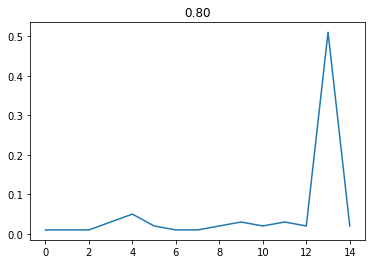

In [299]:
import matplotlib.pyplot as plt
plt.plot(range(0,15),np.array([index0/100,index1/100,index2/100,index3/100,index4/100,index5/100,index6/100,index7/100,index8/100,\
index9/100,index10/100,index11/100,index12/100,index13/100,index14/100]))
plt.title('{:.2f}'.format(index/100))

In [288]:
K.game.player_cost

array([0.95889993, 1.        , 1.04152937, 1.08352162, 1.1260071 ,
       1.16901106, 1.21255145, 1.25663669, 1.30126337, 1.34641424,
       1.39205666, 1.43814179, 1.48460469, 1.53136563, 1.57833246])

1.9249809190177618

In [89]:
        for s in b_model.action_list:
            print(b_model.compute_profits(s))

[0.20682553 0.20682553]
[0.22155186 0.2070539 ]
[0.23600529 0.20482047]
[0.2500352  0.20041303]
[0.26350889 0.19415033]
[0.27631598 0.18636658]
[0.28837091 0.17739646]
[0.29961382 0.16756186]
[0.31000971 0.15716109]
[0.31954627 0.14646121]
[0.32823096 0.13569327]
[0.3360875  0.12505043]
[0.34315225 0.11468832]
[0.34947076 0.10472711]
[0.35509455 0.0952549 ]
[0.2070539  0.22155186]
[0.22292666 0.22292666]
[0.23866335 0.22163041]
[0.25409097 0.21792449]
[0.26905004 0.2121133 ]
[0.2834008 0.2045291]
[0.29702771 0.19551608]
[0.30984202 0.18541533]
[0.32178241 0.17455169]
[0.33281401 0.16322342]
[0.34292597 0.15169495]
[0.35212819 0.14019278]
[0.36044761 0.12890402]
[0.36792429 0.11797738]
[0.37460776 0.10752566]
[0.20482047 0.23600529]
[0.22163041 0.23866335]
[0.23846389 0.23846389]
[0.25513124 0.23563339]
[0.27145021 0.23045249]
[0.2872537  0.22324207]
[0.3023962 0.2143474]
[0.31675832 0.20412196]
[0.33024927 0.19291233]
[0.34280734 0.18104534]
[0.35439862 0.16881816]
[0.36501435 0.156491

In [90]:
b_model.compute_profits(b_model.action_list)

array([[0.00226462, 0.00226462],
       [0.00226462, 0.00211642],
       [0.00226462, 0.00196538],
       [0.00226462, 0.00181518],
       [0.00226462, 0.00166854],
       [0.00226462, 0.00152741],
       [0.00226462, 0.00139312],
       [0.00226462, 0.00126651],
       [0.00226462, 0.00114806],
       [0.00226462, 0.00103797],
       [0.00226462, 0.00093621],
       [0.00226462, 0.00084261],
       [0.00226462, 0.00075688],
       [0.00226462, 0.00067865],
       [0.00226462, 0.00060749],
       [0.00211642, 0.00226462],
       [0.00211642, 0.00211642],
       [0.00211642, 0.00196538],
       [0.00211642, 0.00181518],
       [0.00211642, 0.00166854],
       [0.00211642, 0.00152741],
       [0.00211642, 0.00139312],
       [0.00211642, 0.00126651],
       [0.00211642, 0.00114806],
       [0.00211642, 0.00103797],
       [0.00211642, 0.00093621],
       [0.00211642, 0.00084261],
       [0.00211642, 0.00075688],
       [0.00211642, 0.00067865],
       [0.00211642, 0.00060749],
       [0.

In [89]:
b_model.com

(256, 2)

In [90]:
b_model.Profits.shape

(256, 2)

In [95]:
for i in range(K.game.numActions):
    print('____________________________________________________________________')
    b = int(K.game.indexActions[i][0])
    s = int(K.game.indexActions[i][1])

    cb,cb_a = K.game.buyer_cost_list[b]
    cs,cs_a = K.game.seller_cost_list[s]
    vb,vb_a = K.game.buyer_action_list[b]
    vs,vs_a = K.game.seller_action_list[s]
    penalb = 0
    penals = 0
    
    print('cb:',cb,'cs:',cs,'cb_a:',cb_a,'cs_a:',cs_a)
    print('buyer profits:',K.game.Profits[i][0])
    print('seller profits:',K.game.Profits[i][1])

____________________________________________________________________
cb: 0.5257528425553404 cs: 0.5257528425553404 cb_a: 0.5257528425553404 cs_a: 0.5257528425553404
buyer profits: 0.010333329880936354
seller profits: 0.010333329880936354
____________________________________________________________________
cb: 0.5257528425553404 cs: 0.5257528425553404 cb_a: 0.5257528425553404 cs_a: 1.0
buyer profits: 0.010333329880936354
seller profits: 0.010333329880936354
____________________________________________________________________
cb: 0.5257528425553404 cs: 0.5257528425553404 cb_a: 0.5257528425553404 cs_a: 1.531365625336648
buyer profits: 0.010333329880936354
seller profits: 0.010333329880936354
____________________________________________________________________
cb: 0.5257528425553404 cs: 0.5257528425553404 cb_a: 0.5257528425553404 cs_a: 2.0817315522524162
buyer profits: 0.010333329880936354
seller profits: 0.010333329880936354
________________________________________________________________

cb: 2.0817315522524162 cs: 2.0817315522524162 cb_a: 0.5257528425553404 cs_a: 2.0817315522524162
buyer profits: 0.21125607988518133
seller profits: 0.21125607988518133
____________________________________________________________________
cb: 2.0817315522524162 cs: 0.5257528425553404 cb_a: 1.0 cs_a: 0.5257528425553404
buyer profits: -1.7343171873316758
seller profits: -1.7241563571834062
____________________________________________________________________
cb: 2.0817315522524162 cs: 0.5257528425553404 cb_a: 1.0 cs_a: 1.0
buyer profits: -1.7343171873316758
seller profits: -1.7343171873316758
____________________________________________________________________
cb: 2.0817315522524162 cs: 0.5257528425553404 cb_a: 1.0 cs_a: 1.531365625336648
buyer profits: -1.7343171873316758
seller profits: -1.7816257450174264
____________________________________________________________________
cb: 2.0817315522524162 cs: 0.5257528425553404 cb_a: 1.0 cs_a: 2.0817315522524162
buyer profits: 0.7656828126683242
se

In [122]:
def compute_p_competitive_monopoly(c):
    p0 = np.ones((1, 2)) * 1 * c
    p_competitive = fsolve(K.game.foc, p0,args = (c,))
    p_monopoly = fsolve(K.game.foc_monopoly, p0,args = (c,))
    return p_competitive, p_monopoly

In [123]:
compute_p_competitive_monopoly(1)

(array([1.47292666, 1.47292666]), array([1.92498092, 1.92498092]))

In [124]:
compute_p_competitive_monopoly(0.52)

(array([1.01522646, 1.01522646]), array([1.81557214, 1.81557214]))

In [125]:
def compute_p_competitive_monopoly(c):
    p0 = np.ones((1, 2)) * 1 * c
    p_competitive = fsolve(K.game.foc, p0,args = (,c))
    p_monopoly = fsolve(K.game.foc_monopoly, p0,args = (,c))
    return p_competitive, p_monopoly

SyntaxError: invalid syntax (2600325829.py, line 3)

In [137]:
    def demand(p):
        e = np.exp((K.game.a - p) / K.game.mu)
        d = e / (np.sum(e) + np.exp(K.game.a0 / K.game.mu))
        return d
    
    def foc(p,c):

        d = demand(p)
        zero = 1 - (p - c) * (1 - d) / K.game.mu
        return np.squeeze(zero)

    
    def foc_monopoly(p,c):

        d = demand(p)
        d1 = np.flip(d)
        p1 = np.flip(p)
        zero = 1 - (p - c) * (1 - d) / K.game.mu + (p1 - c) * d1 / K.game.mu
        return np.squeeze(zero)

In [128]:
fsolve(foc,np.ones((1, 2)) * 1 * 0.52)

array([1.01522646, 1.01522646])

In [132]:
fsolve(foc_monopoly,np.ones((1, 2)) * 1 * 0.52)

array([1.81557214, 1.81557214])

In [139]:
fsolve(foc_monopoly,np.ones((1, 2)) * 3 * c,args = (0.52,))

array([1.81557214, 1.81557214])

In [140]:
fsolve(foc_monopoly,np.ones((1, 2)) * 3 * c,args = (1,))

array([1.92498092, 1.92498092])

In [150]:
fsolve(dev,3*1,args = (1,))

array([1.92498092])

In [149]:
def dev(p,c):
    zero = -p+c+K.game.mu*(1+2*np.exp((K.game.a-p-K.game.a0)/K.game.mu))
    return zero